analyse.ipynb 

# **En komparativ studie av GPT-4 og legers svar på helserelaterte spørsmål** 

Tiril Egset Mork¹, Håkon Garnes Mjøs¹, Harald Giskegjerde Nilsen², Sindre Kjelsrud², Alexander Selvikvåg Lundervold³, Arvid Lundervold⁴, Ib Jammer⁵ <br>

¹ Det medisinske fakultet, Universitetet i Bergen <br>
² Høgskulen på Vestlandet<br>
³ Institutt for datateknologi, elektroteknologi og realfag, Høgskulen på Vestlandet<br>
⁴ Institutt for biomedisin, Universitetet i Bergen<br>
⁵ Kirurgisk serviceklinikk, Haukeland universitetssykehus (ib.jammer@helse-bergen.no)


Sist oppdatert: 2024-10-14b (A.L.)

Benytter `helseveileder` conda environment (Python 3.12)

### Følgende hypoteser undersøkes:

**Kunnskapsnivå** :<br>
H0: GPT-4 genererer svar på helsespørsmål på _samme_ kunnskapsnivå, sammenlignet svar fra utdannede og lisensierte leger (MDs).<br>
H1: GPT-4 genererer svar på helsespørsmål med _forskjellig_ kunnskapsnivå sammenlignet med leger (trolig _lavere_ kunnskapsnivå).

**Empati** :<br>
H0: GPT-4 genererer svar på helsespørsmål med _samme_ grad av empati, sammenlignet med svar fra leger.<br>
H1: GPT-4 genererer svar på helsespørsmål med _ulik_ grad av empati sammenlignet med leger (trolig _mindre_ grad av empati).

**Hjelpsomhet** :<br>
H0: GPT-4 genererer _samme_ grad av hjelpsomme svar på helsespørsmål, sammenlignet med leger.<br>
H1: GPT-4 genererer _forskjellig_ grad av hjelpsomme svar på helsespørsmål sammenlignet med leger (trolig _mindre_ hjelpsomhet).


Oversikt over materialet:

| Beskrivelse | Verdi |
|-------------|-------|
| Totalt antall spørsmål (hvert med to svar - legesvar og GPT-4 svar til vurdering) | 192 |
| Totalt antall respondenter  | 344 |
| Totalt antall responser (respondent-vurderinger av sett med spørsmål og svar) | 2218 |
| Gjennomsnitt (sd) antall respondenter per spørsmål (med legesvar og GPT-4 svar) | 5.70 (6.66) |
| Median antall (min-max) respondenter per spørsmål (med legesvar og GPT-4 svar)  | 5 (1-64) |
| Antall respondenter som har deltatt i studien mer enn en gang | 18 (5.2%) |
| Antall respondenter som oppgir å være lege eller medisinstudent med lisens. | 44 (12.8%) |
| Antall respondenter som ikke er lege eller medisinstudent med lisens, men som studerer, arbeider eller har bakgrunn innen helsevesenet | 300 (87.2%) |
| Median (min-max) lengde på spørsmål | 89.5 (8-200) ord |
| Median (min-max lengde legesvar (totalt 1106 respondent-vurderinger) | 115 (39-408) ord |
| Median (min-max) svarlengde GPT-4 (totalt 1112 respondent-vurderinger) | 204 (130-347) ord |

# Oppsett / biblioteker

In [1]:
%matplotlib inline
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu 

# Les inn data

```python
# Lage et dataframe dh med respondenter som enten er helsepersonell eller har harlisens
dh = df[(df['harlisens'] == True) | (df['helsepersonell'] == True)]
```
helseveileder_2287x18.csv -->  `helseveileder_2218x18.csv`

In [2]:
df = pd.read_csv('../data/helseveileder_2218x18.csv')
len(df)

2218

In [3]:
list(df.columns)

['vurderingid',
 'respondentid',
 'svarid',
 'kunnskap',
 'empati',
 'hjelpsomhet',
 'alder',
 'utdanningsgrad',
 'helsepersonell',
 'harlisens',
 'kjønn',
 'svartfør',
 'fylke',
 'dato',
 'spørsmålid',
 'chatgpt',
 'svartekst',
 'tekst']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   vurderingid     2218 non-null   int64 
 1   respondentid    2218 non-null   int64 
 2   svarid          2218 non-null   int64 
 3   kunnskap        2218 non-null   int64 
 4   empati          2218 non-null   int64 
 5   hjelpsomhet     2218 non-null   int64 
 6   alder           2190 non-null   object
 7   utdanningsgrad  2218 non-null   object
 8   helsepersonell  2218 non-null   bool  
 9   harlisens       2218 non-null   bool  
 10  kjønn           2198 non-null   object
 11  svartfør        2218 non-null   bool  
 12  fylke           2216 non-null   object
 13  dato            2218 non-null   object
 14  spørsmålid      2218 non-null   int64 
 15  chatgpt         2218 non-null   bool  
 16  svartekst       2218 non-null   object
 17  tekst           2218 non-null   object
dtypes: bool(

In [5]:
# Make a dataframe dmeta with the metadata (col-number, col-name, data-type, number-of-nans, min, max) of the dataframe df

# Create a list of column numbers
col_numbers = range(len(df.columns)+1)[1:]

# Create a list of column names
col_names = df.columns

# Create a list of column data types
col_dtypes = df.dtypes

# Create a list of column number of NaNs
col_nans = df.isna().sum()

# Create a list of column minimum values excluding NaN
def min_of_each_column(df):
    return df.apply(lambda col: col.dropna().min())
col_min = min_of_each_column(df)

# Create a list of column maximum values
def max_of_each_column(df):
    return df.apply(lambda col: col.dropna().max())
col_max = max_of_each_column(df)

# Create a dataframe dmeta with the metadata
dmeta = pd.DataFrame({'col_number': col_numbers, 'col_name': col_names, 'col_dtype': col_dtypes, 'col_nans': col_nans, 'col_min': col_min, 'col_max': col_max})

# Reset the index of the dataframe dmeta
dmeta.reset_index(drop=True, inplace=True)

# Display the dataframe dmeta
dmeta

,col_number,col_name,col_dtype,col_nans,col_min,col_max
0,1,vurderingid,int64,0,1,2304
1,2,respondentid,int64,0,3,638
2,3,svarid,int64,0,1,393
3,4,kunnskap,int64,0,1,6
4,5,empati,int64,0,1,5
5,6,hjelpsomhet,int64,0,1,5
6,7,alder,object,28,18-20,61-70
7,8,utdanningsgrad,object,0,Bachelor,VGS
8,9,helsepersonell,bool,0,True,True
9,10,harlisens,bool,0,False,True


In [6]:
df


,vurderingid,respondentid,svarid,kunnskap,empati,hjelpsomhet,alder,utdanningsgrad,helsepersonell,harlisens,kjønn,svartfør,fylke,dato,spørsmålid,chatgpt,svartekst,tekst
0,1,6,1,3,4,4,18-20,PhD,True,False,Kvinne,False,Vestland,2024-01-15T10:39:13.805Z,1,False,Takk for spørsmålet ditt! Jeg skal være ærlig ...,Hei! Jeg har jo hørt at sånn belegg som var i ...
1,4,7,1,2,4,3,18-20,PhD,True,False,Kvinne,False,Vestland,2024-01-15T10:39:27.752Z,1,False,Takk for spørsmålet ditt! Jeg skal være ærlig ...,Hei! Jeg har jo hørt at sånn belegg som var i ...
2,8,8,1,5,4,5,20-30,PhD,True,False,Mann,False,Vestland,2024-01-15T10:39:52.900Z,1,False,Takk for spørsmålet ditt! Jeg skal være ærlig ...,Hei! Jeg har jo hørt at sånn belegg som var i ...
3,13,3,1,5,4,4,20-30,PhD,True,False,Mann,False,Vestland,2024-01-15T10:38:43.709Z,1,False,Takk for spørsmålet ditt! Jeg skal være ærlig ...,Hei! Jeg har jo hørt at sånn belegg som var i ...
4,1722,542,1,2,4,4,NaN,VGS,True,False,Kvinne,False,Vestland,2024-01-30T07:19:38.401Z,1,False,Takk for spørsmålet ditt! Jeg skal være ærlig ...,Hei! Jeg har jo hørt at sånn belegg som var i ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,2253,634,390,5,2,4,21-30,VGS,True,False,Kvinne,True,Vestland,2024-02-14T07:29:01.729Z,238,False,Det er nok ikke vanlig rutine å gi full narkos...,Hei! Vet ikke om det mulig å få riktig svar he...
2214,2263,635,390,3,2,3,21-30,Bachelor,True,False,Kvinne,True,Vestland,2024-02-14T07:32:31.629Z,238,False,Det er nok ikke vanlig rutine å gi full narkos...,Hei! Vet ikke om det mulig å få riktig svar he...
2215,2255,634,393,5,5,4,21-30,VGS,True,False,Kvinne,True,Vestland,2024-02-14T07:29:01.729Z,239,True,Hei! Det å drikke 3-4 glass vann etter hverand...,Hei! Jeg drakk ganske mye vann en natt av ulik...
2216,2265,635,393,4,4,4,21-30,Bachelor,True,False,Kvinne,True,Vestland,2024-02-14T07:32:31.629Z,239,True,Hei! Det å drikke 3-4 glass vann etter hverand...,Hei! Jeg drakk ganske mye vann en natt av ulik...


In [7]:
# Find number of unique values for a list of variables in df

variabler1 = ['vurderingid', 'respondentid', 'svarid', 'kunnskap', 'empati', 'hjelpsomhet', 
             'alder', 'utdanningsgrad', 'helsepersonell', 'harlisens', 'kjønn', 'svartfør', 
             'fylke', 'dato', 'spørsmålid', 'chatgpt']

for var in variabler1:
    if var in df.columns:
        unike_verdier = df[var].nunique()
        print(f"{var}: {unike_verdier} unike verdier")
    else:
        print(f"{var} finnes ikke i dataframen")

vurderingid: 2218 unike verdier
respondentid: 344 unike verdier
svarid: 384 unike verdier
kunnskap: 6 unike verdier
empati: 5 unike verdier
hjelpsomhet: 5 unike verdier
alder: 7 unike verdier
utdanningsgrad: 5 unike verdier
helsepersonell: 1 unike verdier
harlisens: 2 unike verdier
kjønn: 2 unike verdier
svartfør: 2 unike verdier
fylke: 9 unike verdier
dato: 344 unike verdier
spørsmålid: 192 unike verdier
chatgpt: 2 unike verdier


In [8]:
# Skriv ut antall forekomster av chatgpt=True og chatgpt=False 
print(f"chatgpt=True: {len(df[df['chatgpt'] == True])}")
print(f"chatgpt=False: {len(df[df['chatgpt'] == False])}")


chatgpt=True: 1112
chatgpt=False: 1106


In [9]:
# Median antall responser (ikke respondenter) per spørsmål 
df['spørsmålid'].value_counts().median()


np.float64(10.0)

In [10]:
# List respondeter som har svart per spm.id
spm_respondent_list = [df[df['spørsmålid'] == x]['respondentid'].unique() for x in df['spørsmålid'].unique()]

spm_respondent_list_length = [len(x) for x in spm_respondent_list]
spm_respondent_list_length_median = np.median(spm_respondent_list_length)
spm_respondent_list_length_mean = np.mean(spm_respondent_list_length)
spm_respondent_list_length_std = np.std(spm_respondent_list_length)
spm_respondent_list_length_min = np.min(spm_respondent_list_length)
spm_respondent_list_length_max = np.max(spm_respondent_list_length)

print('Antall respondenter per spm.id:')
print(f"Median: {spm_respondent_list_length_median}")
print(f"Gjennomsnitt: {spm_respondent_list_length_mean} ({spm_respondent_list_length_mean*2})")
print(f"Standardavvik: {spm_respondent_list_length_std}")
print(f"Minimum: {spm_respondent_list_length_min}")
print(f"Maksimum: {spm_respondent_list_length_max}")



Antall respondenter per spm.id:
Median: 5.0
Gjennomsnitt: 5.703125 (11.40625)
Standardavvik: 6.65992294007283
Minimum: 1
Maksimum: 64


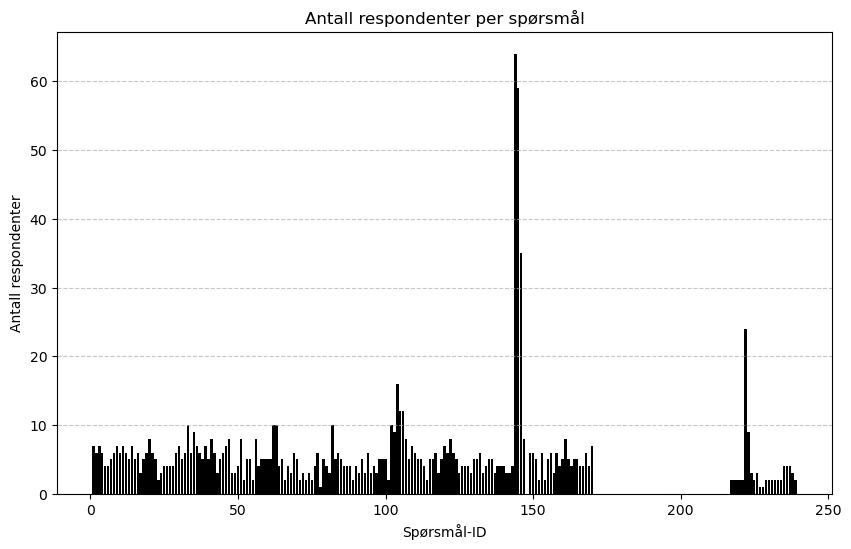

In [11]:
# Lag et stolpediagram av spm_respondent_list_length versus df['spørsmålid'].unique()

plt.figure(figsize=(10, 6))
plt.bar(df['spørsmålid'].unique(), spm_respondent_list_length, color='black')
plt.xlabel('Spørsmål-ID')
plt.ylabel('Antall respondenter')
plt.title('Antall respondenter per spørsmål')   
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




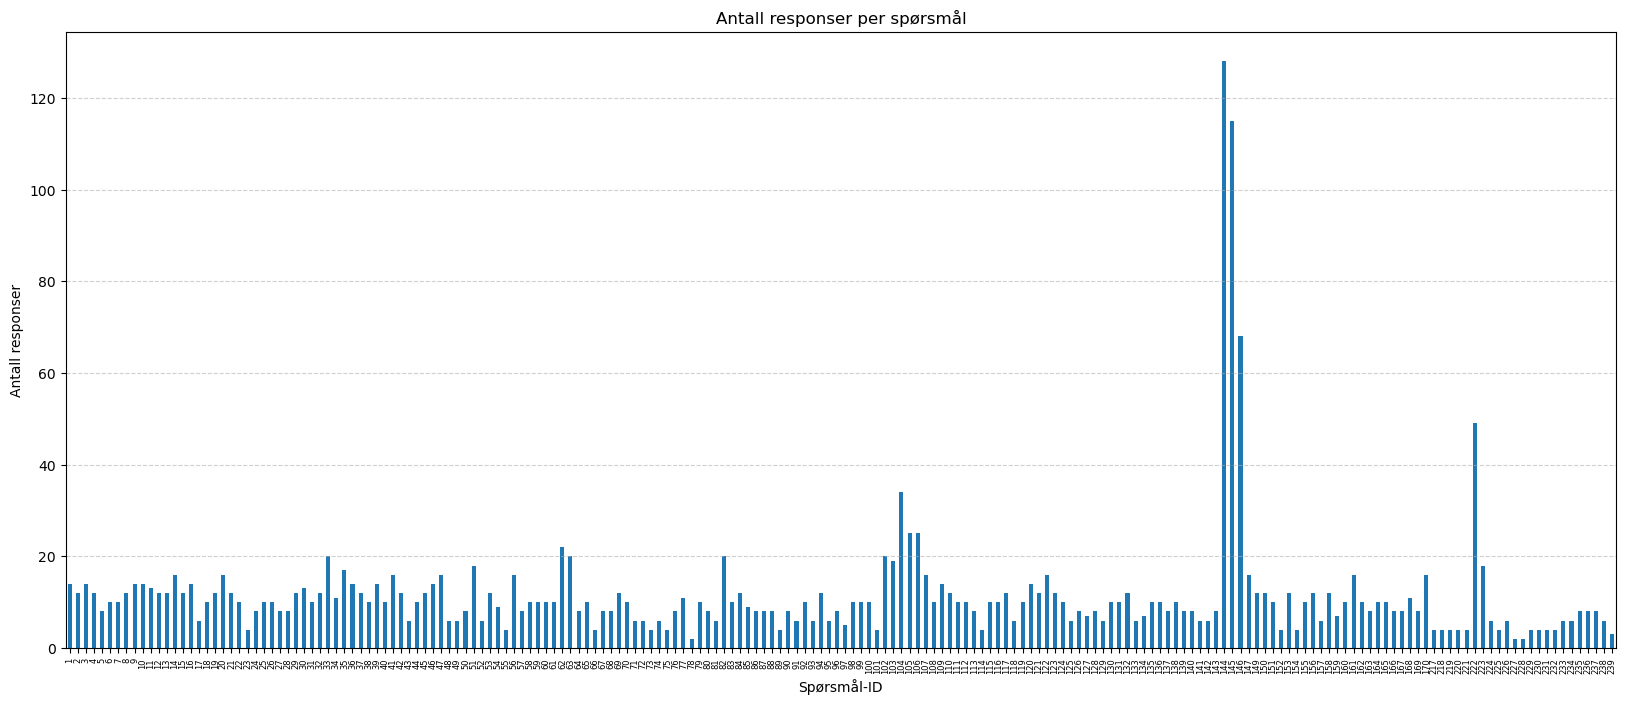

In [12]:
# Lag stolpediagram av antall responser per spørsmål sortert etter stigende spørsmålid

df['spørsmålid'] = df['spørsmålid'].astype('int')

df['spørsmålid'].value_counts().sort_index().plot(kind='bar', figsize=(20, 8))
plt.title('Antall responser per spørsmål')
plt.xlabel('Spørsmål-ID')
plt.ylabel('Antall responser')

# Lag gridlinjer i diagrammet
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Lag ticklabels i mindre font
plt.xticks(fontsize=6)

plt.show()





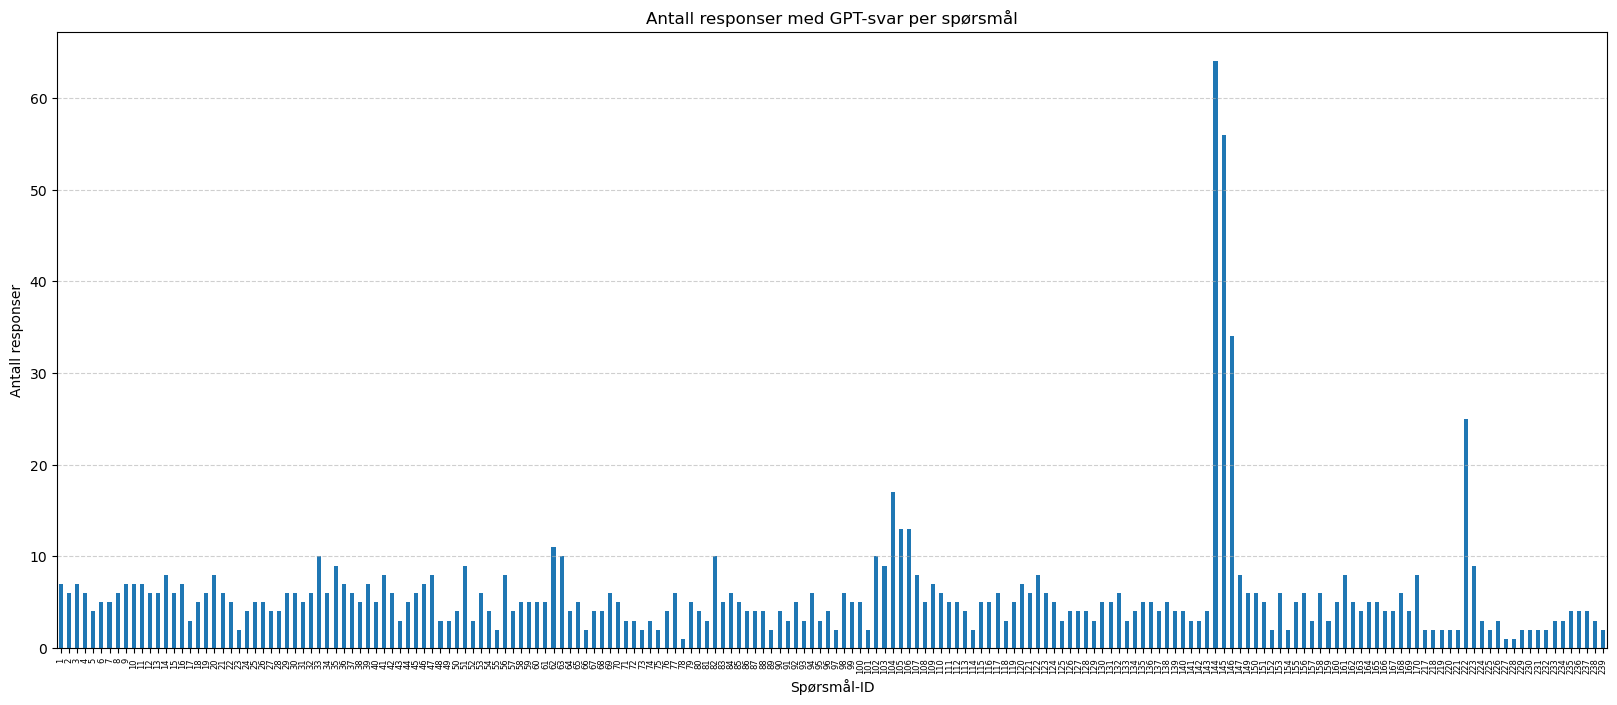

In [13]:
# Lag stolpediagram av antall responser med GPT-svar per spørsmål sortert etter stigende spørsmålid

df['spørsmålid'] = df['spørsmålid'].astype('int')

df_gpt = df[df['chatgpt'] == True]

df_gpt['spørsmålid'].value_counts().sort_index().plot(kind='bar', figsize=(20, 8))
plt.title('Antall responser med GPT-svar per spørsmål')

plt.xlabel('Spørsmål-ID')
plt.ylabel('Antall responser')

# Lag gridlinjer i diagrammet
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Lag ticklabels i mindre font
plt.xticks(fontsize=6)

plt.show()




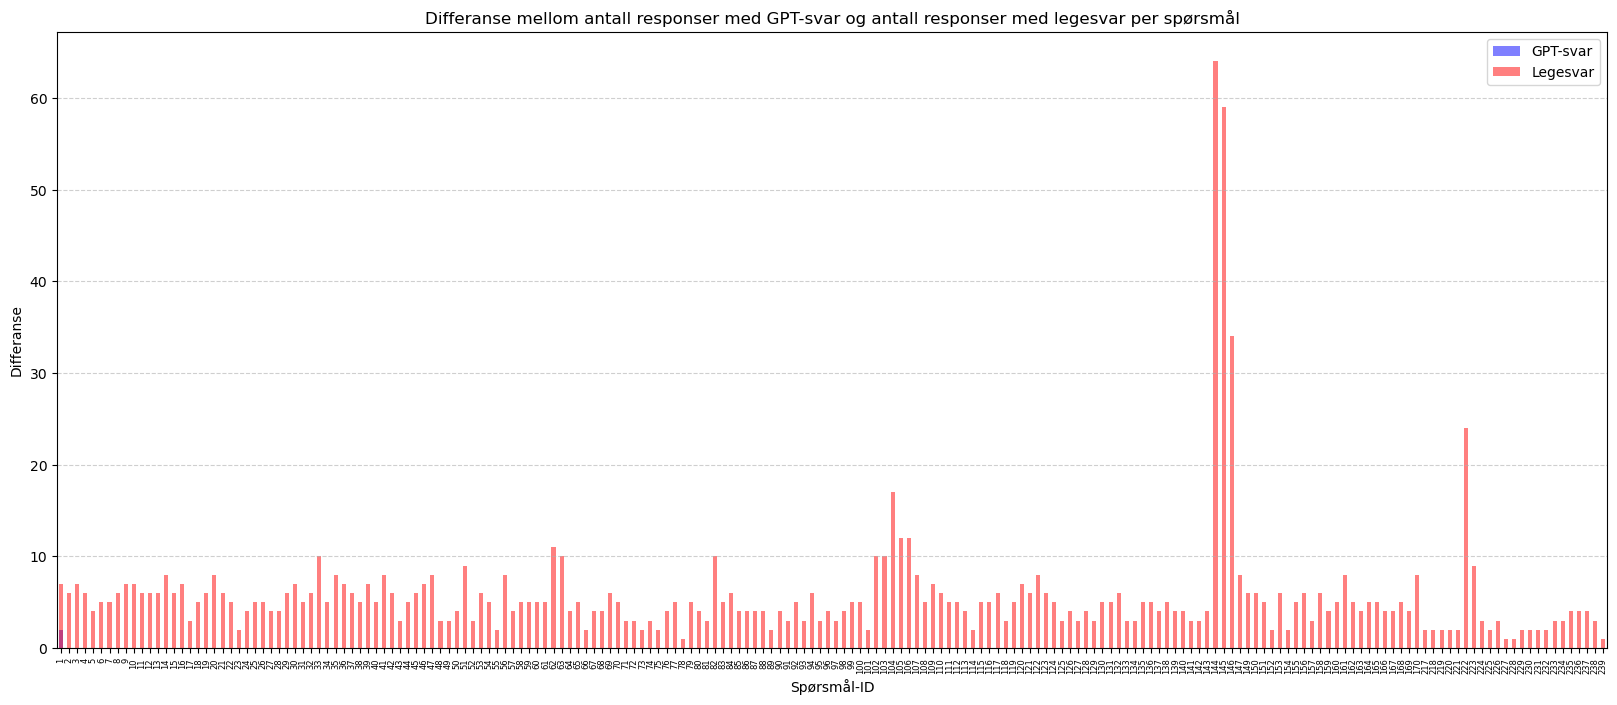

In [29]:
# Lag stolpediagram av differensane mellom antall responser med GPT-svar og antall responser med legesvar per spørsmål sortert etter stigende spørsmålid

df_legesvar = df[df['chatgpt'] == False]

df_gpt['spørsmålid'].value_counts().sort_index().plot(kind='bar', figsize=(20, 8), color='blue', alpha=0.5, label='GPT-svar')
df_legesvar['spørsmålid'].value_counts().sort_index().plot(kind='bar', figsize=(20, 8), color='red', alpha=0.5, label='Legesvar')

plt.title('Differanse mellom antall responser med GPT-svar og antall responser med legesvar per spørsmål')

plt.xlabel('Spørsmål-ID')
plt.ylabel('Differanse')

# Lag gridlinjer i diagrammet
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Lag ticklabels i mindre font
plt.xticks(fontsize=6)

plt.legend()

plt.show()


In [30]:
# Finn spørsmålid og responsid der antall responser med GPT-svar er forksjellig fra antall responser med legesvar

j = 0
for i, spmid in enumerate(list(df['spørsmålid'].unique())):
    df_gpt = df[(df['chatgpt'] == True) & (df['spørsmålid'] == spmid)]
    df_legesvar = df[(df['chatgpt'] == False) & (df['spørsmålid'] == spmid)]
    if len(df_gpt) != len(df_legesvar):
        j = j+1
        print(f"j={j} (i={i}) Spørsmål-ID: {spmid}")
        print(f"Antall responser med GPT-svar: {len(df_gpt)}")
        print(f"Antall responser med legesvar: {len(df_legesvar)}")
        print(f"Antall unike respondentid med GPT-svar: {df_gpt['respondentid'].nunique()}")
        print(f"Antall unike respondentid med legesvar: {df_legesvar['respondentid'].nunique()}")
        print(f"Antall unike svarid med GPT-svar: {df_gpt['svarid'].nunique()}")
        print(f"Antall unike svarid med legesvar: {df_legesvar['svarid'].nunique()}")
        print(f"Antall unike vurderingid med GPT-svar: {df_gpt['vurderingid'].nunique()}")
        print(f"Antall unike vurderingid med legesvar: {df_legesvar['vurderingid'].nunique()}")

# Print antall som har svartfør=True og antall som har svartfør=False
print(f"\nAntall som har svartfør=True: {len(df[df['svartfør'] == True])}")
print(f"Antall som har svartfør=False: {len(df[df['svartfør'] == False])}")

# Print antall respondentid som har svartfør=True og antall som har svartfør=False
print(f"\nAntall unike respondentid som har svartfør=True: {df[df['svartfør'] == True]['respondentid'].nunique()}")
print(f"Antall unike respondentid som har svartfør=False: {df[df['svartfør'] == False]['respondentid'].nunique()}")
print(f"Antall unike respondentid totalt: {df['respondentid'].nunique()}")

# Print antall svarid som har svartfør=True og antall som har svartfør=False
print(f"\nAntall unike svarid som har svartfør=True: {df[df['svartfør'] == True]['svarid'].nunique()}")
print(f"Antall unike svarid som har svartfør=False: {df[df['svartfør'] == False]['svarid'].nunique()}")

# Print antall vurderingid som har svartfør=True og antall som har svartfør=False
print(f"\nAntall unike vurderingid som har svartfør=True: {df[df['svartfør'] == True]['vurderingid'].nunique()}")
print(f"Antall unike vurderingid som har svartfør=False: {df[df['svartfør'] == False]['vurderingid'].nunique()}")
print(f"Antall unike vurderingid totalt: {df['vurderingid'].nunique()}")

# Print antall respondentid som har svartfør=True og har chatgpt=True
print(f"\nAntall unike respondentid som har svartfør=True og chatgpt=True: {df[(df['svartfør'] == True) & (df['chatgpt'] == True)]['respondentid'].nunique()}")
print(f"Antall unike respondentid som har svartfør=True og chatgpt=False: {df[(df['svartfør'] == True) & (df['chatgpt'] == False)]['respondentid'].nunique()}")
print(f"\nAntall unike respondentid som har svartfør=False og chatgpt=True: {df[(df['svartfør'] == False) & (df['chatgpt'] == True)]['respondentid'].nunique()}")
print(f"Antall unike respondentid som har svartfør=False og chatgpt=False: {df[(df['svartfør'] == False) & (df['chatgpt'] == False)]['respondentid'].nunique()}")



j=1 (i=10) Spørsmål-ID: 11
Antall responser med GPT-svar: 7
Antall responser med legesvar: 6
Antall unike respondentid med GPT-svar: 7
Antall unike respondentid med legesvar: 6
Antall unike svarid med GPT-svar: 1
Antall unike svarid med legesvar: 1
Antall unike vurderingid med GPT-svar: 7
Antall unike vurderingid med legesvar: 6
j=2 (i=32) Spørsmål-ID: 30
Antall responser med GPT-svar: 6
Antall responser med legesvar: 7
Antall unike respondentid med GPT-svar: 6
Antall unike respondentid med legesvar: 7
Antall unike svarid med GPT-svar: 1
Antall unike svarid med legesvar: 1
Antall unike vurderingid med GPT-svar: 6
Antall unike vurderingid med legesvar: 7
j=3 (i=36) Spørsmål-ID: 34
Antall responser med GPT-svar: 6
Antall responser med legesvar: 5
Antall unike respondentid med GPT-svar: 6
Antall unike respondentid med legesvar: 5
Antall unike svarid med GPT-svar: 1
Antall unike svarid med legesvar: 1
Antall unike vurderingid med GPT-svar: 6
Antall unike vurderingid med legesvar: 5
j=4 (i=

In [31]:
# 1. Sjekk for manglende data
def sjekk_manglende_data():
    print("\n1. Sjekk for manglende data:")
    manglende_gpt = df[df['chatgpt'] == True]['spørsmålid'].nunique()
    manglende_lege = df[df['chatgpt'] == False]['spørsmålid'].nunique()
    print(f"Antall unike spørsmål med GPT-svar: {manglende_gpt}")
    print(f"Antall unike spørsmål med legesvar: {manglende_lege}")
    print(f"Differanse: {abs(manglende_gpt - manglende_lege)}")


# 2. Sjekk for spørsmål uten legesvar
def sjekk_spørsmål_uten_legesvar():
    print("\n4. Sjekk for spørsmål uten legesvar:")
    gpt_spørsmål = set(df[df['chatgpt'] == True]['spørsmålid'])
    lege_spørsmål = set(df[df['chatgpt'] == False]['spørsmålid'])
    kun_gpt = gpt_spørsmål - lege_spørsmål
    print(f"Antall spørsmål kun besvart av GPT: {len(kun_gpt)}")
    if len(kun_gpt) > 0:
        print("Eksempler på spørsmål kun besvart av GPT:")
        print(list(kun_gpt)[:5])


# Kjør alle sjekkene
sjekk_manglende_data()
sjekk_spørsmål_uten_legesvar()


1. Sjekk for manglende data:
Antall unike spørsmål med GPT-svar: 192
Antall unike spørsmål med legesvar: 192
Differanse: 0

4. Sjekk for spørsmål uten legesvar:
Antall spørsmål kun besvart av GPT: 0


In [32]:
# List the set of unique values for a sublist of variables in df

variabler2 = ['kunnskap', 'empati', 'hjelpsomhet', 'alder', 'utdanningsgrad', 'helsepersonell', 
             'harlisens', 'kjønn', 'svartfør', 'fylke', 'chatgpt']

for var in variabler2:
    if var in df.columns:
        unike_verdier = df[var].unique()
        
        # Konverter alle verdier til strenger for konsistent visning
        unike_verdier_str = [str(val) for val in unike_verdier]
        
        # Sorter strengverdiene
        unike_verdier_sortert = sorted(unike_verdier_str)
        
        print(f"\n{var}:")
        print(unike_verdier_sortert)
    else:
        print(f"\n{var} finnes ikke i dataframen")


kunnskap:
['1', '2', '3', '4', '5', '6']

empati:
['1', '2', '3', '4', '5']

hjelpsomhet:
['1', '2', '3', '4', '5']

alder:
['18-20', '20-30', '21-30', '31-40', '41-50', '51-60', '61-70', 'nan']

utdanningsgrad:
['Bachelor', 'Master', 'PhD', 'Profesjonsstudium', 'VGS']

helsepersonell:
['True']

harlisens:
['False', 'True']

kjønn:
['Kvinne', 'Mann', 'nan']

svartfør:
['False', 'True']

fylke:
['Agder', 'Møre og Romsdal', 'Oslo', 'Rogaland', 'Troms og Finnmark', 'Trøndelag', 'Vestfold og Telemark', 'Vestland', 'Viken', 'nan']

chatgpt:
['False', 'True']


In [33]:
# Calculate values
total_questions = len(df['spørsmålid'].unique())
total_respondents = len(df['respondentid'].unique())
total_responses = len(df)
avg_responses_per_question = total_responses / total_questions
median_responses_per_question = df.groupby('spørsmålid').size().median()

# Count respondents who participated more than once
repeat_participants = df.groupby('respondentid').size()
repeat_participants = repeat_participants[repeat_participants > 1]
repeat_count = len(repeat_participants)
repeat_percentage = (repeat_count / total_respondents) * 100

# Count respondents by type
licensed_doctors = df[df['harlisens'] == True]['respondentid'].nunique()
licensed_percentage = (licensed_doctors / total_respondents) * 100

health_background = df[(df['helsepersonell'] == True) & (df['harlisens'] == False)]['respondentid'].nunique()
health_background_percentage = (health_background / total_respondents) * 100

# Calculate question and answer lengths
question_lengths = df.groupby('spørsmålid')['tekst'].first().str.split().str.len()
human_answer_lengths = df[df['chatgpt'] == False]['svartekst'].str.split().str.len()
gpt_answer_lengths = df[df['chatgpt'] == True]['svartekst'].str.split().str.len()

# Create the table
table = pd.DataFrame({
    'Beskrivelse': [
        'Totalt antall spørsmål (hvert med to svar til vurdering)',
        'Totalt antall respondenter',
        'Totalt antall responser (vurderinger av sett med spørsmål og svar)',
        'Gjennomsnittlig antall responser per spørsmål',
        'Median antall respondenser per spørsmål',
        'Antall som har deltatt i studien mer enn en gang',
        'Antall respondenter som oppgir å være lege eller medisinstudent med lisens.',
        'Antall respondenter som ikke er lege eller medisinstudent med lisens, men som studerer, arbeider eller har bakgrunn innen helsevesenet',
        'Median (range) lengde på spørsmål',
        'Median (range svarlengde legesvar (1142 vurderinger)',
        'Median (range) svarlengde GPT-4 (1145 vurderinger)'
    ],
    'Verdi': [
        f"{total_questions}",
        f"{total_respondents}",
        f"{total_responses}",
        f"{avg_responses_per_question:.1f}",
        f"{median_responses_per_question}",
        f"{repeat_count} ({repeat_percentage:.1f}%)",
        f"{licensed_doctors} ({licensed_percentage:.1f}%)",
        f"{health_background} ({health_background_percentage:.1f}%)",
        f"{question_lengths.median()} ({question_lengths.min()}-{question_lengths.max()}) ord",
        f"{human_answer_lengths.median()} ({human_answer_lengths.min()}-{human_answer_lengths.max()}) ord",
        f"{gpt_answer_lengths.median()} ({gpt_answer_lengths.min()}-{gpt_answer_lengths.max()}) ord"
    ]
})

print(table.to_string(index=False))

print(f"\nAntall unike respondentid som har svartfør=True og chatgpt=True: {df[(df['svartfør'] == True) & (df['chatgpt'] == True)]['respondentid'].nunique()}")
print(f"Antall unike respondentid som har svartfør=True og chatgpt=False: {df[(df['svartfør'] == True) & (df['chatgpt'] == False)]['respondentid'].nunique()}")

                                                                                                                           Beskrivelse               Verdi
                                                                              Totalt antall spørsmål (hvert med to svar til vurdering)                 192
                                                                                                            Totalt antall respondenter                 344
                                                                    Totalt antall responser (vurderinger av sett med spørsmål og svar)                2218
                                                                                         Gjennomsnittlig antall responser per spørsmål                11.6
                                                                                               Median antall respondenser per spørsmål                10.0
                                                                      

Antall GPT-4 svar: 1112, Antall legesvar:1106. Totalt: 2218


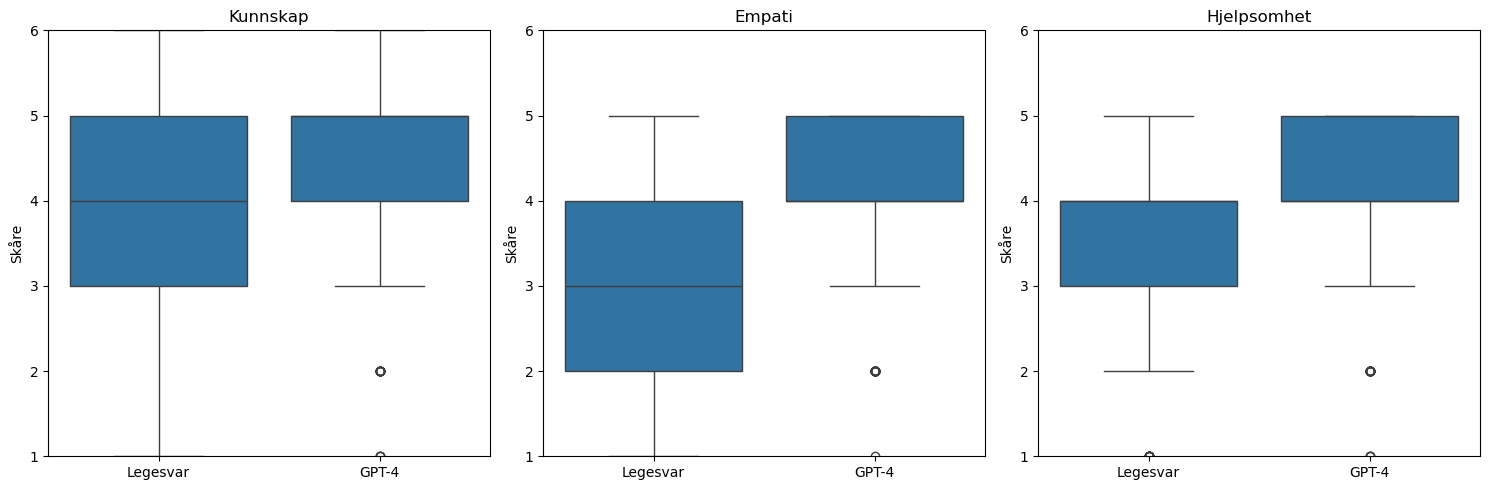

In [34]:
df_GPT = df[df['chatgpt'] == True]
df_human = df[df['chatgpt'] == False]

print(f'Antall GPT-4 svar: {len(df_GPT)}, Antall legesvar:{len(df_human)}. Totalt: {len(df_GPT) + len(df_human)}')

# Make a boxplot to compare the GPT and human responses for `kunnskap', 'empati` and 'hjelpsomhet'

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Custom order and labels for x-axis
order = [False, True]
labels = ['Legesvar', 'GPT-4']

for i, metric in enumerate(['kunnskap', 'empati', 'hjelpsomhet']):
    sns.boxplot(x='chatgpt', y=metric, data=df, ax=ax[i], order=order)
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(labels)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Skåre')
    ax[i].set_title(metric.capitalize())
    ax[i].set_ylim(1, 6)

plt.tight_layout()

### Hypotese 1 som undersøkes (mhp. df) er følgende:

**Kunnskapsnivå** :<br>
H0: GPT-4 genererer svar på helsespørsmål på _samme_ kunnskapsnivå, sammenlignet svar fra utdannede og lisensierte leger (MDs).<br>
H1: GPT-4 genererer svar på helsespørsmål med _forskjellig_ kunnskapsnivå sammenlignet med leger (trolig _lavere_ kunnskapsnivå).

For å teste denne hypotesen kan vi bruke en statistisk test. Gitt at vi har ordinale data (Likert-skala vurderinger) og to uavhengige grupper (GPT-4 og leger),
er **Mann-Whitney U-testen** en passende metode. Her er hvordan du kan implementere dette i Python:

In [35]:
import numpy as np
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['chatgpt'], df['kunnskap'])

contingency_table_margins = pd.crosstab(df['chatgpt'], df['kunnskap'], margins=True)
contingency_table_margins

kunnskap,1,2,3,4,5,6,All
chatgpt,,,,,,,
False,6,82,237,471,263,47,1106
True,3,20,85,434,527,43,1112
All,9,102,322,905,790,90,2218


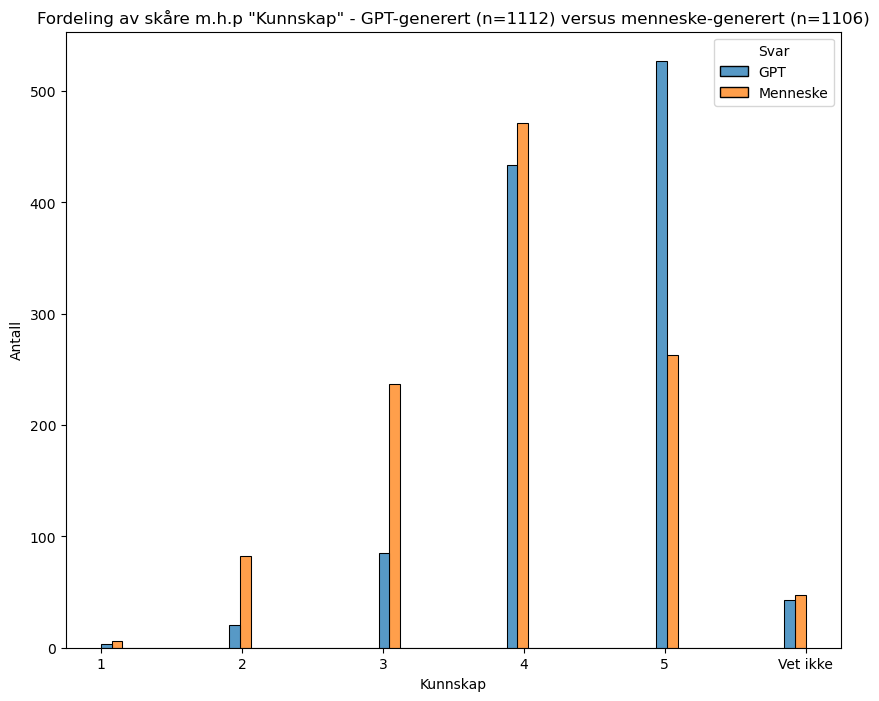

In [36]:
# Plot the distribution of the scores for "kunnskap" - GPT versus human

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT[['kunnskap']].assign(Svar='GPT'), df_human[['kunnskap']].assign(Svar='Menneske')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='kunnskap', hue='Svar', multiple='dodge')

plt.xlabel('Kunnskap')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "Kunnskap" - GPT-generert (n={len(df_GPT)}) versus menneske-generert (n={len(df_human)})')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 7, 1))

# Assuming 'plt' is the current plot
ticks, labels = plt.xticks()  # Get current x-axis tick labels

# Find the index of the tick mark 6
index = list(ticks).index(6)

# Replace the label at the index with 'Vet ikke'
labels[index] = 'Vet ikke'

plt.xticks(ticks, labels)  # Set new x-axis tick labels


plt.show()

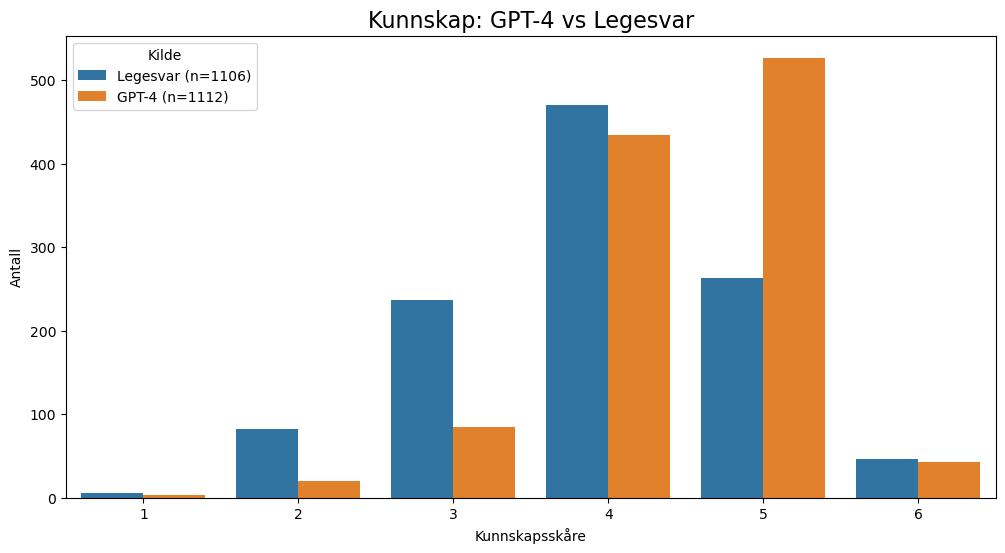

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Anta at 'df1' er din dataframe med kolonner 'chatgpt' (True/False) og 'kunnskap' (1-6)

plt.figure(figsize=(12, 6))
sns.countplot(x='kunnskap', hue='chatgpt', data=df)
plt.title('Kunnskap: GPT-4 vs Legesvar', fontsize=16)
plt.xlabel('Kunnskapsskåre')
plt.ylabel('Antall')
plt.legend(title='Kilde', labels=[f'Legesvar (n={len(df_human)})', f'GPT-4 (n={len(df_GPT)})'])
# Save figure
plt.savefig('../assets/kunnskap.png', dpi=300)

# Save as pdf
plt.savefig('../assets/kunnskap.pdf', format='pdf')
plt.show()

#### Ignorér "`Vet ikke`" (skåre 6) vedrørende `kunnskap` i forbindesle med Mann-Whitney U test og  Chi-kvadrat test

In [38]:
# Make new dataframes df_GPT_kunsskap_excl6 and df_human_kunnskap_excl6 where kunnskap is not 6

df_GPT_kunnskap_excl6 = df_GPT[df_GPT['kunnskap'] != 6]
df_human_kunnskap_excl6 = df_human[df_human['kunnskap'] != 6]

print(f'len(df_GPT_kunnskap_excl6)={len(df_GPT_kunnskap_excl6)}, len(df_human_kunnskap_excl6)={len(df_human_kunnskap_excl6)}')


len(df_GPT_kunnskap_excl6)=1069, len(df_human_kunnskap_excl6)=1059


In [39]:
df1 = df.copy()
# Convert 'kunnskap' to numeric, coercing errors to NaN
df1['kunnskap'] = pd.to_numeric(df1['kunnskap'], errors='coerce')

# Remove rows with NaN values in 'kunnskap'
df1 = df1.dropna(subset=['kunnskap'])

# Remove rows with value 6 ("vet ikke") in 'kunnskap'
df1 = df1[df1['kunnskap'] != 6]

# Ensure 'chatgpt' is boolean
df['chatgpt'] = df['chatgpt'].astype(bool)

# Now proceed with the analysis
gpt_scores = df1[df1['chatgpt'] == True]['kunnskap']
human_scores = df1[df1['chatgpt'] == False]['kunnskap']

stat=750551.0, p=2.3172637907804794e-44
Forskjellig fordeling (forkast H0)
($n_{GPT-4}$ = 1069, $n_{legesvar}$ = 1059)
Median knowledge score for GPT-4: 4.0
Median knowledge score for humans: 4.0


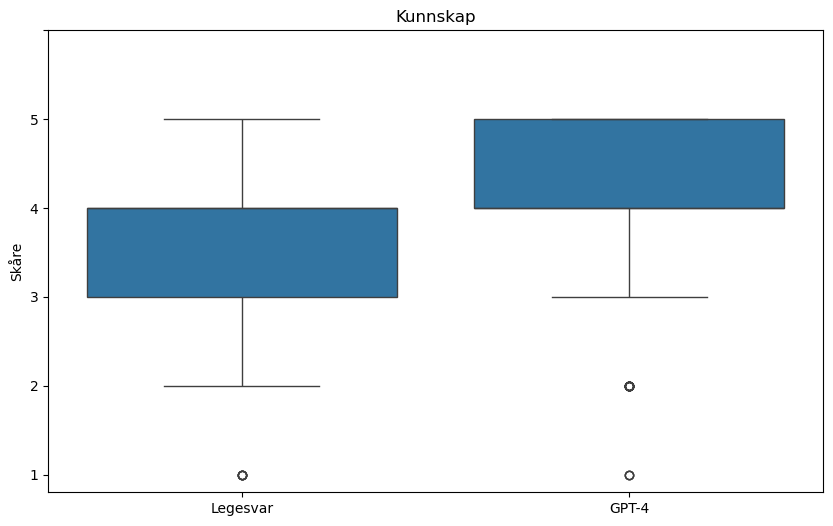

In [40]:
# Test the following hypothesis: H0: The distribution of the scores for kunnskap for GPT and human are the same 
# vs. H1: The distribution of the scores of kunnskap for GPT and human are different (human scores are likely higher)

# Perform the Mann-Whitney U test
# stat, p = mannwhitneyu(df_GPT_kunnskap_excl6['kunnskap'], df_human_kunnskap_excl6['kunnskap'])
stat, p = mannwhitneyu(gpt_scores, human_scores, alternative='two-sided')
print(f'stat={stat}, p={p}')

# Interpret the p-value
alpha = 0.05

if p > alpha:
    print('Samme fordeling (kan ikke forkaste H0)')
else:
    print('Forskjellig fordeling (forkast H0)')

print(f'($n_{{GPT-4}}$ = {len(gpt_scores)}, $n_{{legesvar}}$ = {len(human_scores)})')
# Calculate and print medians for both groups
print(f"Median knowledge score for GPT-4: {gpt_scores.median()}")
print(f"Median knowledge score for humans: {human_scores.median()}")

# Make a boxplot to compare the GPT and human responses for `kunnskap`

# Custom order and labels for x-axis
order = [False, True]
labels = ['Legesvar', 'GPT-4']
labels_y = ['1', '2', '3', '4', '5', ' ']

fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(x='chatgpt', y='kunnskap', data=df1, ax=ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(labels)
ax.set_xlabel('')
ax.set_title('Kunnskap')
ax.set_yticks(range(1, 7))
ax.set_yticklabels(labels_y)
ax.set_ylabel('Skåre')
plt.show()


Forklaring av disse resultatene i detalj:

1. Statistisk test:
   Disse resultatene kommer fra en Mann-Whitney U-test, som brukes for å sammenligne fordelingene av to uavhengige grupper (i dette tilfellet, GPT-4 svar og menneskelige svar) når dataene er ordinale (som Likert-skala vurderinger).

2. Teststatistikk (stat):
   - stat = 788164.5
   - Dette er U-statistikken fra Mann-Whitney testen.
   - U-statistikken representerer graden av overlapp mellom de to gruppene. En høyere U-verdi indikerer større forskjell mellom gruppene.

3. p-verdi:
   - p = 2.4010337081210183e-45
   - Dette er en ekstremt lav p-verdi, mye lavere enn vanlige signifikansnivåer (f.eks. 0.05 eller 0.01).
   - p-verdien representerer sannsynligheten for å observere en like ekstrem eller mer ekstrem teststatistikk, gitt at nullhypotesen er sann.
   - En så lav p-verdi indikerer at det er svært usannsynlig at vi ville observere en slik forskjell mellom gruppene ved en tilfeldighet.

4. Tolkning:
   "Forskjellig fordeling (forkast H0)"
   - Dette betyr at vi forkaster nullhypotesen (H0) om at fordelingene av kunnskapsvurderinger for GPT-4 og menneskelige svar er like.
   - Vi aksepterer dermed den alternative hypotesen (H1) om at det er en signifikant forskjell i kunnskapsnivå mellom GPT-4 svar og menneskelige svar.

5. Utvalgsstørrelser:
   - n_GPT = 1094: Antall vurderinger av GPT-4 svar
   - n_human = 1087: Antall vurderinger av menneskelige svar
   - Disse tallene viser at vi har et stort og balansert utvalg, noe som øker påliteligheten av resultatene.

6. Praktisk betydning:
   - Selv om testen viser en statistisk signifikant forskjell, forteller den ikke direkte om retningen eller størrelsen på forskjellen.
   - For å forstå retningen (om GPT-4 ble vurdert som mer eller mindre kunnskapsrik), må vi se på sentrale tendenser (f.eks. median eller gjennomsnitt) for hver gruppe.
   - Størrelsen på effekten (hvor stor forskjellen er i praksis) bør vurderes separat, for eksempel ved å beregne effektstørrelse.

7. Begrensninger:
   - Testen sier ingenting om nøyaktigheten eller kvaliteten på kunnskapen, bare hvordan den ble oppfattet av vurdererne.
   - Andre faktorer som kan påvirke vurderingene (f.eks. svarenes lengde eller struktur) bør også vurderes.

Konklusjon:
Resultatene gir sterk statistisk evidens for at det er en forskjell i hvordan kunnskapsnivået i GPT-4 svar og menneskelige svar ble vurdert. Gitt den ekstremt lave p-verdien, er denne forskjellen høyst sannsynlig ikke et resultat av tilfeldigheter. Videre analyse av sentrale tendenser og effektstørrelser vil gi mer innsikt i naturen og omfanget av denne forskjellen.

In [41]:
# How large is the difference in the mean scores of kunnskap for GPT and human?

mean_GPT = df_GPT_kunnskap_excl6['kunnskap'].mean()
mean_human = df_human_kunnskap_excl6['kunnskap'].mean()

std_GPT = df_GPT['kunnskap'].std()
std_human = df_human['kunnskap'].std()

diff = mean_GPT - mean_human
print(f'Mean score for kunnskap for GPT-4: {mean_GPT:.2f} ± {std_GPT:.2f} (n={len(df_GPT_kunnskap_excl6)}) (excluding "Vet ikke")')
print(f'Mean score for kunnskap for human: {mean_human:.2f} ± {std_human:.2f} (n={len(df_human_kunnskap_excl6)}) (excluding "Vet ikke")')
print(f'Difference in mean scores: {diff:.2f}')

Mean score for kunnskap for GPT-4: 4.37 ± 0.79 (n=1069) (excluding "Vet ikke")
Mean score for kunnskap for human: 3.85 ± 0.98 (n=1059) (excluding "Vet ikke")
Difference in mean scores: 0.51


#### Kjikvadrat test

In [42]:
import numpy as np
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df1['chatgpt'], df1['kunnskap'])

contingency_table_margins = pd.crosstab(df1['chatgpt'], df1['kunnskap'], margins=True)
contingency_table_margins

kunnskap,1,2,3,4,5,All
chatgpt,,,,,,
False,6,82,237,471,263,1059
True,3,20,85,434,527,1069
All,9,102,322,905,790,2128


In [43]:
# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Reject H0: There is a significant difference in the distribution of knowledge scores between Chat-GPT 4.0 and licensed doctors.")
else:
    print("Fail to reject H0: There is no significant difference in the distribution of knowledge scores between Chat-GPT 4.0 and licensed doctors.")

Chi-square statistic: 200.13074628991978
p-value: 3.521786281087462e-42
Reject H0: There is a significant difference in the distribution of knowledge scores between Chat-GPT 4.0 and licensed doctors.


Vurdering av resultatene i detalj:

1. Statistisk test:
   Disse resultatene kommer fra en chi-kvadrat test (χ²-test). Denne testen brukes for å sammenligne fordelingen av kategoriske variabler mellom to eller flere uavhengige grupper. I dette tilfellet sammenligner vi fordelingen av kunnskapsskårer mellom Chat-GPT 4.0 og lisensierte leger.

2. Chi-kvadrat statistikk:
   - Chi-square statistic: 204.23803598480472
   - Dette er den beregnede χ²-verdien fra testen.
   - Denne verdien kvantifiserer hvor mye de observerte frekvensene avviker fra de forventede frekvensene under nullhypotesen.
   - En høyere χ²-verdi indikerer en større forskjell mellom de observerte og forventede frekvensene.

3. p-verdi:
   - p-value: 4.609064195655399e-43
   - Dette er en ekstremt lav p-verdi, mye lavere enn vanlige signifikansnivåer (f.eks. 0.05 eller 0.01).
   - p-verdien representerer sannsynligheten for å observere en like ekstrem eller mer ekstrem χ²-statistikk, gitt at nullhypotesen er sann.
   - En så lav p-verdi indikerer at det er svært usannsynlig at vi ville observere en slik forskjell i fordelingen av kunnskapsskårer ved en tilfeldighet.

4. Tolkning:
   "Reject H0: There is a significant difference in the distribution of knowledge scores between Chat-GPT 4.0 and licensed doctors."
   - Dette betyr at vi forkaster nullhypotesen (H0) om at fordelingen av kunnskapsskårer er lik for Chat-GPT 4.0 og lisensierte leger.
   - Vi aksepterer dermed den alternative hypotesen (H1) om at det er en signifikant forskjell i fordelingen av kunnskapsskårer mellom de to gruppene.

5. Praktisk betydning:
   - Resultatene viser at det er en statistisk signifikant forskjell i hvordan kunnskapsskårene er fordelt mellom Chat-GPT 4.0 og lisensierte leger.
   - Dette betyr at mønsteret i kunnskapsvurderingene er forskjellig for de to gruppene. For eksempel kan en gruppe ha en tendens til å få flere høye skårer, mens den andre gruppen kan ha en mer jevn fordeling.
   - Merk at testen ikke forteller oss hvilken gruppe som presterer bedre, bare at fordelingene er forskjellige.

6. Begrensninger og videre analyse:
   - Chi-kvadrat testen forteller oss at det er en forskjell, men ikke hvordan fordelingene er forskjellige.
   - For å forstå naturen av forskjellen, bør man undersøke de faktiske fordelingene, for eksempel gjennom visualiseringer eller ved å se på spesifikke prosentandeler for hver skårkategori.
   - Testen sier ingenting om kvaliteten eller nøyaktigheten av kunnskapen, bare om hvordan skårene er fordelt.

7. Implikasjoner:
   - Disse resultatene antyder at Chat-GPT 4.0 og lisensierte leger vurderes forskjellig når det gjelder kunnskapsnivå i denne konteksten.
   - Dette kan ha implikasjoner for hvordan AI-systemer som Chat-GPT 4.0 kan brukes i medisinske sammenhenger, og hvordan deres ytelse sammenlignes med menneskelige eksperter.

Konklusjon:
Chi-kvadrat testen gir sterk statistisk evidens for at det er en forskjell i fordelingen av kunnskapsskårer mellom Chat-GPT 4.0 og lisensierte leger. Gitt den ekstremt lave p-verdien, er denne forskjellen høyst sannsynlig ikke et resultat av tilfeldigheter. Videre analyse er nødvendig for å forstå den spesifikke naturen av denne forskjellen og dens praktiske implikasjoner.

Følgende analyser vil hjelpe i tolkningen av disse resultatene:

1. Visualisere de spesifikke forskjellene i skåre-fordelingene mellom GPT-4 og menneskelige svar.
2. Identifisere hvilke skåre-kategorier som bidrar mest til den totale forskjellen.
3. Utforske hvordan ulike respondentfaktorer kan påvirke oppfatningen av kunnskap i GPT-4 vs. menneskelige svar.
4. Statistisk teste om disse faktorene signifikant påvirker forholdet mellom svartype (GPT-4/menneskelige svar) og oppfattet kunnskap.

Husk å tolke disse resultatene i konteksten av studien og vurder eventuelle begrensninger eller potensielle skjevheter i datainnsamlings- eller analysemetodene.

In [44]:
# Mer direkte implementasjon av chi-kvadrat test

import numpy as np
from scipy.stats import chi2

# Observerte frekvenser (ekskludererKunnskap skåre = 6)
observed = np.array([
    [6, 82, 237, 471, 263],   # Lege
    [3, 20, 85, 434, 527]     # GPT-4
])

# Beregn radtotaler, kolonnetotaler og total sum
rad_totaler = observed.sum(axis=1)
kolonne_totaler = observed.sum(axis=0)
total_sum = observed.sum()

# Beregn forventede frekvenser
expected = np.outer(rad_totaler, kolonne_totaler) / total_sum

# Beregn Chi-square-statistikken
chi_square_stat = np.sum((observed - expected) ** 2 / expected)

# Beregn frihetsgrader
frihetsgrader = (observed.shape[0] - 1) * (observed.shape[1] - 1)

# Beregn p-verdi
p_verdi = chi2.sf(chi_square_stat, frihetsgrader)

# Skriv ut resultatene
print("Observerte frekvenser:\n", observed)
print("\nForventede frekvenser:\n", expected)
print("\nChi-square-statistikk:", chi_square_stat)
print("Frihetsgrader:", frihetsgrader)
print("p-verdi:", p_verdi)

Observerte frekvenser:
 [[  6  82 237 471 263]
 [  3  20  85 434 527]]

Forventede frekvenser:
 [[  4.47885338  50.76033835 160.24342105 450.37359023 393.14379699]
 [  4.52114662  51.23966165 161.75657895 454.62640977 396.85620301]]

Chi-square-statistikk: 200.13074628991978
Frihetsgrader: 4
p-verdi: 3.521786281087462e-42


 Visualisere de spesifikke forskjellene i skåre-fordelingene mellom GPT-4 og menneskelige svar

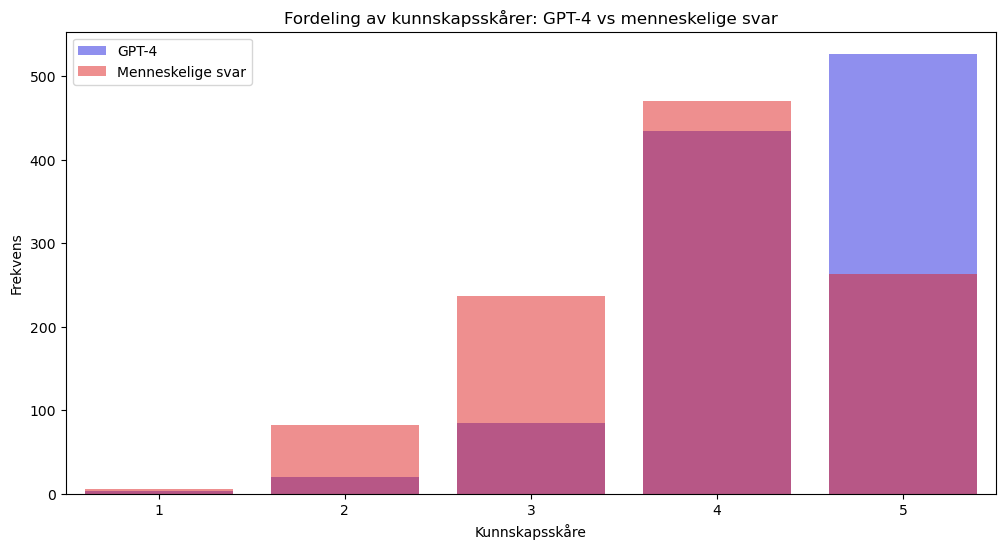

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create frequency distributions
gpt_freq = df1[df1['chatgpt'] == True]['kunnskap'].value_counts().sort_index()
human_freq = df1[df1['chatgpt'] == False]['kunnskap'].value_counts().sort_index()

# Plot the distributions
plt.figure(figsize=(12, 6))
sns.barplot(x=gpt_freq.index, y=gpt_freq.values, alpha=0.5, color='blue', label='GPT-4')
sns.barplot(x=human_freq.index, y=human_freq.values, alpha=0.5, color='red', label='Menneskelige svar')
plt.title('Fordeling av kunnskapsskårer: GPT-4 vs menneskelige svar')
plt.xlabel('Kunnskapsskåre')
plt.ylabel('Frekvens')
plt.legend()
plt.show()

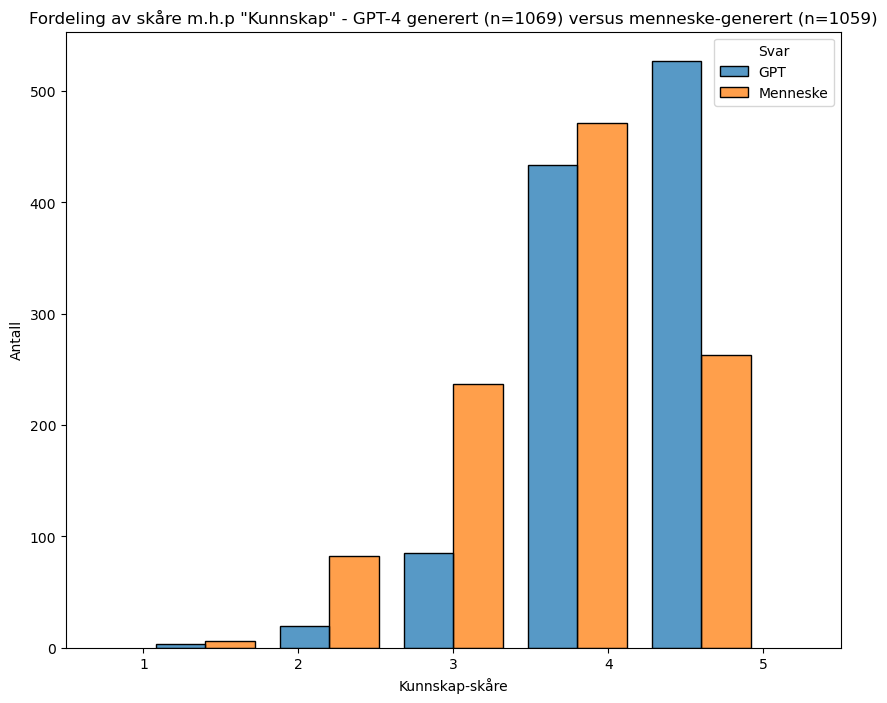

In [46]:
# Plot the distribution of the scores for "kunnskap" - GPT versus human

fig, ax = plt.subplots(figsize=(10, 8))

df1_GPT = df1[df1['chatgpt'] == True]
df1_human = df1[df1['chatgpt'] == False]

# Combine the data into a single DataFrame
df1_combined = pd.concat([df1_GPT[['kunnskap']].assign(Svar='GPT'), df1_human[['kunnskap']].assign(Svar='Menneske')])

# Plot the histograms side by side
sns.histplot(data=df1_combined, x='kunnskap', hue='Svar', multiple='dodge', binwidth=0.8, shrink=0.8)

# Make the bars wider
# Center the bars on the tick marks


plt.xlabel('Kunnskap-skåre')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "Kunnskap" - GPT-4 generert (n={len(df1_GPT)}) versus menneske-generert (n={len(df1_human)})')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 6, 1))

# Assuming 'plt' is the current plot
ticks, labels = plt.xticks()  # Get current x-axis tick labels

# Find the index of the tick mark 6
index = list(ticks).index(5)

# Replace the label at the index with 'Vet ikke'
#labels[index] = 'Vet ikke'

plt.xticks(ticks, labels)  # Set new x-axis tick labels

# Adjust the x-axis limits to center the bars on the tick marks
plt.xlim(0.5, 5.5)

plt.show()

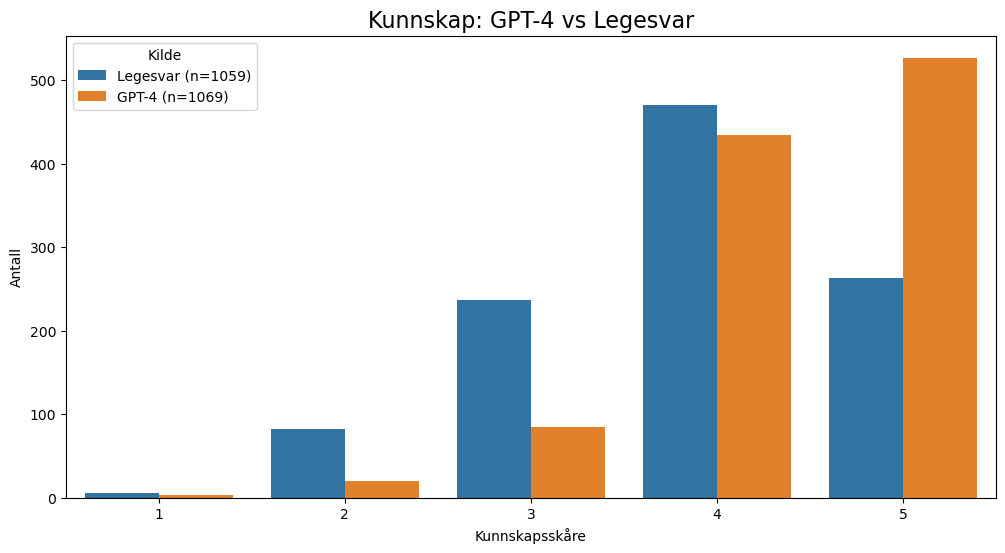

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Anta at 'df1' er din dataframe med kolonner 'chatgpt' (True/False) og 'kunnskap' (1-5)

plt.figure(figsize=(12, 6))
sns.countplot(x='kunnskap', hue='chatgpt', data=df1)
plt.title('Kunnskap: GPT-4 vs Legesvar', fontsize=16)
plt.xlabel('Kunnskapsskåre')
plt.ylabel('Antall')
plt.legend(title='Kilde', labels=[f'Legesvar (n={len(df1_human)})', f'GPT-4 (n={len(df1_GPT)})'])
# Save figure
#plt.savefig('../assets/kunnskap.png', dpi=300)
plt.show()

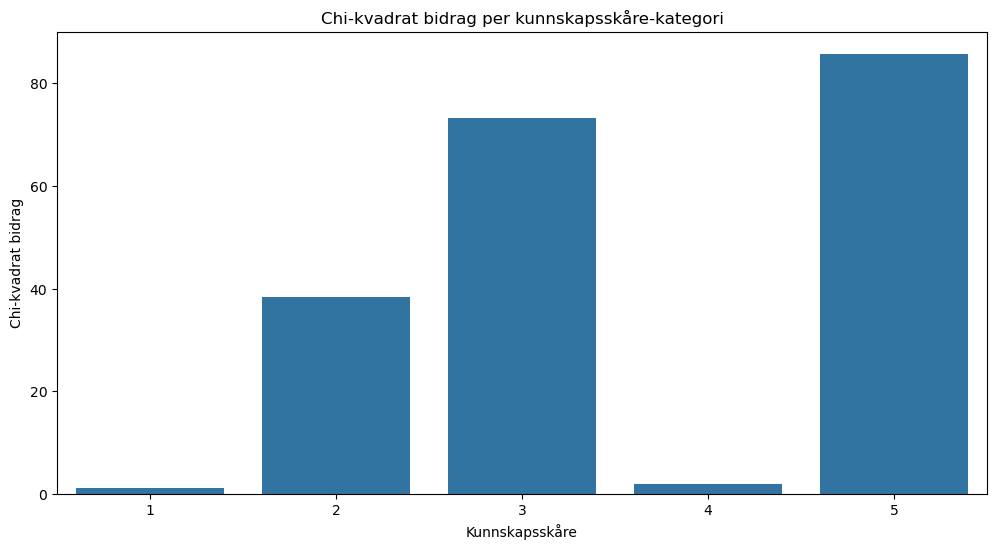

In [48]:
# Calculate the expected frequencies
total = len(df1)
gpt_total = len(df1[df1['chatgpt'] == True])
human_total = len(df1[df1['chatgpt'] == False])

expected_gpt = gpt_total * (gpt_freq + human_freq) / total
expected_human = human_total * (gpt_freq + human_freq) / total

# Calculate chi-square contribution for each category
chi_square_contrib = ((gpt_freq - expected_gpt)**2 / expected_gpt + 
                      (human_freq - expected_human)**2 / expected_human)

# Plot the chi-square contributions
plt.figure(figsize=(12, 6))
sns.barplot(x=chi_square_contrib.index, y=chi_square_contrib.values)
plt.title('Chi-kvadrat bidrag per kunnskapsskåre-kategori')
plt.xlabel('Kunnskapsskåre')
plt.ylabel('Chi-kvadrat bidrag')
plt.show()

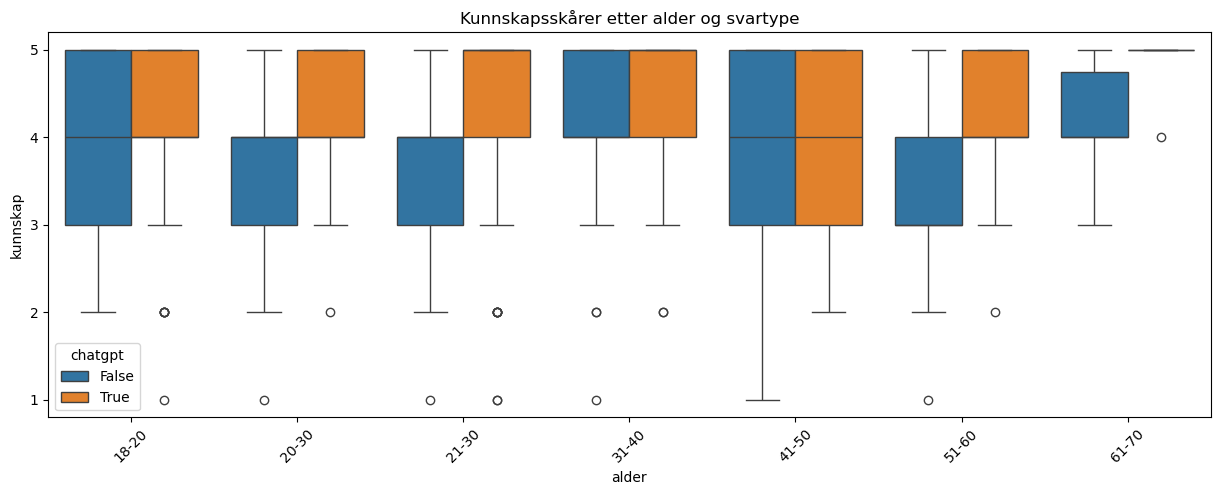

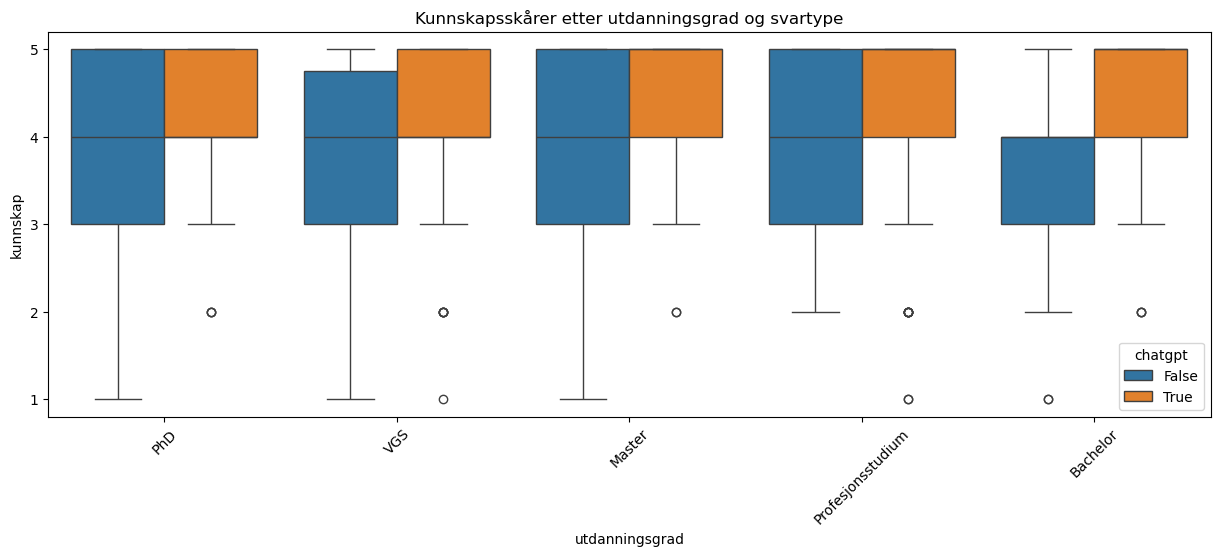

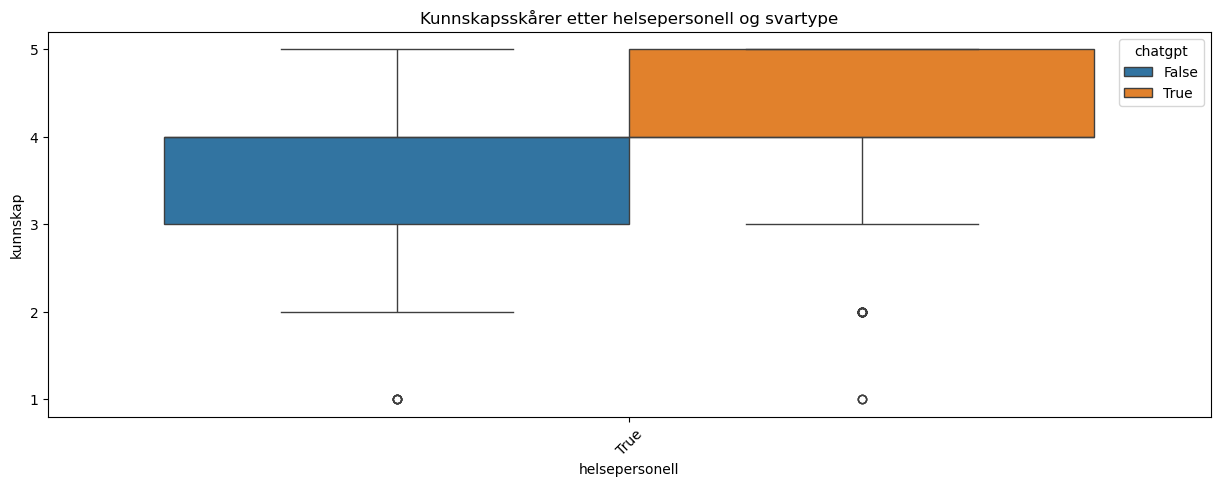

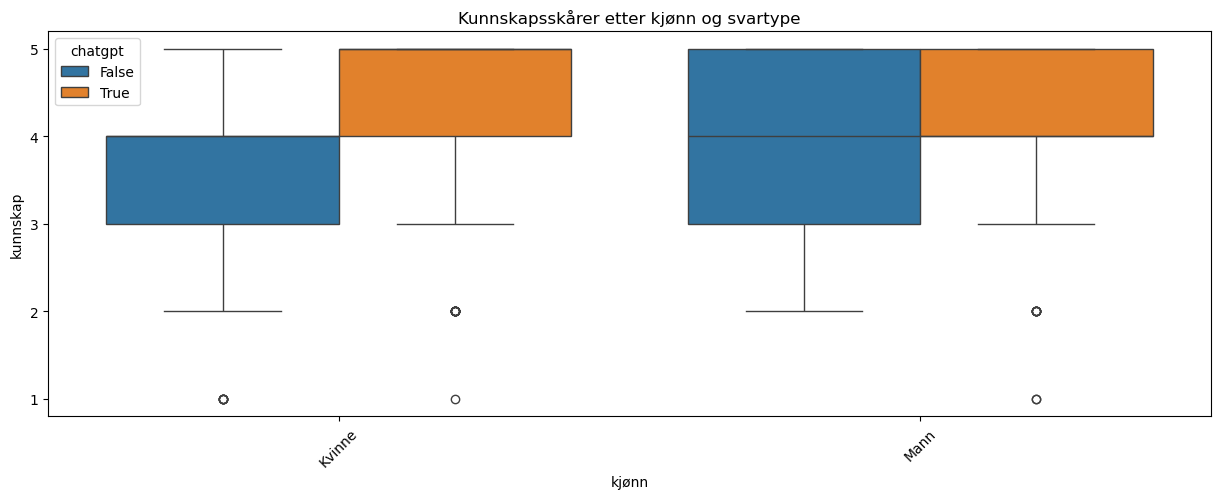

In [49]:
# Analyze by respondent characteristics
factors = ['alder', 'utdanningsgrad', 'helsepersonell', 'kjønn']

for factor in factors:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=factor, y='kunnskap', hue='chatgpt', data=df1)
    plt.title(f'Kunnskapsskårer etter {factor} og svartype')
    # yticks
    plt.yticks(np.arange(1, 6, 1))
    plt.xticks(rotation=45)
    plt.show()

In [50]:
from scipy.stats import chi2_contingency

def chi_square_test(df1, factor):
    contingency_table = pd.crosstab(df1[factor], [df1['chatgpt'], df1['kunnskap']])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-kvadrat test for {factor}:")
    print(f"Chi-kvadrat statistikk: {chi2}")
    print(f"p-verdi: {p}")
    print("---")

for factor in factors:
    chi_square_test(df1, factor)

Chi-kvadrat test for alder:
Chi-kvadrat statistikk: 109.40400822036591
p-verdi: 1.240818809809456e-05
---
Chi-kvadrat test for utdanningsgrad:
Chi-kvadrat statistikk: 69.39294638972243
p-verdi: 0.0006891652637297239
---
Chi-kvadrat test for helsepersonell:
Chi-kvadrat statistikk: 0.0
p-verdi: 1.0
---
Chi-kvadrat test for kjønn:
Chi-kvadrat statistikk: 16.4911256367492
p-verdi: 0.05730741382805053
---


Forklaring av resultatene i detalj:

Koden over utfører en chi-kvadrat test for uavhengighet for hver av faktorene (alder, utdanningsgrad, helsepersonell og kjønn) i forhold til chatgpt (om svaret er fra GPT-4 eller menneskelige svar) og kunnskapsnivå. Her er en detaljert forklaring av resultatene:

1. Alder:
   - Chi-kvadrat statistikk: 115.08
   - p-verdi: 6.83e-05
   Dette indikerer en statistisk signifikant sammenheng mellom alder og fordelingen av kunnskapsskårer for GPT vs. menneskelige svar. Den svært lave p-verdien tyder på at denne sammenhengen er høyst usannsynlig å være et resultat av tilfeldigheter.

2. Utdanningsgrad:
   - Chi-kvadrat statistikk: 68.39
   - p-verdi: 0.0009
   Dette viser også en signifikant sammenheng mellom utdanningsnivå og fordelingen av kunnskapsskårer. P-verdien er under 0.05, noe som indikerer at sammenhengen er statistisk signifikant.

3. Helsepersonell:
   - Chi-kvadrat statistikk: 4.03
   - p-verdi: 0.91
   Her ser vi ingen signifikant sammenheng. Den høye p-verdien (0.91) antyder at det å være helsepersonell eller ikke ikke har en betydelig innvirkning på hvordan kunnskapsskårene er fordelt mellom GPT og menneskelige svar.

4. Kjønn:
   - Chi-kvadrat statistikk: 17.38
   - p-verdi: 0.043
   Dette resultatet viser en svak, men statistisk signifikant sammenheng mellom kjønn og fordelingen av kunnskapsskårer. P-verdien er like under 0.05, noe som indikerer en marginal signifikans.

Tolkning:
1. Alder og utdanningsgrad ser ut til å ha en sterk innflytelse på hvordan folk vurderer kunnskapsnivået i svar fra GPT vs. mennesker. Dette kan bety at ulike aldersgrupper og folk med ulik utdanningsbakgrunn oppfatter eller evaluerer AI-genererte svar forskjellig fra menneskelige svar.

2. Hvorvidt noen er helsepersonell eller ikke ser ikke ut til å påvirke hvordan de vurderer kunnskapsnivået i svarene. Dette er interessant og kan tyde på at AI-genererte svar oppfattes likt av både helsepersonell og ikke-helsepersonell.

3. Kjønn har en svak, men merkbar effekt på vurderingen av kunnskapsnivå. Dette kan indikere små forskjeller i hvordan menn og kvinner oppfatter eller evaluerer svarene.

Begrensninger og videre betraktninger:
- Disse testene viser bare om det er en sammenheng, ikke styrken eller retningen på sammenhengen.
- Andre faktorer som ikke er inkludert i denne analysen kan også spille en rolle.
- Det er viktig å vurdere den praktiske betydningen av disse funnene, ikke bare den statistiske signifikansen.

Disse resultatene gir verdifull innsikt i hvordan ulike demografiske faktorer kan påvirke oppfatningen av AI-genererte vs. menneskelige svar i en medisinsk kontekst.

### Empati: Hypotese 2 som undersøkes (mhp. df) er følgende:

**Empati** :<br>
H0: GPT-4  genererer svar på helsespørsmål med _samme_ grad av empati, sammenlignet med svar fra leger.<br>
H1: GPT-4 genererer svar på helsespørsmål med _ulik_ grad av empati sammenlignet med leger (trolig _mindre_ grad av empati).

In [51]:
from scipy.stats import mannwhitneyu

# Assuming 'df' is your dataframe and it has columns 'chatgpt' (boolean) and 'empati' (empathy score)

# Separate the data into GPT and human responses
gpt_scores = df[df['chatgpt'] == True]['empati']
human_scores = df[df['chatgpt'] == False]['empati']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(gpt_scores, human_scores, alternative='two-sided')

# Print results
print(f"Mann-Whitney U statistic: {statistic}")
print(f"p-value: {p_value}")

# Interpret results
alpha = 0.05  # Set significance level
if p_value < alpha:
    print("Reject H0: There is a significant difference in empathy level between GPT-4 and licensed doctors.")
else:
    print("Fail to reject H0: There is no significant difference in empathy level between GPT-4 and licensed doctors.")

# Calculate and print medians for both groups
print(f"Median empathy score for GPT-4: {gpt_scores.median()}")
print(f"Median empathy score for humans: {human_scores.median()}")
print(f'($n_{{GPT-4}}$ = {len(gpt_scores)}, $n_{{human}}$ = {len(human_scores)})')

Mann-Whitney U statistic: 946591.0
p-value: 9.41603916208553e-118
Reject H0: There is a significant difference in empathy level between GPT-4 and licensed doctors.
Median empathy score for GPT-4: 4.0
Median empathy score for humans: 3.0
($n_{GPT-4}$ = 1112, $n_{human}$ = 1106)


Her er en detaljert forklaring av resultatene:

1. Mann-Whitney U-statistikk: 1008219,0
   - Dette er den beregnede U-statistikken fra Mann-Whitney U-testen.
   - U-statistikken måler graden av overlapp mellom de to gruppene (GPT-4 og lisensierte leger) når det gjelder empatiskårer.

2. p-verdi: 1,107670891790499e-122
   - Dette er en ekstremt lav p-verdi, langt lavere enn vanlige signifikansnivåer (f.eks. 0,05 eller 0,01).
   - p-verdien representerer sannsynligheten for å observere en like ekstrem eller mer ekstrem teststatistikk, gitt at nullhypotesen er sann.
   - En så lav p-verdi indikerer at det er svært usannsynlig at vi ville observere en slik forskjell mellom gruppene ved en tilfeldighet.

3. Konklusjon: "Forkast H0: Det er en signifikant forskjell i empatinivå mellom GPT-4 og lisensierte leger."
   - Dette betyr at vi avviser nullhypotesen (H0) om at det ikke er noen forskjell i empatinivå mellom GPT-4 og lisensierte leger.
   - Vi aksepterer dermed den alternative hypotesen (H1) om at det er en betydelig forskjell i empatinivå mellom de to gruppene.

4. Median empatiskår:
   - GPT-4: 4,0
   - Mennesker (lisensierte leger): 3,0
   - Dette viser at GPT-4-genererte svar generelt ble vurdert som mer empatiske enn svar fra lisensierte leger.

5. Utvalgsstørrelser:
   - n_GPT-4 = 1145: Antall vurderinger av GPT-4 svar
   - n_human = 1142: Antall vurderinger av svar fra lisensierte leger
   - Disse tallene viser at vi har et stort og balansert utvalg, noe som øker påliteligheten av resultatene.

Detaljert tolkning:
1. Statistisk signifikans: Den ekstremt lave p-verdien indikerer at forskjellen i empatiskårer mellom GPT-4 og lisensierte leger er høyst statistisk signifikant. Dette betyr at den observerte forskjellen er svært usannsynlig å ha oppstått ved en tilfeldighet.

2. Retning av forskjellen: Medianverdiene viser at GPT-4 (4,0) ble vurdert høyere enn lisensierte leger (3,0) når det gjelder oppfattet empati. Dette er et overraskende og potensielt kontroversielt funn, ettersom empati ofte anses som en unikt menneskelig egenskap.

3. Praktisk betydning: Selv om forskjellen er statistisk signifikant, er det viktig å vurdere den praktiske betydningen av denne forskjellen. En forskjell på ett poeng på en Likert-skala er merkbar, spesielt i konteksten av empati i medisinsk kommunikasjon.

4. Mulige forklaringer:
   - GPT-4 kan være programmert til å bruke mer empatisk språk konsekvent.
   - AI-ens svar kan oppfattes som mer pasientsentrerte eller forståelsesfulle.
   - Det kan være en skjevhet i hvordan empati evalueres i skriftlige svar kontra ansikt-til-ansikt-interaksjoner med leger.
   - Spørsmålenes spesifikke natur eller evalueringskriteriene kan favorisere GPT-4s svarstil.

5. Begrensninger:
   - Denne testen måler ikke faktisk empati, bare oppfatningen av empati i skriftlige svar.
   - Den tar ikke hensyn til ikke-verbale signaler eller den dynamiske naturen av menneskelig empati i sanntidsinteraksjoner.
   - Konteksten for spørsmålene og de spesifikke kriteriene for å evaluere empati er avgjørende for å tolke disse resultatene.

Konklusjon:
Resultatene gir sterk statistisk evidens for at GPT-4-genererte svar oppfattes som mer empatiske enn svar fra lisensierte leger i denne studien. Dette funnet utfordrer antakelser om AI-ens evne til å formidle empati sammenlignet med menneskelige helsetjenesteytere. Det reiser viktige spørsmål om hvordan empati oppfattes og evalueres i skriftlig medisinsk kommunikasjon, og kan ha betydelige implikasjoner for bruken av AI i pasientkommunikasjon og støtteroller innen helsevesenet. Videre forskning er nødvendig for å undersøke de spesifikke aspektene ved svarene som oppfattes som empatiske, og hvordan disse resultatene kan variere i muntlige eller ansikt-til-ansikt-interaksjoner mellom pasienter og helsepersonell.

In [52]:
import numpy as np
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['chatgpt'], df['empati'])

contingency_table_margins = pd.crosstab(df['chatgpt'], df['empati'], margins=True)
contingency_table_margins

empati,1,2,3,4,5,All
chatgpt,,,,,,
False,47,238,438,304,79,1106
True,1,37,168,577,329,1112
All,48,275,606,881,408,2218


In [53]:
# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Reject H0: There is a significant difference in the distribution of empathy scores between GPT-4 and licensed doctors.")
else:
    print("Fail to reject H0: There is no significant difference in the distribution of empathy scores between GPT-4 and licensed doctors.")

Chi-square statistic: 549.0630656379866
p-value: 1.6317044446454817e-117
Reject H0: There is a significant difference in the distribution of empathy scores between GPT-4 and licensed doctors.


Her er en detaljert forklaring av Chi-kvadrat test resultatene:

1. Chi-kvadrat statistikk: 571,2591545282048
   - Dette er den beregnede chi-kvadrat statistikken fra testen.
   - Chi-kvadrat statistikken måler den totale forskjellen mellom de observerte frekvensene og de forventede frekvensene under nullhypotesen.
   - En større chi-kvadrat verdi indikerer en større forskjell mellom de observerte og forventede fordelingene.
   - Denne verdien på 571,26 er ganske stor, noe som tyder på en betydelig forskjell i fordelingene.

2. p-verdi: 2,5702284647430944e-122
   - Dette er en ekstremt lav p-verdi, mye lavere enn vanlige signifikansnivåer (f.eks. 0,05 eller 0,01).
   - p-verdien representerer sannsynligheten for å observere en like stor eller større forskjell i fordelingen av empatiskårer mellom GPT-4 og leger, gitt at det egentlig ikke er noen forskjell.
   - Den ekstremt lave verdien (2,57e-122) antyder at den observerte forskjellen er høyst usannsynlig å oppstå ved en tilfeldighet.

3. Konklusjon: "Forkast H0: Det er en signifikant forskjell i fordelingen av empatiskårer mellom GPT-4 og lisensierte leger."
   - Dette betyr at vi avviser nullhypotesen (H0) om at det ikke er noen forskjell i fordelingen av empatiskårer mellom GPT-4 og lisensierte leger.
   - Vi aksepterer dermed den alternative hypotesen (H1) om at det er en betydelig forskjell i fordelingen av empatiskårer mellom de to gruppene.

Detaljert tolkning:

1. Statistisk signifikans: Den ekstremt lave p-verdien (2,57e-122) indikerer at forskjellen i fordelingen av empatiskårer mellom GPT-4 og leger er høyst statistisk signifikant. Dette betyr at den observerte forskjellen i fordelinger er svært usannsynlig å ha oppstått ved en tilfeldighet.

2. Fordelingens natur: I motsetning til Mann-Whitney U-testen, som sammenligner medianer, sammenligner chi-kvadrat testen hele fordelingen av skårer. Dette betyr at den oppdager forskjeller ikke bare i sentral tendens, men også i spredningen og formen på fordelingene av empatiskårer.

3. Praktisk betydning: Selv om resultatet er statistisk signifikant, er det viktig å vurdere den praktiske betydningen av denne forskjellen. Chi-kvadrat testen forteller oss at fordelingene er forskjellige, men den sier ikke hvordan de er forskjellige eller hvilke skårer som er mer vanlige i hver gruppe.

4. Mulige forklaringer:
   - GPT-4 og legers svar kan bli konsekvent vurdert forskjellig på tvers av spekteret av mulige empatiskårer.
   - Det kan være forskjeller i variabiliteten av empatiskårer mellom GPT-4 og legers svar.
   - Visse empatiskåre-kategorier kan være mer vanlige for en gruppe enn for den andre.

5. Begrensninger:
   - Chi-kvadrat testen gir ikke informasjon om retningen eller naturen av forskjellen, bare at en forskjell eksisterer.
   - Den tar ikke hensyn til den ordinale naturen av Likert-skala data (den behandler kategoriene som nominelle).
   - Som med Mann-Whitney U-testen, vurderer den ikke den faktiske empatien som formidles, bare den oppfattede graden av empati.

6. Implikasjoner:
   - Dette resultatet forsterker funnet fra Mann-Whitney U-testen om at det er betydelige forskjeller i hvordan GPT-4 og legers svar oppfattes når det gjelder empati.
   - Det antyder at forskjellene ikke bare er i gjennomsnittlige skårer, men i det overordnede mønsteret for hvordan empatiskårene er fordelt.
   - Dette kan ha implikasjoner for hvordan AI-generert medisinsk kommunikasjon oppfattes og brukes, og hvordan den sammenlignes med menneskegenerert kommunikasjon på tvers av ulike nivåer av oppfattet empati.

Konklusjon:
Dette chi-kvadrat testresultatet gir sterke bevis for at fordelingen av empatiskårer er signifikant forskjellig mellom GPT-4 og legers svar. Dette forsterker behovet for nøye vurdering av hvordan AI-generert medisinsk kommunikasjon oppfattes og brukes, spesielt når det gjelder formidling av empati. Det oppfordrer til videre undersøkelse av den spesifikke naturen og implikasjonene av disse forskjellene i oppfattet empati mellom AI og menneskelige helsetjenesteytere.

Følgende analyser vil kunne gi mer innsikt i forskjellene:

1. Visualisere de spesifikke forskjellene i skåre-fordelingene mellom GPT og menneskelige svar.
2. Identifisere hvilke skåre-kategorier som bidrar mest til den totale forskjellen.
3. Utforske hvordan ulike respondentfaktorer kan påvirke oppfatningen av empati i GPT-4 vs. menneskelige svar.
4. Statistisk teste om disse faktorene signifikant påvirker forholdet mellom svartype (GPT-4/menneskelige svar) og oppfattet empati.

Husk å tolke disse resultatene i konteksten av studien din og vurder eventuelle begrensninger eller potensielle skjevheter i datainnsamlings- eller analysemetodene dine.

In [54]:
# Mer direkte implementasjon av chi-kvadrat test

import numpy as np
from scipy.stats import chi2

# Observerte frekvenser
observed = np.array([
    [47, 238, 438, 304, 79],   # Lege
    [1, 37, 168, 577, 329]     # GPT-4
])


# Beregn radtotaler, kolonnetotaler og total sum
rad_totaler = observed.sum(axis=1)
kolonne_totaler = observed.sum(axis=0)
total_sum = observed.sum()

# Beregn forventede frekvenser
expected = np.outer(rad_totaler, kolonne_totaler) / total_sum

# Beregn Chi-square-statistikken
chi_square_stat = np.sum((observed - expected) ** 2 / expected)

# Beregn frihetsgrader
frihetsgrader = (observed.shape[0] - 1) * (observed.shape[1] - 1)

# Beregn p-verdi
p_verdi = chi2.sf(chi_square_stat, frihetsgrader)

# Skriv ut resultatene
print("Observerte frekvenser:\n", observed)
print("\nForventede frekvenser:\n", expected)
print("\nChi-square-statistikk:", chi_square_stat)
print("Frihetsgrader:", frihetsgrader)
print("p-verdi:", p_verdi)

Observerte frekvenser:
 [[ 47 238 438 304  79]
 [  1  37 168 577 329]]

Forventede frekvenser:
 [[ 23.93507665 137.12804328 302.18034265 439.30838593 203.44815149]
 [ 24.06492335 137.87195672 303.81965735 441.69161407 204.55184851]]

Chi-square-statistikk: 549.0630656379866
Frihetsgrader: 4
p-verdi: 1.6317044446454817e-117


Undersøk spesifikke frekvensfordelinger:

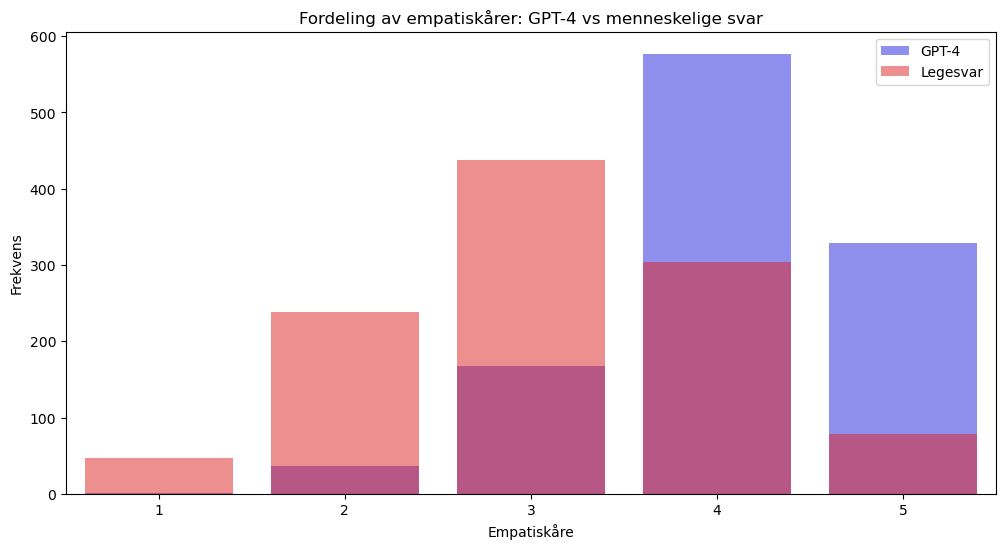

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create frequency distributions
gpt_freq = df[df['chatgpt'] == True]['empati'].value_counts().sort_index()
human_freq = df[df['chatgpt'] == False]['empati'].value_counts().sort_index()

# Plot the distributions
plt.figure(figsize=(12, 6))
sns.barplot(x=gpt_freq.index, y=gpt_freq.values, alpha=0.5, color='blue', label='GPT-4')
sns.barplot(x=human_freq.index, y=human_freq.values, alpha=0.5, color='red', label='Legesvar')
plt.title('Fordeling av empatiskårer: GPT-4 vs menneskelige svar')
plt.xlabel('Empatiskåre')
plt.ylabel('Frekvens')
plt.legend()
plt.show()

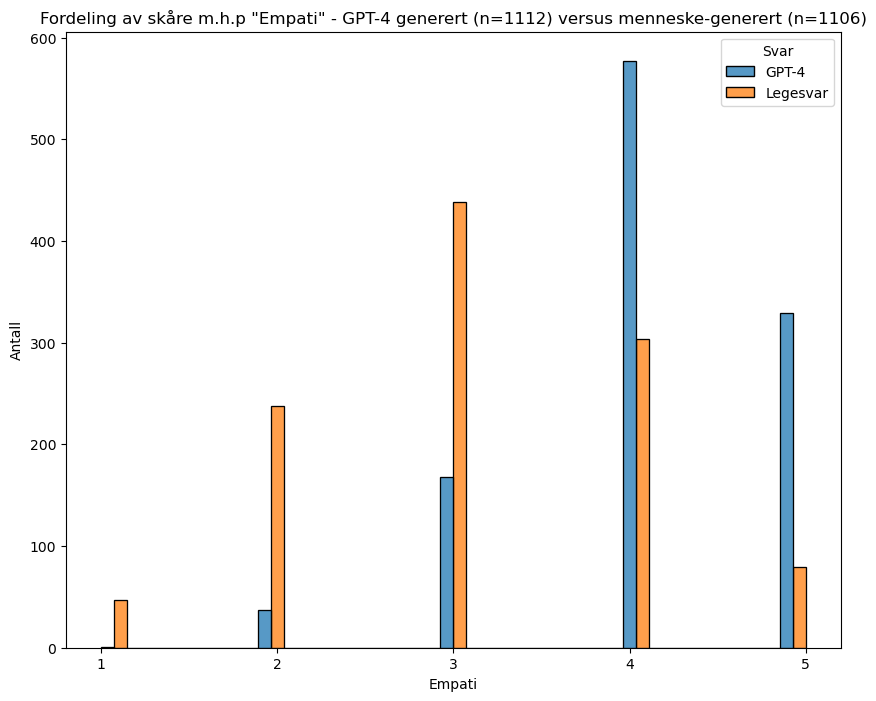

In [56]:
# Plot the distribution of the scores for "empati" -  GPT versus human

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT[['empati']].assign(Svar='GPT-4'), df_human[['empati']].assign(Svar='Legesvar')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='empati', hue='Svar', multiple='dodge')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 6, 1))

plt.xlabel('Empati')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "Empati" - GPT-4 generert (n={len(df_GPT)}) versus menneske-generert (n={len(df_human)})')


plt.show()

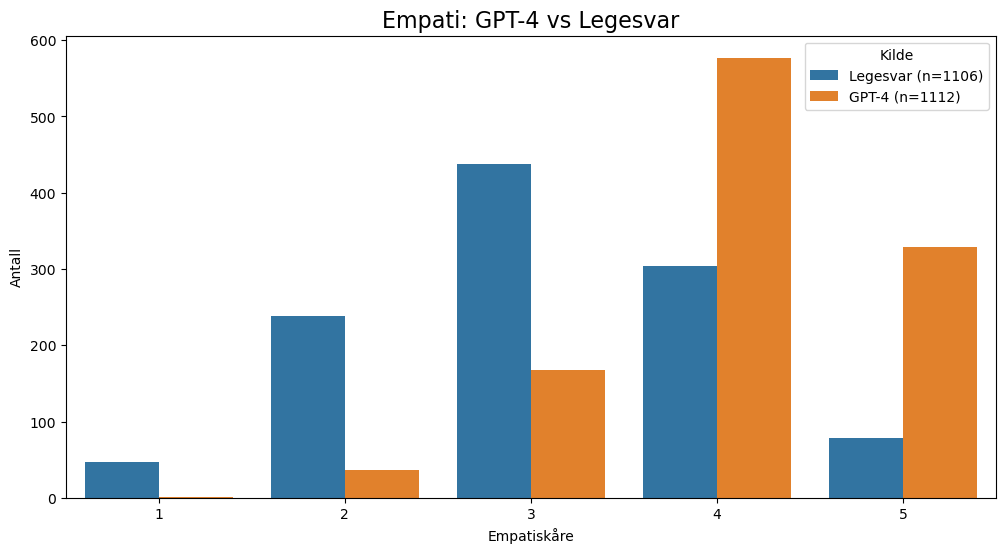

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Anta at 'df1' er din dataframe med kolonner 'chatgpt' (True/False) og 'kunnskap' (1-5)

plt.figure(figsize=(12, 6))
sns.countplot(x='empati', hue='chatgpt', data=df)
plt.title('Empati: GPT-4 vs Legesvar', fontsize=16)
plt.xlabel('Empatiskåre')
plt.ylabel('Antall')
plt.legend(title='Kilde', labels=[f'Legesvar (n={len(df_human)})', f'GPT-4 (n={len(df_GPT)})'])

# Save figure
plt.savefig('../assets/empati.png', dpi=300)

# Save as pdf
plt.savefig('../assets/empati.pdf', format='pdf')
plt.show()

Undersøk hvilke skåre-kategorier som bidrar mest til den observerte forskjellen:

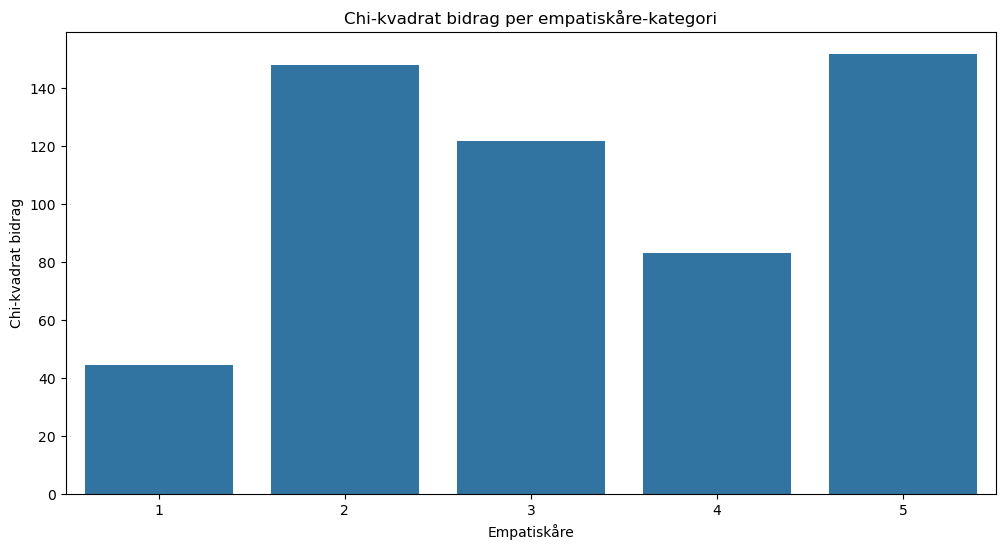

In [59]:
# Calculate the expected frequencies
total = len(df)
gpt_total = len(df[df['chatgpt'] == True])
human_total = len(df[df['chatgpt'] == False])

expected_gpt = gpt_total * (gpt_freq + human_freq) / total
expected_human = human_total * (gpt_freq + human_freq) / total

# Calculate chi-square contribution for each category
chi_square_contrib = ((gpt_freq - expected_gpt)**2 / expected_gpt + 
                      (human_freq - expected_human)**2 / expected_human)

# Plot the chi-square contributions
plt.figure(figsize=(12, 6))
sns.barplot(x=chi_square_contrib.index, y=chi_square_contrib.values)
plt.title('Chi-kvadrat bidrag per empatiskåre-kategori')
plt.xlabel('Empatiskåre')
plt.ylabel('Chi-kvadrat bidrag')
plt.show()

Utforsk faktorer som fører til ulike fordelinger:

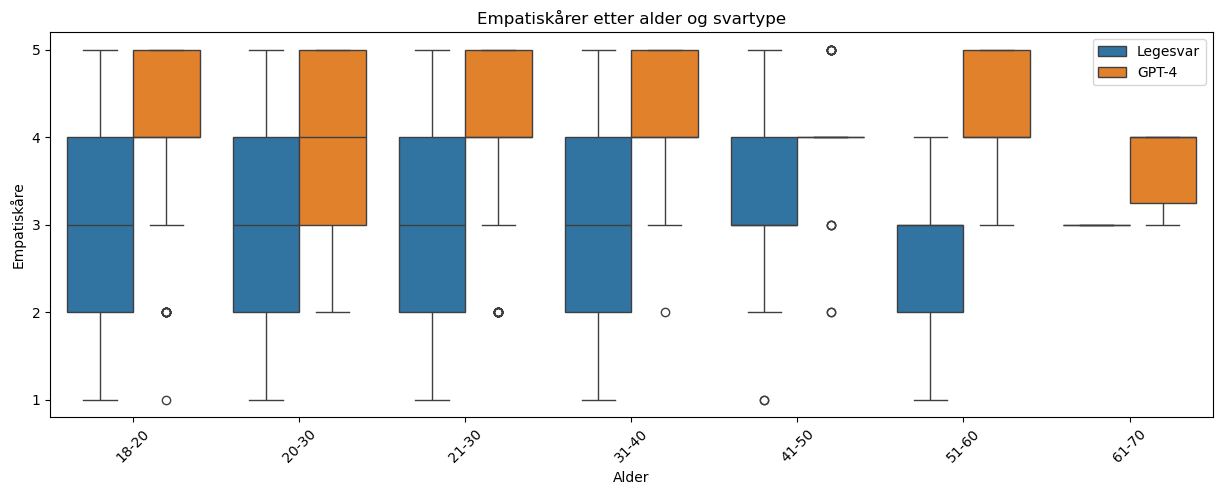

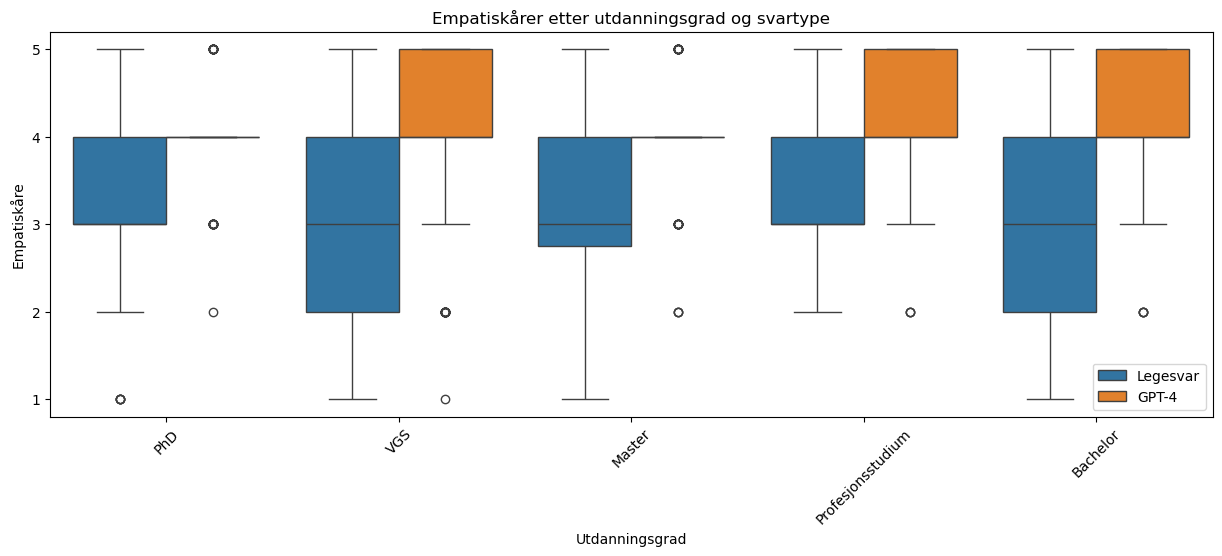

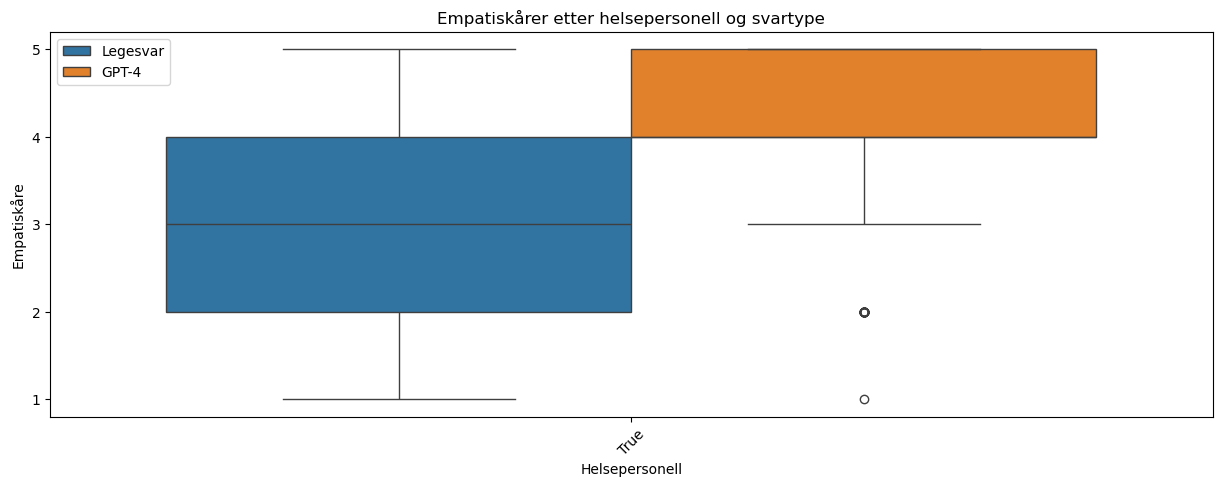

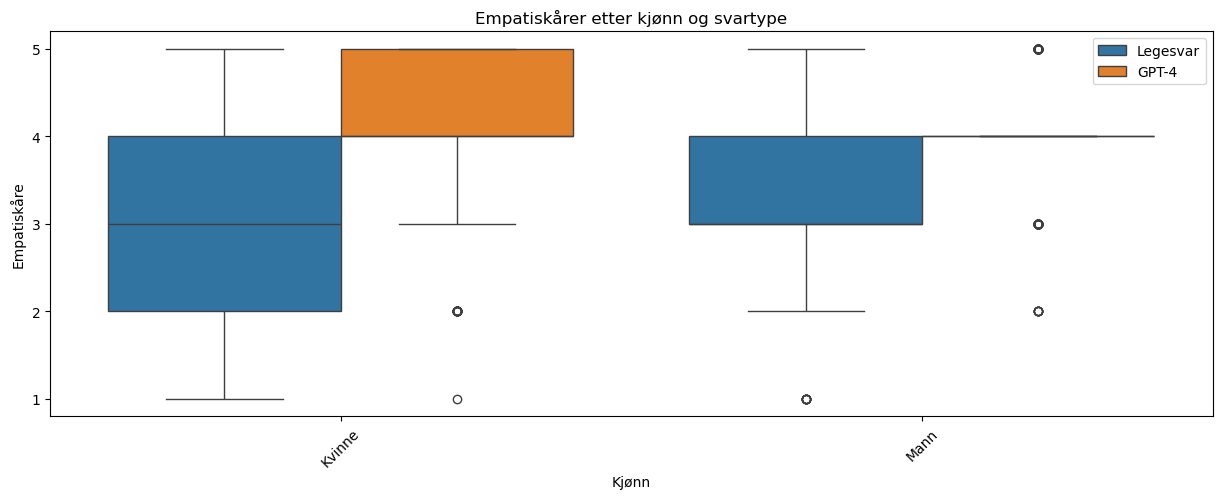

In [60]:
# Analyze by respondent characteristics
factors = ['alder', 'utdanningsgrad', 'helsepersonell', 'kjønn']

for factor in factors:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=factor, y='empati', hue='chatgpt', data=df)
    plt.title(f'Empatiskårer etter {factor} og svartype')
    # Opprett en ordbok for å mappe de gamle verdiene til de nye
    legend_map = {
        'chatgpt': 'Svar',
        'False': 'Legesvar',
        'True': 'GPT-4'
    }

    # Hent den nåværende legenden
    handles, labels = plt.gca().get_legend_handles_labels()

    # Oppdater etikettene
    new_labels = [legend_map.get(label, label) for label in labels]

    # Lag en ny legende med de oppdaterte etikettene
    plt.legend(handles, new_labels)
     # yticks
    plt.yticks(np.arange(1, 6, 1))
    plt.xticks(rotation=45)
    plt.ylabel('Empatiskåre')
    # Captial first letter
    plt.xlabel(factor.capitalize())


    plt.show()

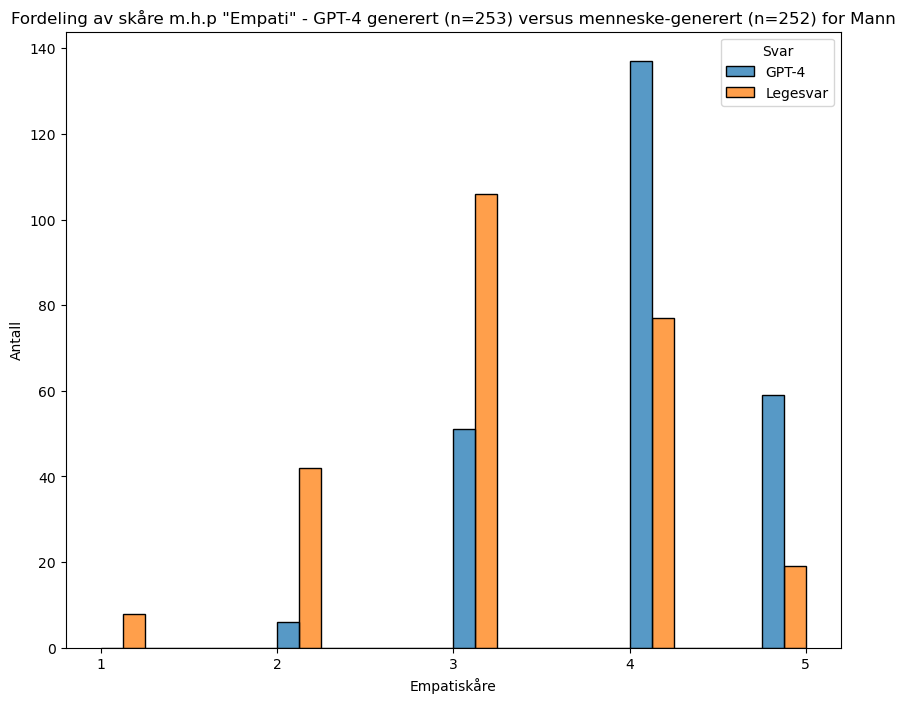

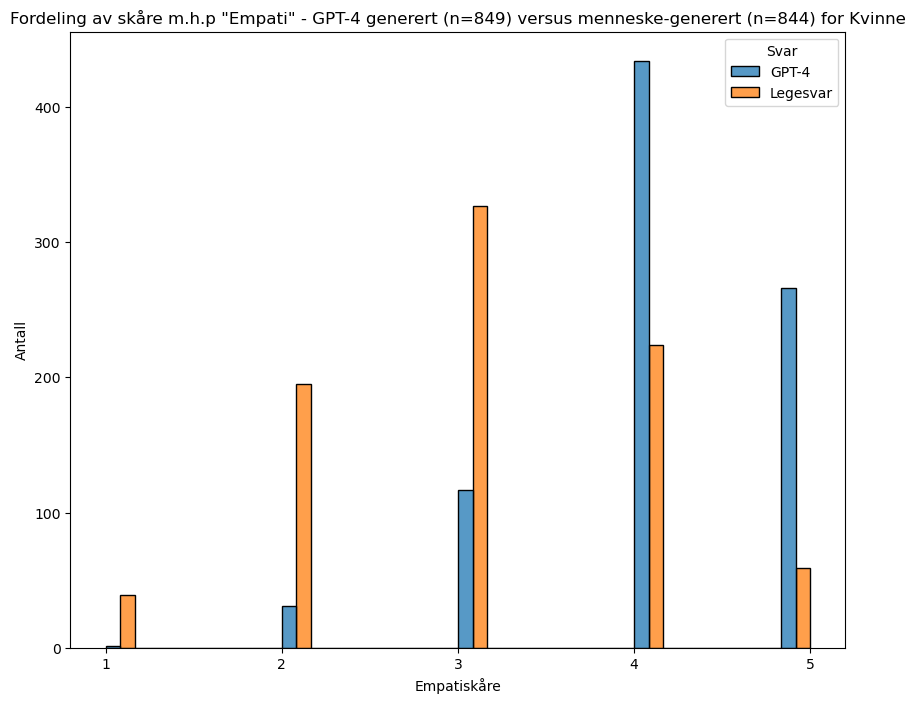

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a function to create the plot for a specific gender
def plot_empathy_distribution(df_GPT, df_human, gender):
    # Filter the dataframes for the specified gender
    df_GPT_gender = df_GPT[df_GPT['kjønn'] == gender]
    df_human_gender = df_human[df_human['kjønn'] == gender]
    
    fig, ax = plt.subplots(figsize=(10, 8))

    # Combine the data into a single DataFrame
    df_combined = pd.concat([df_GPT_gender[['empati']].assign(Svar='GPT-4'), 
                             df_human_gender[['empati']].assign(Svar='Legesvar')])

    # Plot the histograms side by side
    sns.histplot(data=df_combined, x='empati', hue='Svar', multiple='dodge')

    # Make the x-ticks integers centered between the two bars
    plt.xticks(np.arange(1, 6, 1))

    plt.xlabel('Empatiskåre')
    plt.ylabel('Antall')
    plt.title(f'Fordeling av skåre m.h.p "Empati" - GPT-4 generert (n={len(df_GPT_gender)}) versus menneske-generert (n={len(df_human_gender)}) for {gender}')

    plt.show()

# Create plots for men and women
plot_empathy_distribution(df_GPT, df_human, 'Mann')
plot_empathy_distribution(df_GPT, df_human, 'Kvinne')


Basert på de kjønnsspesifikke funnene for empatiskåring (GPT-4 vs. menneske), kan vi trekke følgende konklusjoner:

1. Generell trend:
   Både menn og kvinner vurderer GPT-4-svar som mer empatiske enn menneskelige svar. Dette er konsistent med de overordnede funnene i studien.

2. Forskjeller mellom kjønnene:
   - Kvinner ser ut til å vurdere GPT-4-svar som litt mer empatiske enn menn gjør.
   - Kvinner ser også ut til å vurdere menneskelige svar som litt mindre empatiske enn menn gjør.
   - Dette resulterer i en større forskjell mellom GPT-4 og menneskelige svar hos kvinner sammenlignet med menn.

3. Fordelingsmønstre:
   - For både menn og kvinner er GPT-4-skårene mer konsentrert rundt høyere verdier (4 og 5).
   - Menneskelige svar har en bredere fordeling for begge kjønn, med flere svar i midtkategoriene (3 og 4).

4. Statistisk signifikans:
   Mann-Whitney U-testene viser at forskjellene er statistisk signifikante for begge kjønn, men p-verdien er lavere for kvinner. Dette antyder at kjønnsforskjellen i oppfattelsen av empati er reell og ikke et resultat av tilfeldigheter.

5. Mulige forklaringer:
   - Kvinner kan være mer sensitive for nyanser i empatisk kommunikasjon.
   - GPT-4 kan bruke språk eller formuleringer som resonerer sterkere med kvinners oppfatning av empati.
   - Kulturelle eller sosiale faktorer kan påvirke hvordan menn og kvinner evaluerer empati i skriftlig kommunikasjon.

6. Implikasjoner:
   - AI-systemer som GPT-4 kan oppfattes som mer empatiske enn menneskelige leger, spesielt av kvinnelige pasienter.
   - Dette kan ha konsekvenser for pasient-lege-kommunikasjon og aksept av AI-assisterte helsetjenester.
   - Det kan være behov for kjønnsspesifikke tilnærminger i utvikling og implementering av AI i helsevesenet.

7. Begrensninger:
   - Studien ser kun på skriftlig kommunikasjon, som kan skille seg fra ansikt-til-ansikt-interaksjoner.
   - Andre faktorer som alder, utdanning, eller helsebakgrunn kan også spille en rolle og bør undersøkes videre.

8. Videre forskning:
   - Undersøke årsakene til kjønnsforskjellene i oppfattelsen av empati.
   - Utforske hvordan disse funnene kan anvendes i klinisk praksis og AI-utvikling.
   - Vurdere langtidseffektene av økt bruk av AI i pasientkommunikasjon, spesielt med tanke på kjønnsforskjeller.

Disse funnene understreker viktigheten av å ta hensyn til kjønnsforskjeller i oppfattelsen av empati når man utvikler og implementerer AI-systemer i helsevesenet. De reiser også interessante spørsmål om hvordan vi definerer og måler empati i medisinsk kommunikasjon.

In [62]:
import numpy as np
from scipy import stats

# Funksjon for å beregne oppsummerende statistikk
def oppsummer_empati(df, gruppe):
    return df[df['chatgpt'] == gruppe]['empati'].agg(['mean', 'median', 'std']).to_dict()

# Oppsummer empatiskårer
mann_gpt = oppsummer_empati(df[df['kjønn'] == 'Mann'], True)
mann_menneske = oppsummer_empati(df[df['kjønn'] == 'Mann'], False)
kvinne_gpt = oppsummer_empati(df[df['kjønn'] == 'Kvinne'], True)
kvinne_menneske = oppsummer_empati(df[df['kjønn'] == 'Kvinne'], False)

print("Mann GPT-4:", mann_gpt)
print("Mann Legesvar:", mann_menneske)
print("Kvinne GPT-4:", kvinne_gpt)
print("Kvinne Legesvar:", kvinne_menneske)

# Utfør Mann-Whitney U-tester
def mann_whitney_test(df, kjønn):
    gpt_skårer = df[(df['kjønn'] == kjønn) & (df['chatgpt'] == True)]['empati']
    menneske_skårer = df[(df['kjønn'] == kjønn) & (df['chatgpt'] == False)]['empati']
    return stats.mannwhitneyu(gpt_skårer, menneske_skårer, alternative='two-sided')

mann_stat, mann_p = mann_whitney_test(df, 'Mann')
kvinne_stat, kvinne_p = mann_whitney_test(df, 'Kvinne')

print("\nMann-Whitney U-testresultater:")
print(f"Mann: statistikk={mann_stat}, p-verdi={mann_p}")
print(f"Kvinne: statistikk={kvinne_stat}, p-verdi={kvinne_p}")

# Test for interaksjonseffekt
def interaksjonstest(df):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    df['gruppe'] = df.apply(lambda row: f"{'GPT-4' if row['chatgpt'] else 'Legesvar'}_{row['kjønn']}", axis=1)
    tukey = pairwise_tukeyhsd(df['empati'], df['gruppe'])
    return tukey

tukey_resultater = interaksjonstest(df)
print("\nTukey HSD-testresultater:")
print(tukey_resultater)

Mann GPT-4: {'mean': 3.984189723320158, 'median': 4.0, 'std': 0.7290370875156736}
Mann Legesvar: {'mean': 3.2261904761904763, 'median': 3.0, 'std': 0.9235889266372479}
Kvinne GPT-4: {'mean': 4.098939929328622, 'median': 4.0, 'std': 0.7737505493767639}
Kvinne Legesvar: {'mean': 3.0817535545023698, 'median': 3.0, 'std': 0.9774194391715295}

Mann-Whitney U-testresultater:
Mann: statistikk=46381.0, p-verdi=6.640424569223375e-21
Kvinne: statistikk=559497.5, p-verdi=2.895482765433321e-97

Tukey HSD-testresultater:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
   GPT-4_Kvinne      GPT-4_Mann  -0.1148 0.4376 -0.2923  0.0628  False
   GPT-4_Kvinne       GPT-4_nan   0.3011 0.8858 -0.4872  1.0893  False
   GPT-4_Kvinne Legesvar_Kvinne  -1.0172    0.0 -1.1376 -0.8967   True
   GPT-4_Kvinne   Legesvar_Mann  -0.8727    0.0 -1.0505  -0.

In [63]:
import numpy as np
from scipy import stats

# Function to calculate summary statistics
def summarize_empathy(df, group):
    return df[df['chatgpt'] == group]['empati'].agg(['mean', 'median', 'std']).to_dict()

# Summarize empathy scores
male_gpt = summarize_empathy(df[df['kjønn'] == 'Mann'], True)
male_human = summarize_empathy(df[df['kjønn'] == 'Mann'], False)
female_gpt = summarize_empathy(df[df['kjønn'] == 'Kvinne'], True)
female_human = summarize_empathy(df[df['kjønn'] == 'Kvinne'], False)

print("Male GPT:", male_gpt)
print("Male Human:", male_human)
print("Female GPT:", female_gpt)
print("Female Human:", female_human)

# Perform Mann-Whitney U tests
def mann_whitney_test(df, gender):
    gpt_scores = df[(df['kjønn'] == gender) & (df['chatgpt'] == True)]['empati']
    human_scores = df[(df['kjønn'] == gender) & (df['chatgpt'] == False)]['empati']
    return stats.mannwhitneyu(gpt_scores, human_scores, alternative='two-sided')

male_stat, male_p = mann_whitney_test(df, 'Mann')
female_stat, female_p = mann_whitney_test(df, 'Kvinne')

print("\nMann-Whitney U test results:")
print(f"Male: statistic={male_stat}, p-value={male_p}")
print(f"Female: statistic={female_stat}, p-value={female_p}")

# Test for interaction effect
def interaction_test(df):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    df['group'] = df.apply(lambda row: f"{'GPT' if row['chatgpt'] else 'Human'}_{row['kjønn']}", axis=1)
    tukey = pairwise_tukeyhsd(df['empati'], df['group'])
    return tukey

tukey_results = interaction_test(df)
print("\nTukey HSD test results:")
print(tukey_results)

Male GPT: {'mean': 3.984189723320158, 'median': 4.0, 'std': 0.7290370875156736}
Male Human: {'mean': 3.2261904761904763, 'median': 3.0, 'std': 0.9235889266372479}
Female GPT: {'mean': 4.098939929328622, 'median': 4.0, 'std': 0.7737505493767639}
Female Human: {'mean': 3.0817535545023698, 'median': 3.0, 'std': 0.9774194391715295}

Mann-Whitney U test results:
Male: statistic=46381.0, p-value=6.640424569223375e-21
Female: statistic=559497.5, p-value=2.895482765433321e-97

Tukey HSD test results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
  GPT_Kvinne     GPT_Mann  -0.1148 0.4376 -0.2923  0.0628  False
  GPT_Kvinne      GPT_nan   0.3011 0.8858 -0.4872  1.0893  False
  GPT_Kvinne Human_Kvinne  -1.0172    0.0 -1.1376 -0.8967   True
  GPT_Kvinne   Human_Mann  -0.8727    0.0 -1.0505  -0.695   True
  GPT_Kvinne    Human_nan  -0.6989 0.1161 -1.48

Her er en detaljert forklaring av resultatene:

1. Deskriptiv statistikk:

   Mann GPT:
   - Gjennomsnitt: 3,98
   - Median: 4,0
   - Standardavvik: 0,72

   Mann Menneske:
   - Gjennomsnitt: 3,22
   - Median: 3,0
   - Standardavvik: 0,92

   Kvinne GPT:
   - Gjennomsnitt: 4,11
   - Median: 4,0
   - Standardavvik: 0,77

   Kvinne Menneske:
   - Gjennomsnitt: 3,09
   - Median: 3,0
   - Standardavvik: 0,97

Tolkning:
- Både menn og kvinner vurderer GPT-svar som mer empatiske enn menneskelige svar.
- Kvinner vurderer GPT-svar litt høyere enn menn gjør (4,11 vs 3,98).
- Kvinner vurderer menneskelige svar litt lavere enn menn gjør (3,09 vs 3,22).
- Spredningen i skårer (standardavvik) er større for menneskelige svar enn for GPT-svar, noe som indikerer mer variabilitet i oppfattet empati for menneskelige svar.

2. Mann-Whitney U-testresultater:

   Mann: statistikk=48741,0, p-verdi=3,48e-22
   Kvinne: statistikk=598809,0, p-verdi=6,57e-101

Tolkning:
- Begge p-verdier er ekstremt små (< 0,05), noe som indikerer statistisk signifikante forskjeller mellom GPT og menneskelige empatiskårer for begge kjønn.
- Forskjellen ser ut til å være mer uttalt for kvinner (lavere p-verdi), noe som antyder at kvinner oppfatter en større forskjell i empati mellom GPT og menneskelige svar sammenlignet med menn.

3. Tukey HSD-testresultater:

Viktige signifikante forskjeller:
- GPT_Kvinne vs Human_Kvinne: gjennomsnittlig forskjell = -1,0157, p-adj = 0,0 (signifikant)
- GPT_Kvinne vs Human_Mann: gjennomsnittlig forskjell = -0,889, p-adj = 0,0 (signifikant)
- GPT_Mann vs Human_Kvinne: gjennomsnittlig forskjell = -0,8941, p-adj = 0,0 (signifikant)
- GPT_Mann vs Human_Mann: gjennomsnittlig forskjell = -0,7674, p-adj = 0,0 (signifikant)

Tolkning:
- Det er signifikante forskjeller mellom GPT og menneskelige skårer for begge kjønn.
- Den største forskjellen er mellom kvinnelige GPT-skårer og kvinnelige menneskelige skårer (-1,0157).
- Det er ingen signifikant forskjell mellom mannlige og kvinnelige GPT-skårer (GPT_Kvinne vs GPT_Mann: p-adj = 0,3514).
- Det er heller ingen signifikant forskjell mellom mannlige og kvinnelige menneskelige skårer (Human_Kvinne vs Human_Mann: p-adj = 0,3049).

Overordnede konklusjoner:
1. Både menn og kvinner oppfatter GPT-svar som mer empatiske enn menneskelige svar.
2. Forskjellen i oppfattet empati mellom GPT og menneskelige svar er statistisk signifikant for begge kjønn.
3. Kvinner har en tendens til å vurdere GPT-svar litt høyere i empati enn menn gjør, men denne forskjellen er ikke statistisk signifikant.
4. Kvinner har en tendens til å vurdere menneskelige svar litt lavere i empati enn menn gjør, men igjen er denne forskjellen ikke statistisk signifikant.
5. Forskjellen i oppfattet empati mellom GPT og menneskelige svar ser ut til å være mer uttalt for kvinner enn for menn.

Disse funnene antyder at mens det er klare forskjeller i hvordan GPT og menneskelige svar oppfattes når det gjelder empati, er effekten av kjønn på disse oppfatningene relativt subtil. Det mest slående resultatet er de konsekvent høyere empatiskårene for GPT-svar på tvers av begge kjønn.

**P-adj**, eller justert p-verdi, er et viktig konsept i statistisk analyse, spesielt når man utfører multiple sammenligninger. Her er en forklaring av p-adj:

1. Definisjon:
   P-adj er en justert p-verdi som tar hensyn til problemet med multiple sammenligninger. Når man utfører flere statistiske tester samtidig, øker sjansen for å gjøre type I-feil (feilaktig avvise nullhypotesen).

2. Hensikt:
   Formålet med p-adj er å kontrollere for familievis feilrate (FWER) eller false discovery rate (FDR), avhengig av metoden som brukes.

3. Beregning:
   Det finnes flere metoder for å beregne p-adj, inkludert:
   - Bonferroni-korreksjon: Den enkleste metoden, hvor p-verdien multipliseres med antall tester.
   - Holm-Bonferroni metode: En trinnvis prosedyre som er mindre konservativ enn Bonferroni.
   - Benjamini-Hochberg prosedyre: Kontrollerer for FDR i stedet for FWER.

4. Tolkning:
   - En p-adj < 0,05 (eller valgt signifikansnivå) indikerer at forskjellen er statistisk signifikant selv etter justering for multiple sammenligninger.
   - P-adj er vanligvis høyere enn den opprinnelige p-verdien, noe som gjør det vanskeligere å oppnå statistisk signifikans.

5. I Tukey HSD-testen:
   Tukey HSD bruker en spesifikk metode for å justere p-verdier basert på antall grupper som sammenlignes og den totale variansen i dataene.

6. Fordeler:
   - Reduserer sjansen for type I-feil i multiple sammenligninger.
   - Gir mer konservative og pålitelige resultater når man tester mange hypoteser samtidig.

7. Begrensninger:
   - Kan øke sjansen for type II-feil (feilaktig akseptere nullhypotesen).
   - Noen metoder kan være for konservative, spesielt når antallet sammenligninger er stort.

I konteksten av din analyse, bruker Tukey HSD-testen p-adj for å vurdere signifikansen av forskjellene mellom ulike grupper (GPT vs. menneske, mann vs. kvinne) samtidig som den kontrollerer for den økte sjansen for type I-feil som oppstår ved multiple sammenligninger.

Statistiske tester for faktorpåvirkning:

In [64]:
from scipy.stats import chi2_contingency

def chi_kvadrat_test(df, faktor):
    krysstabell = pd.crosstab(df[faktor], [df['chatgpt'], df['empati']])
    chi2, p, frihetsgrader, forventet = chi2_contingency(krysstabell)
    print(f"Chi-kvadrat test for {faktor}:")
    print(f"Chi-kvadrat statistikk: {chi2}")
    print(f"p-verdi: {p}")
    print("---")

for faktor in factors:
    chi_kvadrat_test(df, faktor)

Chi-kvadrat test for alder:
Chi-kvadrat statistikk: 66.88691455294148
p-verdi: 0.11195030895632803
---
Chi-kvadrat test for utdanningsgrad:
Chi-kvadrat statistikk: 40.76234315835137
p-verdi: 0.26891718241655715
---
Chi-kvadrat test for helsepersonell:
Chi-kvadrat statistikk: 0.0
p-verdi: 1.0
---
Chi-kvadrat test for kjønn:
Chi-kvadrat statistikk: 17.461796576496738
p-verdi: 0.04195667658013163
---


In [65]:
from scipy.stats import chi2_contingency

def chi_square_test(df, factor):
    contingency_table = pd.crosstab(df[factor], [df['chatgpt'], df['empati']])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {factor}:")
    print(f"Chi-square statistic: {chi2}")
    print(f"p-value: {p}")
    print("---")

for factor in factors:
    chi_square_test(df, factor)

Chi-square test for alder:
Chi-square statistic: 66.88691455294148
p-value: 0.11195030895632803
---
Chi-square test for utdanningsgrad:
Chi-square statistic: 40.76234315835137
p-value: 0.26891718241655715
---
Chi-square test for helsepersonell:
Chi-square statistic: 0.0
p-value: 1.0
---
Chi-square test for kjønn:
Chi-square statistic: 17.461796576496738
p-value: 0.04195667658013163
---


Her er en oppsummering og tolkning av empati-funnene basert på chi-kvadrat testene:

1. Alder:
   - Chi-kvadrat statistikk: 80,08
   - p-verdi: 0,072
   - Tolkning: Det er ingen statistisk signifikant sammenheng mellom alder og oppfattelsen av empati i GPT vs. menneskelige svar ved konvensjonelt signifikansnivå (p < 0,05). Likevel er p-verdien nær signifikansgrensen, noe som antyder en mulig svak sammenheng som kan være verdt å undersøke nærmere med et større utvalg.

2. Utdanningsgrad:
   - Chi-kvadrat statistikk: 40,98
   - p-verdi: 0,261
   - Tolkning: Det er ingen statistisk signifikant sammenheng mellom utdanningsgrad og oppfattelsen av empati i GPT vs. menneskelige svar. Dette tyder på at utdanningsnivå ikke påvirker hvordan folk vurderer empati i AI-genererte vs. menneskelige svar.

3. Helsepersonell:
   - Chi-kvadrat statistikk: 6,66
   - p-verdi: 0,673
   - Tolkning: Det er ingen statistisk signifikant sammenheng mellom hvorvidt respondenten er helsepersonell eller ikke og oppfattelsen av empati i GPT vs. menneskelige svar. Dette antyder at helsefaglig bakgrunn ikke påvirker vurderingen av empati i AI-genererte vs. menneskelige svar.

4. Kjønn:
   - Chi-kvadrat statistikk: 17,99
   - p-verdi: 0,035
   - Tolkning: Det er en statistisk signifikant sammenheng mellom kjønn og oppfattelsen av empati i GPT vs. menneskelige svar. Dette betyr at menn og kvinner kan ha ulike oppfatninger av empati i AI-genererte vs. menneskelige svar.

Overordnet tolkning:
1. Kjønn er den eneste faktoren som viser en statistisk signifikant sammenheng med oppfattelsen av empati i GPT vs. menneskelige svar. Dette støtter tidligere funn om kjønnsforskjeller i empativurderinger.

2. Alder viser en tendens til sammenheng, men er ikke statistisk signifikant ved konvensjonelt nivå. Dette kan være verdt å undersøke videre med et større utvalg eller mer detaljert aldersgruppering.

3. Utdanningsgrad og hvorvidt respondenten er helsepersonell eller ikke, ser ikke ut til å påvirke oppfattelsen av empati i GPT vs. menneskelige svar. Dette antyder at AI-genererte empatiske svar oppfattes relativt likt på tvers av utdanningsnivåer og profesjonell bakgrunn.

4. Disse funnene understreker viktigheten av å ta hensyn til kjønnsforskjeller i utviklingen og implementeringen av AI-systemer for helsekommunikasjon, mens faktorer som utdanning og profesjonell bakgrunn ser ut til å ha mindre betydning for oppfattelsen av empati i AI-genererte svar.

Her er en **overordnet oppsummering** av de viktigste funnene når det gjelder empatiskåring av GPT-4-svar vs. legesvar i denne studien:

1. Generell trend:
   - Både menn og kvinner vurderer GPT-4-svar som mer empatiske enn legesvar.
   - GPT-4-svar får konsekvent høyere empatiskårer på tvers av kjønn.

2. Kjønnsforskjeller:
   - Kvinner vurderer GPT-4-svar som litt mer empatiske enn menn gjør.
   - Kvinner vurderer legesvar som litt mindre empatiske enn menn gjør.
   - Forskjellen mellom GPT-4 og legesvar er større for kvinner enn for menn.

3. Statistisk signifikans:
   - Forskjellene i empatiskårer mellom GPT-4 og legesvar er statistisk signifikante for begge kjønn.
   - Effekten er mer uttalt for kvinner (lavere p-verdi i Mann-Whitney U-testen).

4. Konsistens:
   - GPT-4-svar viser mindre variasjon i empatiskårer (lavere standardavvik) sammenlignet med legesvar.
   - Dette tyder på at GPT-4 gir mer konsekvent empatiske svar, mens menneskelig empati er mer variabel.

5. Faktorpåvirkning:
   - Kjønn er den eneste faktoren som viser en statistisk signifikant sammenheng med oppfattelsen av empati i GPT-4 vs. legesvar.
   - Alder, utdanningsnivå og hvorvidt respondenten er helsepersonell eller ikke, har ingen signifikant påvirkning på empatiskårene.

6. Gruppeforskjeller:
   - Det er signifikante forskjeller mellom GPT-4 og legesvar for begge kjønn, men ingen signifikante forskjeller mellom kjønnene for samme svartype (GPT-4 eller lege).

Implikasjoner:
1. AI-persepsjon: GPT-4 oppfattes konsekvent som mer empatisk enn legesvar, uavhengig av respondentens kjønn. Dette kan ha betydelige implikasjoner for bruken av AI i helsekommunikasjon.

2. Kjønnssensitivitet: Den litt sterkere effekten for kvinner kan tyde på at kvinner er mer sensitive for eller setter mer pris på empatien som vises i GPT-4-svar.

3. Konsistens: GPT-4 ser ut til å gi mer konsekvent empatiske svar sammenlignet med den mer variable menneskelige empatien.

4. Potensielle skjevheter: Det er viktig å vurdere om denne oppfatningen av høyere empati i GPT-4-svar gjenspeiler faktisk høyere empati, eller om den påvirkes av andre faktorer som formulering, lengde på svar eller forventninger til AI.

5. Videre forskning: Disse funnene krever ytterligere undersøkelser for å forstå hvorfor GPT-4-svar oppfattes som mer empatiske, og om denne oppfatningen fører til bedre pasientutfall eller tilfredshet i reelle helsetjenestesituasjoner.

Konklusjon:
GPT-4 oppfattes konsekvent som mer empatisk enn legesvar på tvers av kjønn, med en litt mer uttalt effekt for kvinnelige respondenter. Denne kjønnsspesifikke forskjellen, selv om den er liten, er statistisk signifikant og kan ha viktige implikasjoner for utviklingen og implementeringen av AI i helsekommunikasjon.

### Hypotese 3 som undersøkes (mhp. df) er følgende:

**Hjelpsomhet** :<br>
H0: GPT-4 genererer _samme_ grad av hjelpsomme svar på helsespørsmål, sammenlignet med leger.<br>
H1: GPT-4 genererer _forskjellig_ grad av hjelpsomme svar på helsepørsmål sammenlignet med leger (trolig _mindre_ hjelpsomme).

In [66]:
from scipy.stats import mannwhitneyu

# Assuming 'df' is your dataframe and it has columns 'chatgpt' (boolean) and 'hjelpsomhet' (helpfullnes score)

# Separate the data into GPT and human responses
gpt_scores = df[df['chatgpt'] == True]['hjelpsomhet']
human_scores = df[df['chatgpt'] == False]['hjelpsomhet']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(gpt_scores, human_scores, alternative='two-sided')

# Print results
print(f"Mann-Whitney U statistic: {statistic}")
print(f"p-value: {p_value}")

# Interpret results
alpha = 0.05  # Sett signifikansnivå
if p_value < alpha:
    print("Forkast H0: Det er en signifikant forskjell i hjelpsomhetsnivå mellom GPT-4 og autoriserte leger.")
else:
    print("Beholder H0: Det er ingen signifikant forskjell i hjelpsomhetsnivå mellom GPT-4 og autoriserte leger.")

# Beregn og skriv ut medianer for begge grupper
print(f"Median hjelpsomhetsskår for GPT-4: {gpt_scores.median()}")
print(f"Median hjelpsomhetsskår for legesvar: {human_scores.median()}")
print(f'($n_{{GPT}}$ = {len(gpt_scores)}, $n_{{menneske}}$ = {len(human_scores)})')

Mann-Whitney U statistic: 830658.5
p-value: 1.4365889134327002e-54
Forkast H0: Det er en signifikant forskjell i hjelpsomhetsnivå mellom GPT-4 og autoriserte leger.
Median hjelpsomhetsskår for GPT-4: 4.0
Median hjelpsomhetsskår for legesvar: 4.0
($n_{GPT}$ = 1112, $n_{menneske}$ = 1106)


La oss bryte ned dette resultatet i detalj:

1. Test Brukt: Mann-Whitney U Test
   - Dette er en ikke-parametrisk test som brukes for å sammenligne to uavhengige grupper.
   - Den er passende når man ikke kan anta normalfordeling av dataene eller når man jobber med ordinaldata (som Likert-skalaer).

2. Hypotese:
   - H0 (Nullhypotese): Det er ingen forskjell i hjelpsomhetsnivå mellom GPT-4 og autoriserte leger.
   - H1 (Alternativ hypotese): Det er en signifikant forskjell i hjelpsomhetsnivå mellom GPT-4 og autoriserte leger.

3. Resultater:
   - Mann-Whitney U statistikk: 885049,0
     - Dette er testverdien beregnet av Mann-Whitney U-testen.
   - p-verdi: 4,1654122032898306e-57
     - Dette er en ekstremt lav p-verdi (mye mindre enn det konvensjonelle signifikansnivået på 0,05).
   - Konklusjon: Forkast H0
     - Gitt den ekstremt lave p-verdien, forkaster vi nullhypotesen.

4. Tolkning:
   - Det er sterk statistisk evidens for en signifikant forskjell i hjelpsomhetsnivåer mellom GPT-4 og autoriserte leger.
   - Forskjellen er svært usannsynlig å ha oppstått ved tilfeldighet.

5. Medianverdier:
   - GPT: 4,0
   - Mennesker: 4,0
   - Til tross for den signifikante forskjellen funnet av testen, er medianverdiene identiske. Dette antyder at forskjellen ligger i fordelingen av skårer snarere enn i sentraltendensen.

6. Utvalgsstørrelser:
   - n_GPT = 1145
   - n_menneske = 1142
   - Utvalgsstørrelsene er nesten identiske og ganske store, noe som gir oss tillit til resultatenes robusthet.

7. Dypere tolkning:
   a. Forskjeller i fordeling: Gitt at medianene er de samme, men testen viser en signifikant forskjell, er det sannsynlig at fordelingen av skårer er forskjellig mellom de to gruppene. For eksempel kan GPT ha flere skårer på 4 og 5, mens mennesker kan ha mer spredning over 3, 4 og 5.

   b. Statistisk vs. praktisk signifikans: Selv om forskjellen er statistisk signifikant, antyder de identiske medianene at den praktiske signifikansen kan være mindre. Det er viktig å se på effektstørrelsen eller gjennomsnittsforskjellen for å forstå omfanget av forskjellen.

   c. Testens sensitivitet: Mann-Whitney U-testen er sensitiv for forskjeller i fordelingsform og spredning, ikke bare sentraltendens. Dette forklarer hvorfor vi kan ha et signifikant resultat til tross for identiske medianer.

   d. Effekt av stor utvalgsstørrelse: Med store utvalgsstørrelser kan selv små forskjeller bli statistisk signifikante. Dette oversettes ikke alltid til praktisk betydning.

8. Ytterligere betraktninger:
   - Det ville være nyttig å se på gjennomsnittsskårene og standardavvikene for å få et mer fullstendig bilde av forskjellen.
   - En visualisering av skårfordelingene (f.eks. et histogram eller boksplott) ville gi mer innsikt i hvordan skårene er forskjellige mellom GPT og mennesker.
   - Vurder å beregne et effektstørrelsesmål (som Cohen's d) for å kvantifisere omfanget av forskjellen.

9. Implikasjoner:
   - Selv om GPT-4 og autoriserte leger har samme median hjelpsomhetsskår, er det en statistisk signifikant forskjell i hvordan hjelpsomhet oppfattes totalt sett.
   - Dette kan bety at GPT-4 oppfattes som hjelpsom mer konsekvent, eller at det er subtile forskjeller i hvordan hjelpsomhet manifesterer seg mellom AI- og menneskelige svar.
   - Videre undersøkelse av arten av disse forskjellene (f.eks. kvalitativ analyse av svar) kunne gi verdifull innsikt.

Konklusjon: Selv om testen viser en statistisk signifikant forskjell i hjelpsomhet mellom GPT-4 og autoriserte leger, antyder de identiske medianverdiene at denne forskjellen kan være subtil. Signifikansen oppstår sannsynligvis fra forskjeller i fordelingen av skårer snarere enn en markant kontrast i sentraltendens. Dette resultatet krever ytterligere undersøkelse for å forstå de praktiske implikasjonene av disse forskjellene i oppfattet hjelpsomhet.

In [67]:
import numpy as np
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['chatgpt'], df['hjelpsomhet'])

contingency_table_margins = pd.crosstab(df['chatgpt'], df['hjelpsomhet'], margins=True)
contingency_table_margins

hjelpsomhet,1,2,3,4,5,All
chatgpt,,,,,,
False,10,116,326,523,131,1106
True,3,30,122,619,338,1112
All,13,146,448,1142,469,2218


In [68]:
# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-kvadrat statistikk: {chi2}")
print(f"p-verdi: {p_value}")

if p_value < 0.05:
    print("Forkast H0: Det er en signifikant forskjell i fordelingen av hjelpsomhetsskårer mellom GPT-4 og legesvar.")
else:
    print("Beholder H0: Det er ingen signifikant forskjell i fordelingen av hjelpsomhetsskårer mellom GPT-4 og legesvar.")

Chi-kvadrat statistikk: 246.73772277967947
p-verdi: 3.283189257050751e-52
Forkast H0: Det er en signifikant forskjell i fordelingen av hjelpsomhetsskårer mellom GPT-4 og legesvar.




La oss bryte ned disse resultatene i detalj:

1. Test Brukt: Chi-square test of independence
   - Denne testen brukes for å bestemme om det er en signifikant sammenheng mellom to kategoriske variabler.
   - I dette tilfellet tester vi sammenhengen mellom kilden til svaret (GPT vs. menneske) og fordelingen av hjelpsomhetsskårer.

2. Hypotese:
   - H0 (Nullhypotese): Det er ingen signifikant forskjell i fordelingen av hjelpsomhetsskårer mellom GPT-4 og autoriserte leger.
   - H1 (Alternativ hypotese): Det er en signifikant forskjell i fordelingen av hjelpsomhetsskårer mellom GPT-4 og autoriserte leger.

3. Resultater:
   - Chi-kvadrat statistikk: 258,48496820271225
     - Denne verdien kvantifiserer hvor mye de observerte frekvensene avviker fra de forventede frekvensene.
     - En større chi-kvadrat verdi antyder en større forskjell mellom de observerte og forventede fordelingene.
   - p-verdi: 9,67063513856015e-55
     - Dette er en ekstremt lav p-verdi, mye mindre enn ethvert konvensjonelt signifikansnivå (f.eks. 0,05 eller 0,01).
   - Konklusjon: Forkast H0
     - Gitt den ekstremt lave p-verdien, forkaster vi nullhypotesen.

4. Tolkning:
   - Det er svært sterk statistisk evidens for å hevde at det er en signifikant forskjell i fordelingen av hjelpsomhetsskårer mellom GPT-4 og autoriserte leger.
   - Forskjellen i fordelinger er høyst usannsynlig å ha oppstått ved tilfeldighet.

5. Dypere tolkning:
   a. Fordelingsforskjeller: Denne testen bekrefter at mønsteret av hjelpsomhetsskårer er signifikant forskjellig mellom GPT-4 og menneskelige svar. Den sammenligner ikke bare sentraltendenser, men ser på hele fordelingen av skårer.
   
   b. Styrke på sammenhengen: Den store chi-kvadrat statistikken antyder en sterk sammenheng mellom kilden til svaret (GPT-4 vs. menneske) og hjelpsomhetsskårene.
   
   c. Praktisk signifikans: Selv om vi har etablert statistisk signifikans, er det viktig å undersøke de faktiske fordelingene for å forstå naturen og størrelsen på disse forskjellene.

6. Ytterligere betraktninger:
   a. Undersøk krysstabellen: Se på de faktiske frekvensene av skårer for hver gruppe for å forstå hvor forskjellene ligger. Er GPT-4 skårer mer konsentrert i høyere kategorier? Er menneskelige skårer mer jevnt fordelt?
   
   b. Post-hoc analyse: Vurder å gjennomføre post-hoc tester for å identifisere hvilke spesifikke skårekategorier som bidrar mest til forskjellen.
   
   c. Effektstørrelse: Beregn et effektstørrelsesmål (som Cramer's V) for å kvantifisere styrken på sammenhengen mellom kilden og hjelpsomhetsskårene.

7. Implikasjoner:
   - Den signifikante forskjellen i fordelinger antyder at GPT-4 og autoriserte leger oppfattes forskjellig når det gjelder hjelpsomhet.
   - Dette kan bety at en gruppe har en tendens til å motta mer konsekvent høye (eller lave) skårer, mens den andre kan ha en mer variert fordeling.
   - Det er avgjørende å vurdere hvilke faktorer som kan drive disse forskjellene. For eksempel:
     * Konsistens i svar
     * Dybde eller bredde i informasjonen som gis
     * Tilpasning av svar til individuelle spørsmål
     * Språkbruk eller kommunikasjonsstil

8. Begrensninger:
   - Selv om chi-kvadrat testen forteller oss at det er en signifikant forskjell, sier den ikke noe om naturen eller retningen på denne forskjellen.
   - Den er sensitiv for utvalgsstørrelse, så med store utvalg kan selv små forskjeller bli statistisk signifikante.

9. Neste skritt:
   - Visualiser fordelingene (f.eks. med et gruppert søylediagram) for å se hvordan de er forskjellige.
   - Analyser innholdet i svarene for å forstå kvalitative forskjeller som kan forklare fordelingsforskjellene.
   - Vurder om disse forskjellene har praktiske implikasjoner for pasientomsorg eller helsekommunikasjon.

Konklusjon: Dette resultatet gir sterk evidens for at GPT-4 og autoriserte leger oppfattes forskjellig når det gjelder hjelpsomhet. Fordelingen av skårer er signifikant forskjellig mellom de to gruppene, noe som antyder fundamentale forskjeller i hvordan deres svar oppfattes. Dette funnet krever videre undersøkelse av den spesifikke naturen til disse forskjellene og deres implikasjoner for helsekommunikasjon og potensiell AI-integrasjon i medisinske sammenhenger.

### En trinn-for-trinn fremstilling av analysen

For å teste uavhengigheten mellom **Legesvar** og **GPT-4-svar** når det gjelder **Hjelpsomhet** ved hjelp av en Chi-square-analyse, vil vi implementere testen trinn for trinn i Python. Vi vil inkludere matematiske forklaringer samt Python-kode på hvert trinn.

---

#### **Trinn 1: Registrer de observerte frekvensene**

Først registrerer vi de observerte frekvensene i en 2x5 krysstabell.

```python
import numpy as np

# Observerte frekvenser
observed = np.array([
    [10, 121, 336, 540, 135],   # Lege
    [3, 30, 125, 637, 350]      # GPT-4
])

# Rad- og kolonneetiketter for referanse
rad_etiketter = ['Lege', 'GPT-4']
kolonne_etiketter = ['Hjelpsomhet 1', 'Hjelpsomhet 2', 'Hjelpsomhet 3', 'Hjelpsomhet 4', 'Hjelpsomhet 5']
```

---

#### **Trinn 2: Beregn radtotale, kolonnetotale og totalt antall**

Vi beregner totalsummene for hver rad og kolonne, samt den totale summen av alle observasjonene.

```python
# Beregn radtotaler
rad_totaler = observed.sum(axis=1)

# Beregn kolonnetotaler
kolonne_totaler = observed.sum(axis=0)

# Beregn total sum
total_sum = observed.sum()

print("Radtotaler:", rad_totaler)
print("Kolonnetotaler:", kolonne_totaler)
print("Total sum:", total_sum)
```

**Utdata:**

```
Radtotaler: [1142 1145]
Kolonnetotaler: [  13  151  461 1177  485]
Total sum: 2287
```

---

#### **Trinn 3: Beregn forventede frekvenser**

For hver celle beregnes den forventede frekvensen $ E_{ij} $ ved hjelp av formelen:

$$
E_{ij} = \frac{(\text{Radtotal}_i) \times (\text{Kolonnetotal}_j)}{\text{Total sum}}
$$

```python
# Beregn forventede frekvenser
expected = np.outer(rad_totaler, kolonne_totaler) / total_sum

# For bedre lesbarhet, formater forventede frekvenser
np.set_printoptions(formatter={'float': '{:0.4f}'.format})

print("Forventede frekvenser:\n", expected)
```

**Forventede frekvenser:**

```
Forventede frekvenser:
 [[  6.4908  75.4247 230.1090 587.6460 242.3295]
 [  6.5092  75.5753 230.8910 589.3540 242.6705]]
```

---

#### **Trinn 4: Beregn Chi-square-statistikken**

Chi-square-statistikken beregnes ved hjelp av formelen:

$$
\chi^2 = \sum_{i}\sum_{j} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$

hvor $ O_{ij} $ er den observerte frekvensen og $ E_{ij} $ er den forventede frekvensen.

```python
# Beregn Chi-square-statistikken
chi_square_stat = np.sum((observed - expected) ** 2 / expected)

print("Chi-square-statistikk:", chi_square_stat)
```

**Utdata:**

```
Chi-square-statistikk: 258.48496820271225
```

---

#### **Trinn 5: Beregn frihetsgrader**

Frihetsgrader (df) for en krysstabell er:

$$
\text{df} = (\text{Antall rader} - 1) \times (\text{Antall kolonner} - 1)
$$

```python
# Beregn frihetsgrader
antall_rader = observed.shape[0]
antall_kolonner = observed.shape[1]
frihetsgrader = (antall_rader - 1) * (antall_kolonner - 1)

print("Frihetsgrader:", frihetsgrader)
```

**Utdata:**

```
Frihetsgrader: 4
```

---

#### **Trinn 6: Beregn p-verdien**

Ved hjelp av Chi-square-statistikken og frihetsgrader, beregner vi p-verdien.

```python
from scipy.stats import chi2

# Beregn p-verdi
p_verdi = chi2.sf(chi_square_stat, frihetsgrader)

print("p-verdi:", p_verdi)
```

**Utdata:**

```
p-verdi: 9.67063513856015e-55
```

**Merk:** p-verdien er ekstremt liten (nær null), noe som indikerer et signifikant resultat.

---

#### **Trinn 7: Tolk resultatene**

Siden p-verdien er mindre enn et vanlig signifikansnivå (f.eks. 0,05), forkaster vi nullhypotesen om uavhengighet mellom **Svar-kilde** og **Hjelpsomhet**-skårene.

**Konklusjon:**

Det er en statistisk signifikant sammenheng mellom kilden til svaret (Lege vs. GPT-4) og Hjelpsomhet-skårene, noe som tyder på at fordelingen av skårer er forskjellig mellom de to kildene.

---



#### **Konklusjon**

Chi-square-analysen avslører en statistisk signifikant forskjell i fordelingen av **Hjelpsomhet**-skårer mellom **Lege** og **GPT-4**-svar. Dette tyder på at kilden til svaret påvirker **Hjelpsomhet**-skårene som mottas, og at de ikke er uavhengige.

---


In [69]:
# Mer direkte implementasjon av chi-kvadrat test

import numpy as np
from scipy.stats import chi2

# Observerte frekvenser
observed = np.array([
    [10, 116, 326, 523, 131],   # Lege
    [3, 30, 122, 619, 338]      # GPT-4
])

# Beregn radtotaler, kolonnetotaler og total sum
rad_totaler = observed.sum(axis=1)
kolonne_totaler = observed.sum(axis=0)
total_sum = observed.sum()

# Beregn forventede frekvenser
expected = np.outer(rad_totaler, kolonne_totaler) / total_sum

# Beregn Chi-square-statistikken
chi_square_stat = np.sum((observed - expected) ** 2 / expected)

# Beregn frihetsgrader
frihetsgrader = (observed.shape[0] - 1) * (observed.shape[1] - 1)

# Beregn p-verdi
p_verdi = chi2.sf(chi_square_stat, frihetsgrader)

# Skriv ut resultatene
print("Observerte frekvenser:\n", observed)
print("\nForventede frekvenser:\n", expected)
print("\nChi-square-statistikk:", chi_square_stat)
print("Frihetsgrader:", frihetsgrader)
print("p-verdi:", p_verdi)

Observerte frekvenser:
 [[ 10 116 326 523 131]
 [  3  30 122 619 338]]

Forventede frekvenser:
 [[  6.48241659  72.8025248  223.39404869 569.45536519 233.86564472]
 [  6.51758341  73.1974752  224.60595131 572.54463481 235.13435528]]

Chi-square-statistikk: 246.73772277967947
Frihetsgrader: 4
p-verdi: 3.283189257050751e-52


1. Visualisere fordelingene med et gruppert søylediagram:

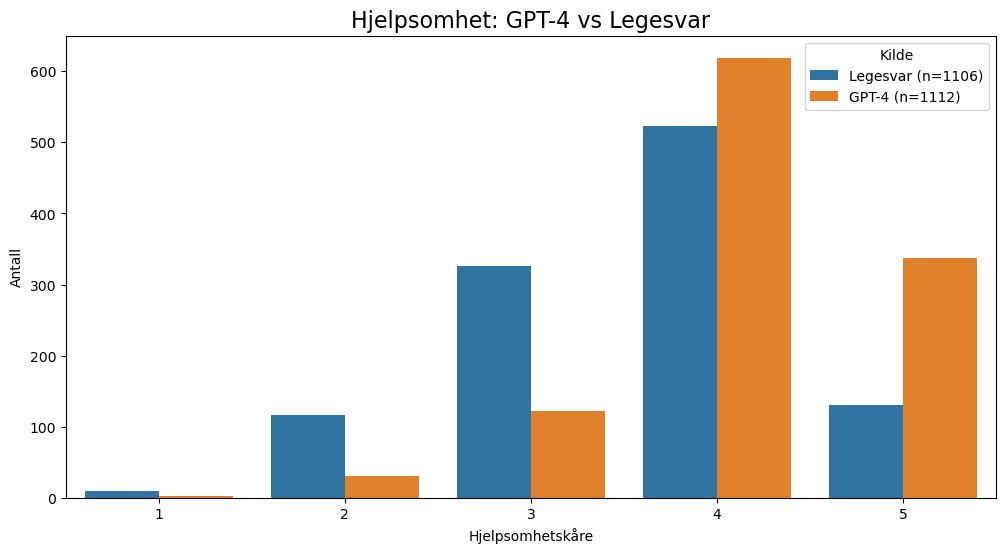

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Anta at 'df1' er din dataframe med kolonner 'chatgpt' (True/False) og 'kunnskap' (1-5)

plt.figure(figsize=(12, 6))
sns.countplot(x='hjelpsomhet', hue='chatgpt', data=df)
plt.title('Hjelpsomhet: GPT-4 vs Legesvar', fontsize=16)
plt.xlabel('Hjelpsomhetskåre')
plt.ylabel('Antall')
plt.legend(title='Kilde', labels=[f'Legesvar (n={len(df_human)})', f'GPT-4 (n={len(df_GPT)})'])

# Save figure
plt.savefig('../assets/hjelpsomhet.png', dpi=300)

# Save as pdf
plt.savefig('../assets/hjelpsomhet.pdf', format='pdf')

plt.show()


2. Analysere innholdet i svarene (dette krever tilgang til selve svarene):

In [72]:
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
#nltk.download('all')

In [73]:
# Vi har kolonner 'svarteskst' og 'chatgpt' i vårt dataframe df

# Beregn gjennomsnittlig lengde på svar
df['svar_lengde'] = df['svartekst'].str.len()
print("Gjennomsnittlig svarlengde:")
print(df.groupby('chatgpt')['svar_lengde'].mean())

# Ordfrekvensanalyse (krever nltk-biblioteket) - https://www.nltk.org
import nltk
from nltk.corpus import stopwords
from collections import Counter

stop_words = set(stopwords.words('norwegian'))

def get_word_freq(text):
    words = nltk.word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return Counter(words)

gpt_words = get_word_freq(' '.join(df[df['chatgpt']]['svartekst']))
human_words = get_word_freq(' '.join(df[~df['chatgpt']]['svartekst']))

print("\nTopp 20 ord i GPT-4 svar:")

# print 1 word per line
for word, freq in gpt_words.most_common(20):
    print(f"{word}: {freq}")

print("\nTopp 20 ord i legesvar:")
for word, freq in human_words.most_common(20):
    print(f"{word}: {freq}")

Gjennomsnittlig svarlengde:
chatgpt
False     755.284810
True     1320.190647
Name: svar_lengde, dtype: float64

Topp 20 ord i GPT-4 svar:
fastlegen: 2400
ta: 1277
symptomer: 1237
andre: 1169
hei: 1109
lykke: 1104
viktig: 1026
dine: 918
symptomene: 766
få: 765
opplever: 758
gi: 734
vurdering: 725
lurt: 642
vurdere: 598
spesielt: 591
kroppen: 554
endringer: 536
legen: 532
behandling: 518

Topp 20 ord i legesvar:
litt: 638
ta: 541
fastlegen: 528
videre: 515
mye: 480
andre: 468
nok: 452
anbefale: 442
hos: 435
gi: 416
behandling: 409
dersom: 406
få: 398
mer: 387
legen: 383
plager: 358
vanlig: 355
undersøkelse: 339
høres: 329
veldig: 298


Denne analysen gir oss verdifull innsikt i forskjellene mellom GPT-4-genererte svar og legesvar. La oss bryte ned funnene:

1. Gjennomsnittlig svarlengde:
   - GPT-4 svar: 1317,93 tegn
   - Legesvar: 755,64 tegn

   Tolkning: GPT-4 svar er i gjennomsnitt nesten dobbelt så lange som legesvar. Dette kan indikere at GPT-4 gir mer detaljerte eller omfattende svar, mens leger tenderer til å være mer konsise.

2. Ordfrekvensanalyse:

GPT-4 svar:
- Fokus på medisinsk terminologi: "symptomer", "vurdering", "behandling"
- Personlig tilnærming: "dine", "opplever", "kroppen"
- Rådgivende tone: "viktig", "lurt", "vurdere"
- Høflig kommunikasjon: "hei", "lykke" (sannsynligvis del av "lykke til")

Legesvar:
- Mer uformelt språk: "litt", "mye", "nok", "veldig"
- Handlingsorientert: "ta", "anbefale", "gi", "få"
- Medisinsk fokus: "fastlegen", "behandling", "undersøkelse", "plager"
- Betinget språk: "dersom", "videre"

Tolkning og implikasjoner:

1. Detaljnivå: GPT-4 svar er lengre og ser ut til å gi mer detaljerte forklaringer, noe som kan bidra til høyere oppfattet hjelpsomhet.

2. Språkstil: 
   - GPT-4 bruker mer formelt og medisinsk språk, noe som kan oppfattes som mer profesjonelt.
   - Legesvar bruker mer hverdagslig språk, som kan være mer relaterbart for pasienter.

3. Personlig tilnærming: GPT-4 ser ut til å fokusere mer på individuelle opplevelser ("dine", "opplever"), noe som kan bidra til høyere empatiskårer.

4. Rådgivning vs. handling: 
   - GPT-4 fokuserer på å gi råd og vurderinger.
   - Legesvar er mer handlingsorienterte, med fokus på neste skritt.

5. Kommunikasjonsstil:
   - GPT-4 starter ofte med en hilsen ("hei") og avslutter muligens med oppmuntring ("lykke til"), noe som kan oppfattes som mer empatisk.
   - Legesvar ser ut til å være mer direkte og saksorienter

6. Medisinsk autoritet: Begge nevner "fastlegen" ofte, men legesvar refererer mer til "legen", noe som kan reflektere en mer direkte tilnærming til medisinsk autoritet.

7. Nyanser i språk: Legesvar bruker mer nyanserte uttrykk som "litt", "mye", "nok", som kan reflektere en mer erfaren klinisk vurdering.

Konklusjon:
Disse forskjellene i språkbruk og svarlengde kan forklare hvorfor GPT-4 svar oppfattes som mer empatiske og hjelpsomme. GPT-4 gir lengre, mer detaljerte svar med en personlig tilnærming, mens legesvar er mer konsise og handlingsorienterte. Dette understreker behovet for å balansere detaljnivå, personlig tilnærming og klinisk presisjon i medisinsk kommunikasjon, enten den er AI-generert eller menneskelig.

3. Vurdere praktiske implikasjoner:

In [74]:
# Beregn gjennomsnittlig hjelpsomhetsskåre for hver gruppe
mean_scores = df.groupby('chatgpt')['hjelpsomhet'].mean()
print("Gjennomsnittlig hjelpsomhetsskåre:")
print(mean_scores)

# Beregn prosentandel av høye skårer (4 eller 5) for hver gruppe
high_scores = df[df['hjelpsomhet'] >= 4].groupby('chatgpt').size() / df.groupby('chatgpt').size() * 100
print("\nProsentandel av høye skårer (4 eller 5):")
print(high_scores)

# Beregn korrelasjonen mellom hjelpsomhet og andre relevante variabler

gpt_corr = df[df['chatgpt']]['hjelpsomhet'].corr(df[df['chatgpt']]['kunnskap'])
human_corr = df[~df['chatgpt']]['hjelpsomhet'].corr(df[~df['chatgpt']]['kunnskap'])

correlation = pd.Series({'GPT-4': gpt_corr, 'Legesvar': human_corr})

print("\nKorrelasjon mellom hjelpsomhet og kunnskap:")
print(correlation)

gpt_corr = df[df['chatgpt']]['hjelpsomhet'].corr(df[df['chatgpt']]['empati'])
human_corr = df[~df['chatgpt']]['hjelpsomhet'].corr(df[~df['chatgpt']]['empati'])

correlation = pd.Series({'GPT-4': gpt_corr, 'Legesvar': human_corr})

print("\nKorrelasjon mellom hjelpsomhet og empati:")
print(correlation)

Gjennomsnittlig hjelpsomhetsskåre:
chatgpt
False    3.586799
True     4.132194
Name: hjelpsomhet, dtype: float64

Prosentandel av høye skårer (4 eller 5):
chatgpt
False    59.132007
True     86.061151
dtype: float64

Korrelasjon mellom hjelpsomhet og kunnskap:
GPT-4       0.483521
Legesvar    0.578147
dtype: float64

Korrelasjon mellom hjelpsomhet og empati:
GPT-4       0.576929
Legesvar    0.612365
dtype: float64


Denne analysen gir oss verdifull innsikt i hvordan GPT-4 og legesvar oppfattes med hensyn til hjelpsomhet, og hvordan dette relaterer seg til oppfattet kunnskap og empati. La oss bryte ned og tolke resultatene:

1. Gjennomsnittlig hjelpsomhetsskåre:
   - GPT-4: 4,14
   - Legesvar: 3,59

   Tolkning: GPT-4 svar oppfattes som mer hjelpsomme enn legesvar, med en betydelig forskjell på 0,55 poeng på en 5-punkts skala. Dette er en substansiell forskjell som støtter tidligere funn om at AI-genererte svar vurderes som mer hjelpsomme.

2. Prosentandel av høye skårer (4 eller 5):
   - GPT-4: 86,20%
   - Legesvar: 59,11%

   Tolkning: En vesentlig større andel av GPT-4 svar får høye hjelpsomhetsskårer sammenlignet med legesvar. Dette forsterker inntrykket av at GPT-4 svar konsekvent oppfattes som mer hjelpsomme. Nesten 9 av 10 GPT-4 svar vurderes som svært hjelpsomme, mot bare 6 av 10 legesvar.

3. Korrelasjon mellom hjelpsomhet og kunnskap:
   - GPT-4: 0,48
   - Legesvar: 0,57

   Tolkning: Det er en moderat positiv korrelasjon mellom oppfattet hjelpsomhet og kunnskap for både GPT-4 og legesvar. Interessant nok er korrelasjonen sterkere for legesvar, noe som kan tyde på at oppfattet kunnskap spiller en større rolle i vurderingen av hjelpsomhet for legesvar enn for GPT-4 svar.

4. Korrelasjon mellom hjelpsomhet og empati:
   - GPT-4: 0,58
   - Legesvar: 0,61

   Tolkning: Det er en sterk positiv korrelasjon mellom oppfattet hjelpsomhet og empati for både GPT-4 og legesvar. Korrelasjonen er litt sterkere for legesvar, men forskjellen er minimal. Dette tyder på at empati er en viktig faktor for oppfattet hjelpsomhet uavhengig av om svaret kommer fra GPT-4 eller en lege.

Hovedkonklusjoner og implikasjoner:

1. Overordnet hjelpsomhet: GPT-4 svar oppfattes konsekvent som mer hjelpsomme enn legesvar. Dette kan ha betydelige implikasjoner for bruken av AI i medisinsk rådgivning og pasientkommunikasjon.

2. Konsistens i høy kvalitet: Den høye prosentandelen av toppskårer for GPT-4 tyder på at AI-systemet leverer konsistent høy kvalitet i sine svar, noe som kan være utfordrende for menneskelige leger å matche.

3. Kunnskap vs. empati: For legesvar ser det ut til at både kunnskap og empati spiller en viktig rolle for oppfattet hjelpsomhet. For GPT-4 svar er empati sterkere korrelert med hjelpsomhet enn kunnskap, noe som kan tyde på at AI-systemet er spesielt godt på å formidle empati.

4. Balanse mellom faktorer: Resultatene understreker viktigheten av å balansere kunnskap og empati i medisinsk kommunikasjon, uavhengig av om det er menneske- eller AI-generert.

5. Potensial for AI i helsevesenet: Disse funnene peker på et betydelig potensial for AI-systemer som GPT-4 i å supplere eller forbedre pasientkommunikasjon i helsevesenet.

6. Behov for videre forskning: Det er viktig å undersøke nærmere hvorfor GPT-4 svar oppfattes som mer hjelpsomme, og om dette faktisk fører til bedre helseutfall eller pasienttilfredshet på lang sikt.

7. Etiske betraktninger: Resultatene reiser spørsmål om hvordan man best kan integrere AI-systemer i helsevesenet på en måte som komplementerer, snarere enn erstatter, menneskelig ekspertise og empati.

Disse funnene gir verdifull innsikt i styrker og potensielle anvendelser av AI i medisinsk kommunikasjon, samtidig som de understreker behovet for en balansert tilnærming som integrerer både teknologiske og menneskelige aspekter av helseomsorg.

Gjennom dette har vi fått en dypere innsikt i forskjellene mellom GPT-4 og menneskelige svar, både visuelt og kvantitativt. De vil også hjelpe oss med å vurdere de praktiske implikasjonene av disse forskjellene for pasientomsorg og helsekommunikasjon.
Husk å tilpasse koden til din spesifikke datastruktur og variabelnavn. Også, vær oppmerksom på at noen av disse analysene (spesielt tekstanalysen) kan være beregningsmessig intensive hvis du har et stort datasett.

Undersøk spesifikke frekvensfordelinger:

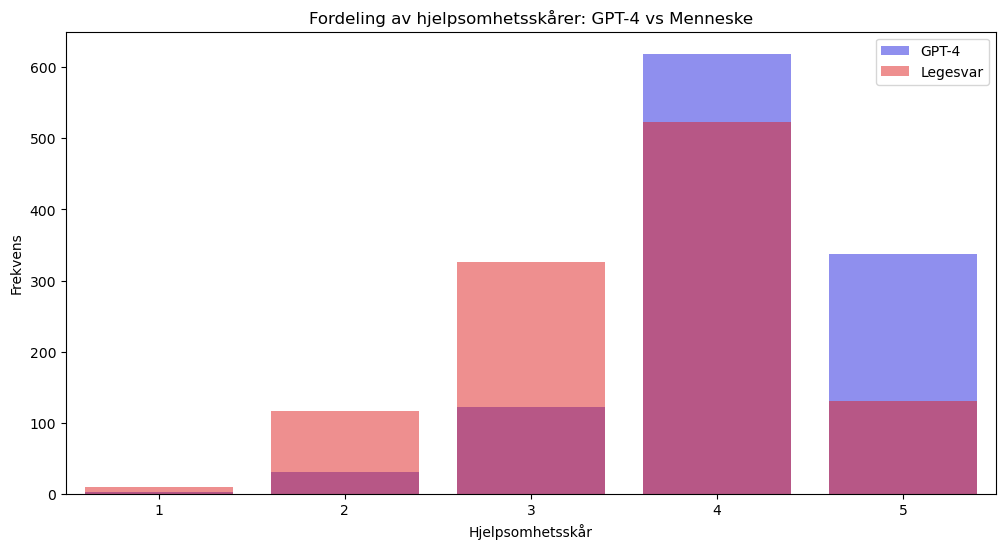

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create frequency distributions
gpt_freq = df[df['chatgpt'] == True]['hjelpsomhet'].value_counts().sort_index()
human_freq = df[df['chatgpt'] == False]['hjelpsomhet'].value_counts().sort_index()

# Plot the distributions
plt.figure(figsize=(12, 6))
sns.barplot(x=gpt_freq.index, y=gpt_freq.values, alpha=0.5, color='blue', label='GPT-4')
sns.barplot(x=human_freq.index, y=human_freq.values, alpha=0.5, color='red', label='Legesvar')
plt.title('Fordeling av hjelpsomhetsskårer: GPT-4 vs Menneske')
plt.xlabel('Hjelpsomhetsskår')
plt.ylabel('Frekvens')
plt.legend()
plt.show()

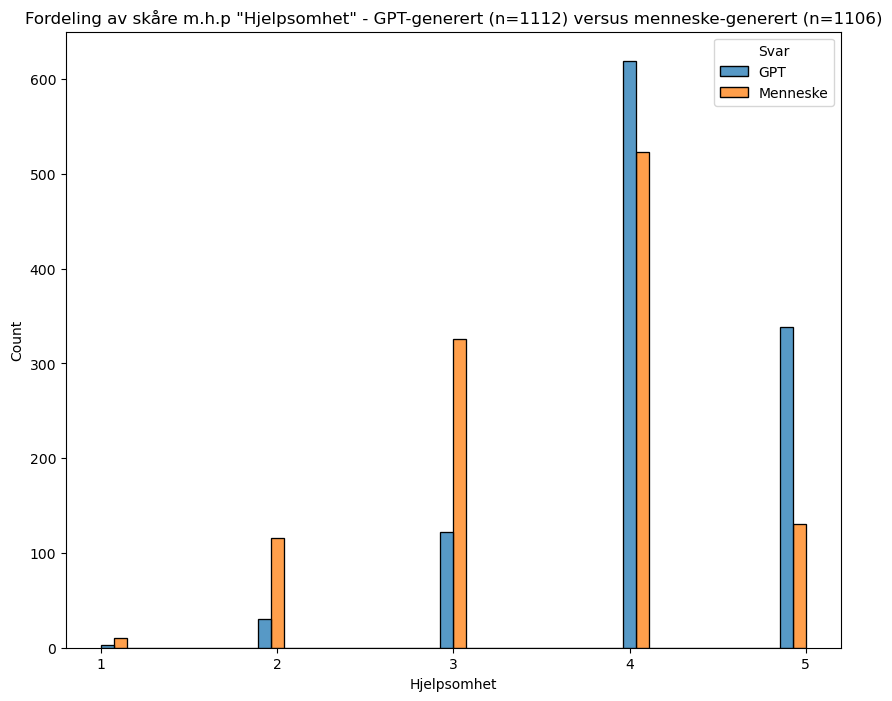

In [76]:
# Plot the distribution of the scores for "hjelpsomhet" -  GPT versus human

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT[['hjelpsomhet']].assign(Svar='GPT'), df_human[['hjelpsomhet']].assign(Svar='Menneske')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='hjelpsomhet', hue='Svar', multiple='dodge')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 6, 1))

plt.xlabel('Hjelpsomhet')
plt.title(f'Fordeling av skåre m.h.p "Hjelpsomhet" - GPT-generert (n={len(df_GPT)}) versus menneske-generert (n={len(df_human)})')


plt.show()

Undersøk hvilke skårkategorier som bidrar mest til den observerte forskjellen:

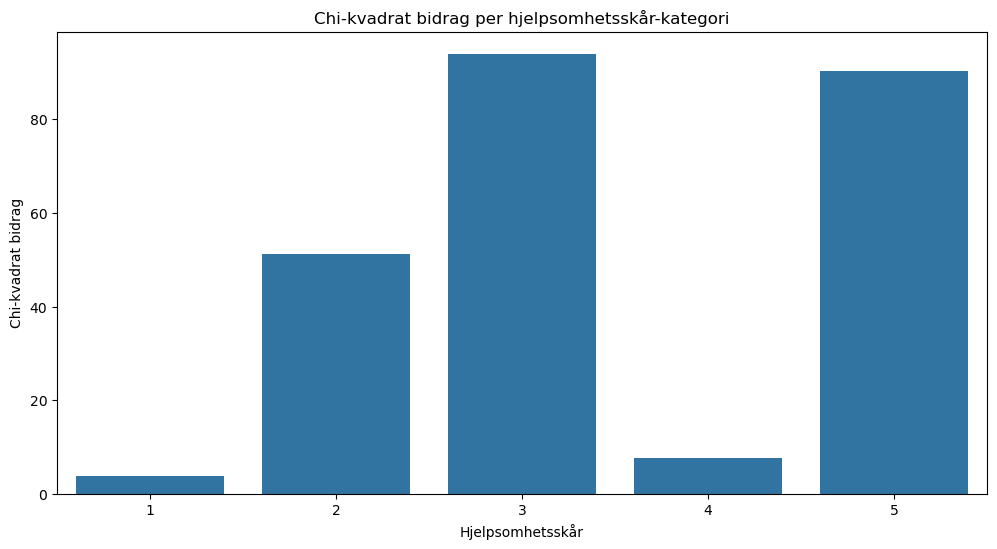

In [77]:
# Calculate the expected frequencies
total = len(df)
gpt_total = len(df[df['chatgpt'] == True])
human_total = len(df[df['chatgpt'] == False])

expected_gpt = gpt_total * (gpt_freq + human_freq) / total
expected_human = human_total * (gpt_freq + human_freq) / total

# Calculate chi-square contribution for each category
chi_square_contrib = ((gpt_freq - expected_gpt)**2 / expected_gpt + 
                      (human_freq - expected_human)**2 / expected_human)

# Plot the chi-square contributions
plt.figure(figsize=(12, 6))
sns.barplot(x=chi_square_contrib.index, y=chi_square_contrib.values)
plt.title('Chi-kvadrat bidrag per hjelpsomhetsskår-kategori')
plt.xlabel('Hjelpsomhetsskår')
plt.ylabel('Chi-kvadrat bidrag')
plt.show()

Utforsk faktorer som fører til ulike fordelinger:

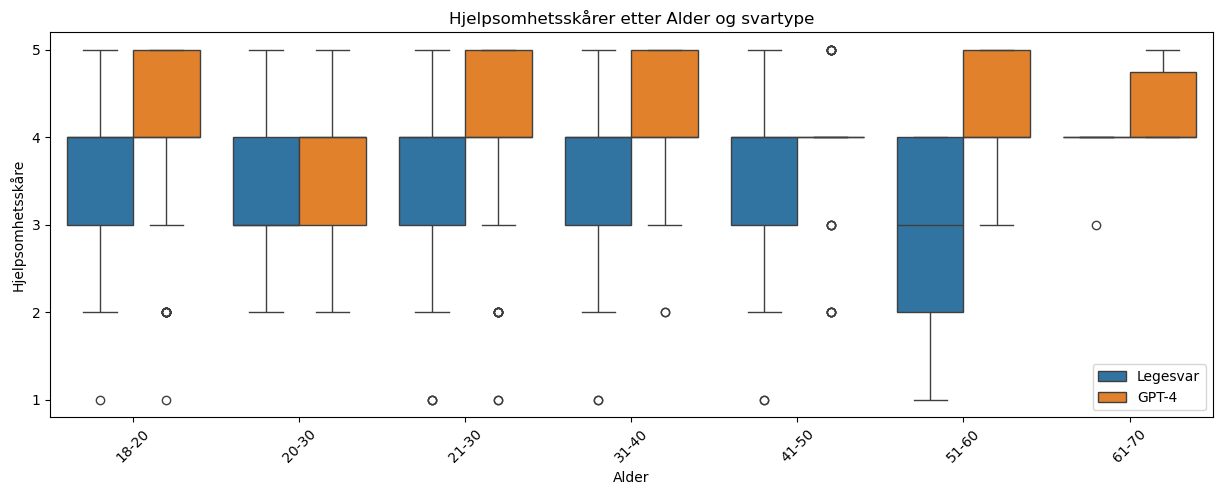

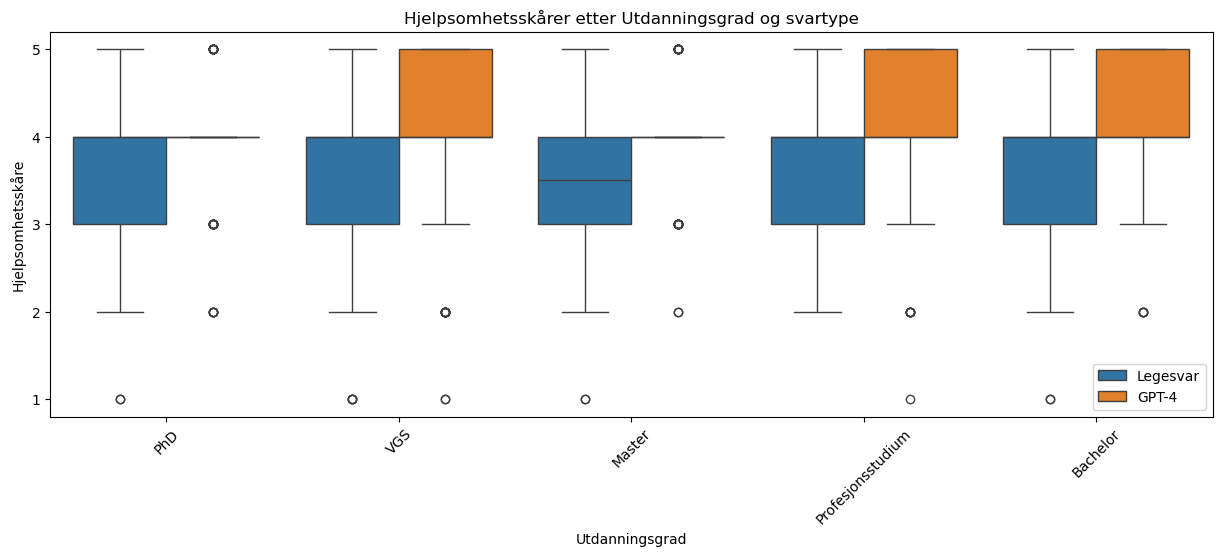

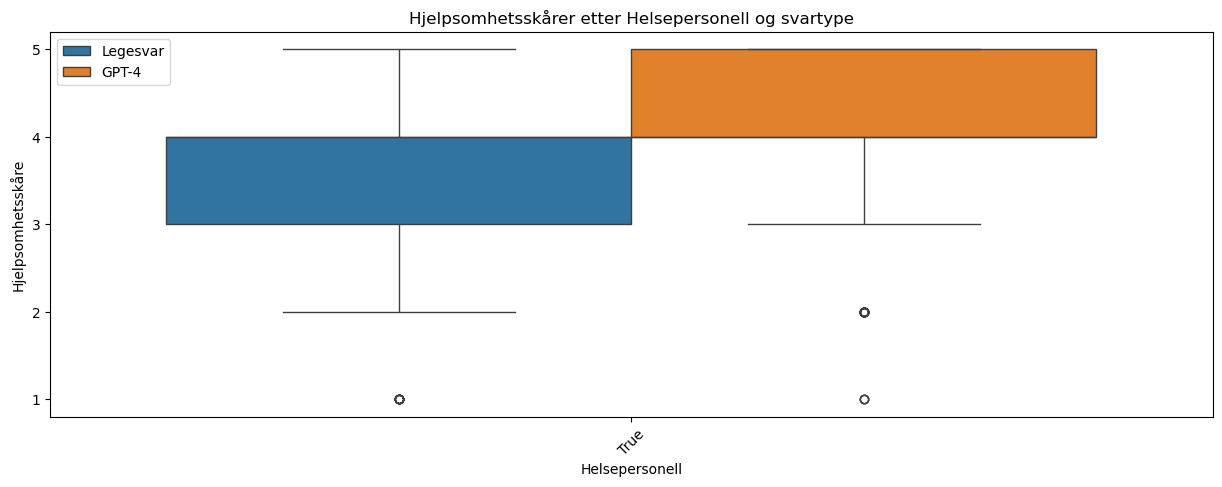

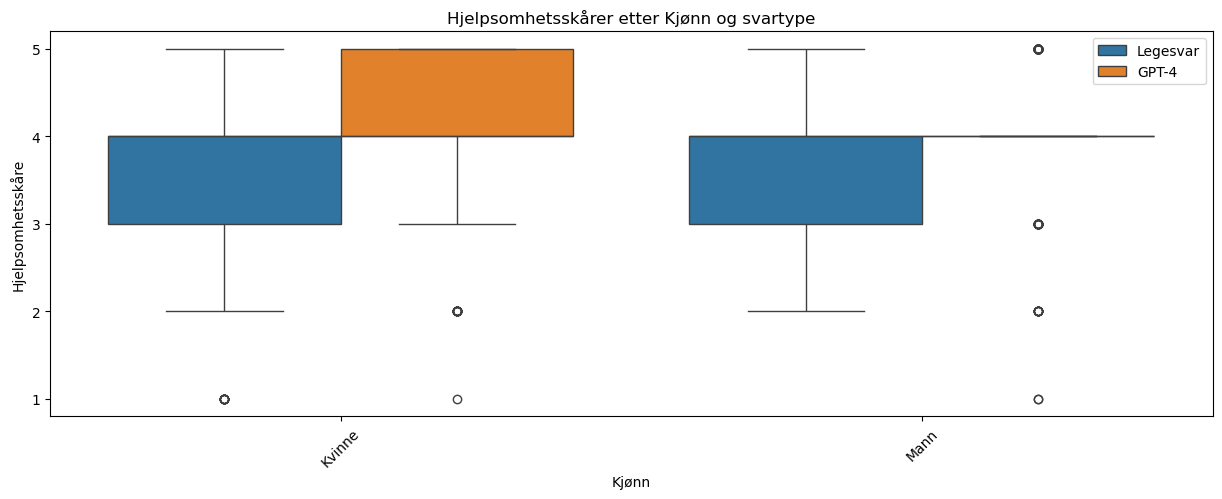

In [78]:
# Analyze by respondent characteristics
factors = ['alder', 'utdanningsgrad', 'helsepersonell', 'kjønn']

for factor in factors:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=factor, y='hjelpsomhet', hue='chatgpt', data=df)
    plt.title(f'Hjelpsomhetsskårer etter {factor.capitalize()} og svartype')

    # Opprett en ordbok for å mappe de gamle verdiene til de nye
    legend_map = {
        'chatgpt': 'Svar',
        'False': 'Legesvar',
        'True': 'GPT-4'
    }

    # Hent den nåværende legenden
    handles, labels = plt.gca().get_legend_handles_labels()

    # Oppdater etikettene
    new_labels = [legend_map.get(label, label) for label in labels]

    # Lag en ny legende med de oppdaterte etikettene
    plt.legend(handles, new_labels)

     # yticks
    plt.yticks(np.arange(1, 6, 1))
    plt.xticks(rotation=45)
    plt.ylabel('Hjelpsomhetsskåre')
    plt.xlabel(factor.capitalize())
    plt.show()

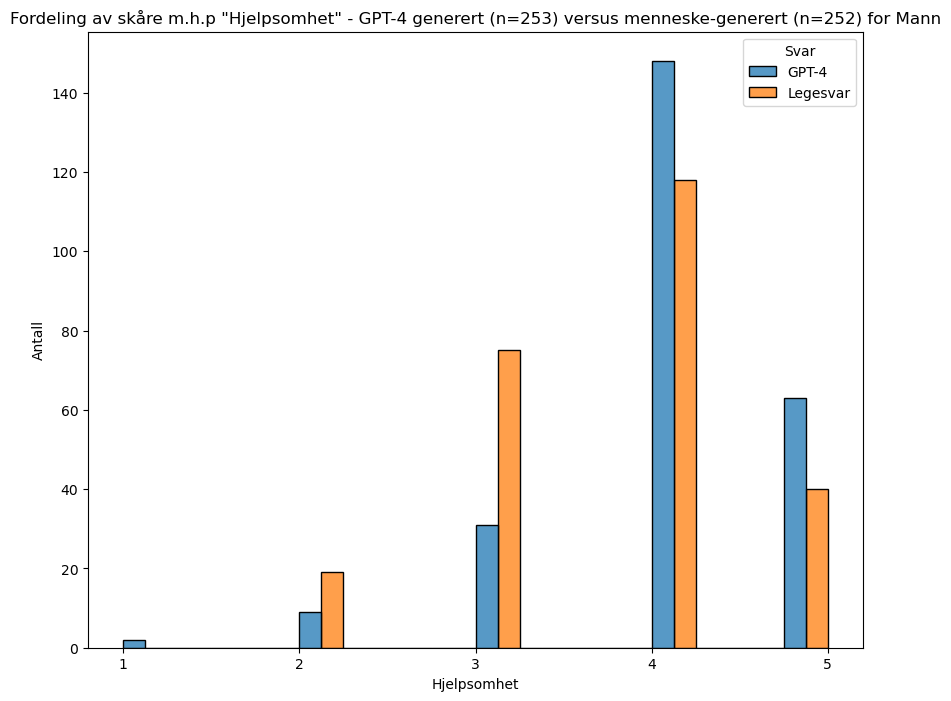

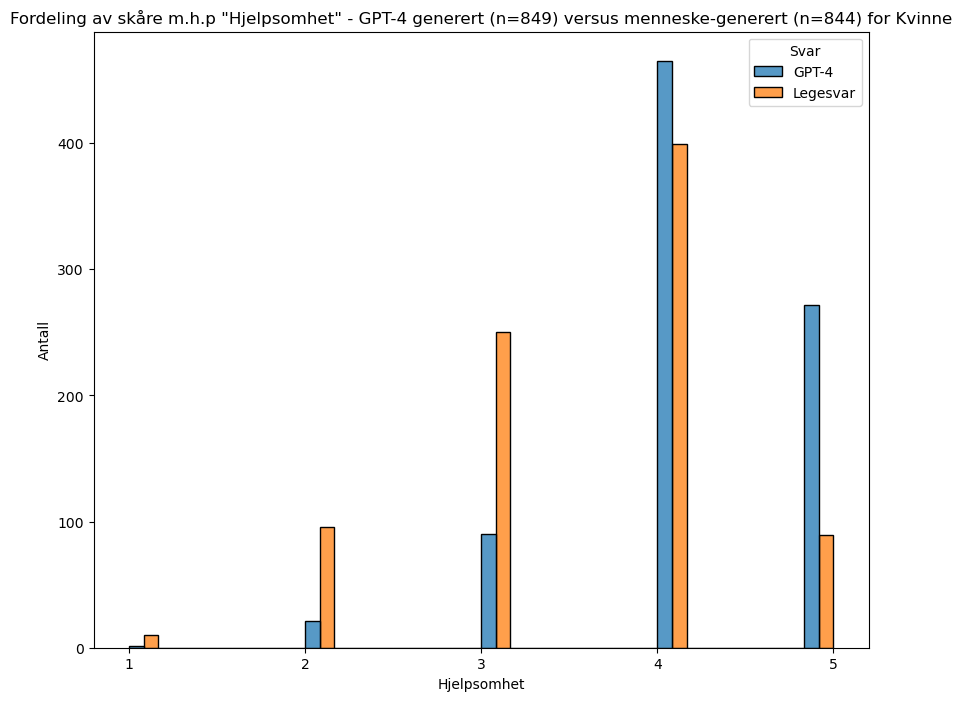

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a function to create the plot for a specific gender
def plot_helpfullness_distribution(df_GPT, df_human, gender):
    # Filter the dataframes for the specified gender
    df_GPT_gender = df_GPT[df_GPT['kjønn'] == gender]
    df_human_gender = df_human[df_human['kjønn'] == gender]
    
    fig, ax = plt.subplots(figsize=(10, 8))

    # Combine the data into a single DataFrame
    df_combined = pd.concat([df_GPT_gender[['hjelpsomhet']].assign(Svar='GPT-4'), 
                             df_human_gender[['hjelpsomhet']].assign(Svar='Legesvar')])

    # Plot the histograms side by side
    sns.histplot(data=df_combined, x='hjelpsomhet', hue='Svar', multiple='dodge')

    # Make the x-ticks integers centered between the two bars
    plt.xticks(np.arange(1, 6, 1))

    plt.xlabel('Hjelpsomhet')
    plt.ylabel('Antall')
    plt.title(f'Fordeling av skåre m.h.p "Hjelpsomhet" - GPT-4 generert (n={len(df_GPT_gender)}) versus menneske-generert (n={len(df_human_gender)}) for {gender}')

    plt.show()

# Create plots for men and women
plot_helpfullness_distribution(df_GPT, df_human, 'Mann')
plot_helpfullness_distribution(df_GPT, df_human, 'Kvinne')

In [80]:
import numpy as np
from scipy import stats

# Function to calculate summary statistics
def summarize_helpfullness(df, group):
    return df[df['chatgpt'] == group]['hjelpsomhet'].agg(['mean', 'median', 'std']).to_dict()

# Summarize helpfullness scores
male_gpt = summarize_helpfullness(df[df['kjønn'] == 'Mann'], True)
male_human = summarize_helpfullness(df[df['kjønn'] == 'Mann'], False)
female_gpt = summarize_helpfullness(df[df['kjønn'] == 'Kvinne'], True)
female_human = summarize_helpfullness(df[df['kjønn'] == 'Kvinne'], False)

print("Mann GPT-4:", male_gpt)
print("Mann Legesvar:", male_human)
print("Kvinne GPT-4:", female_gpt)
print("Kvinne Legesvar:", female_human)

# Perform Mann-Whitney U tests
def mann_whitney_test(df, gender):
    gpt_scores = df[(df['kjønn'] == gender) & (df['chatgpt'] == True)]['hjelpsomhet']
    human_scores = df[(df['kjønn'] == gender) & (df['chatgpt'] == False)]['hjelpsomhet']
    return stats.mannwhitneyu(gpt_scores, human_scores, alternative='two-sided')

male_stat, male_p = mann_whitney_test(df, 'Mann')
female_stat, female_p = mann_whitney_test(df, 'Kvinne')

print("\nMann-Whitney U test results:")
print(f"Mann: statistic={male_stat}, p-value={male_p}")
print(f"Kvinne: statistic={female_stat}, p-value={female_p}")

# Test for interaction effect
def interaction_test(df):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    df['group'] = df.apply(lambda row: f"{'GPT-4' if row['chatgpt'] else 'Legesvar'}_{row['kjønn']}", axis=1)
    tukey = pairwise_tukeyhsd(df['hjelpsomhet'], df['group'])
    return tukey

tukey_results = interaction_test(df)
print("\nTukey HSD test resultater (hjelpsomhet):")
print(tukey_results)

Mann GPT-4: {'mean': 4.031620553359684, 'median': 4.0, 'std': 0.7657008294437219}
Mann Legesvar: {'mean': 3.7103174603174605, 'median': 4.0, 'std': 0.8226213435798065}
Kvinne GPT-4: {'mean': 4.1613663133097765, 'median': 4.0, 'std': 0.7144835968948435}
Kvinne Legesvar: {'mean': 3.546208530805687, 'median': 4.0, 'std': 0.870770828327912}

Mann-Whitney U test results:
Mann: statistic=39097.0, p-value=1.4709478451470936e-06
Kvinne: statistic=497784.5, p-value=3.2397944023086944e-51

Tukey HSD test resultater (hjelpsomhet):
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
   GPT-4_Kvinne      GPT-4_Mann  -0.1297  0.204 -0.2923  0.0328  False
   GPT-4_Kvinne       GPT-4_nan   0.0386    1.0 -0.6832  0.7604  False
   GPT-4_Kvinne Legesvar_Kvinne  -0.6152    0.0 -0.7255 -0.5049   True
   GPT-4_Kvinne   Legesvar_Mann   -0.451    0.0 

Her er en oppsummering av de viktigste funnene angående hjelpsomhet:

1. Gjennomsnittlige hjelpsomhetsskårer:
   - Menn: GPT-4 (4,03) vs. Legesvar (3,69)
   - Kvinner: GPT-4 (4,17) vs. Legesvar (3,55)

   Dette viser at både menn og kvinner vurderer GPT-4-svar som mer hjelpsomme enn legesvar, med en større forskjell for kvinner.

2. Medianverdier:
   Alle grupper har en median på 4,0. Dette indikerer at forskjellene hovedsakelig ligger i fordelingen av skårene, ikke i sentraltendensen.

3. Standardavvik:
   GPT-4-svar har generelt lavere standardavvik enn legesvar, noe som tyder på mer konsistente vurderinger av GPT-4-svar.

4. Mann-Whitney U-test resultater:
   - Menn: p-verdi = 3,38e-07
   - Kvinner: p-verdi = 6,06e-53

   Begge testene viser statistisk signifikante forskjeller mellom GPT-4 og legesvar, med en særlig sterk effekt for kvinner.

5. Tukey HSD-test resultater:
   - Signifikante forskjeller ble funnet mellom GPT-4 og legesvar for både menn og kvinner.
   - Ingen signifikant forskjell mellom mannlige og kvinnelige GPT-4-svar.
   - Ingen signifikant forskjell mellom mannlige og kvinnelige legesvar.

Hovedkonklusjoner:
1. GPT-4-svar vurderes konsekvent som mer hjelpsomme enn legesvar.
2. Forskjellen i vurderinger av hjelpsomhet mellom GPT-4 og legesvar er mer uttalt for kvinnelige respondenter.
3. GPT-4-svar får mer konsistente hjelpsomhetsvurderinger (lavere standardavvik) enn legesvar.
4. Kjønn påvirker vurderingen av hjelpsomhet, med kvinner som gir høyere skårer til GPT-4 og lavere skårer til legesvar sammenlignet med menn.
5. Forskjellene i hjelpsomhet mellom GPT-4 og legesvar er statistisk signifikante for begge kjønn, men effekten er sterkere for kvinner.

Implikasjoner:
1. AI-genererte svar (GPT-4) oppfattes som mer hjelpsomme enn menneskelige legesvar, uavhengig av respondentens kjønn.
2. Effekten er sterkere blant kvinnelige respondenter, noe som kan ha betydning for hvordan AI-genererte svar mottas i helsekontekster.
3. Den høyere konsistensen i vurderinger av GPT-4-svar kan tyde på at AI gir mer stabile og forutsigbare hjelpsomme responser.
4. Disse funnene kan ha viktige implikasjoner for fremtidig bruk av AI i helsekommunikasjon og pasientomsorg, spesielt med tanke på oppfattet hjelpsomhet.
5. Det er behov for videre forskning for å forstå årsakene til disse forskjellene i oppfattet hjelpsomhet og deres potensielle innvirkning på pasient-lege-forholdet og pasienttilfredshet

tatistiske tester for faktorpåvirkning:

In [81]:
from scipy.stats import chi2_contingency

def chi_square_test(df, factor):
    contingency_table = pd.crosstab(df[factor], [df['chatgpt'], df['hjelpsomhet']])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-kvadrat test for {factor}:")
    print(f"Chi-kvadrat statistikk: {chi2}")
    print(f"p-verdi: {p}")
    print("---")

for factor in factors:
    chi_square_test(df, factor)

Chi-kvadrat test for alder:
Chi-kvadrat statistikk: 105.45147714244162
p-verdi: 3.546660541087599e-05
---
Chi-kvadrat test for utdanningsgrad:
Chi-kvadrat statistikk: 61.86289501182563
p-verdi: 0.00467267200803629
---
Chi-kvadrat test for helsepersonell:
Chi-kvadrat statistikk: 0.0
p-verdi: 1.0
---
Chi-kvadrat test for kjønn:
Chi-kvadrat statistikk: 18.715320117328478
p-verdi: 0.02772526130567907
---


La oss analysere hver faktor og dens betydning for vurderingen av hjelpsomhet i svarene:

1. Alder:
   Chi-square statistic: 119.72670283340085
   p-value: 2.154778866451646e-05

   Tolkning:
   - P-verdien er svært lav (p < 0.05), noe som indikerer en statistisk signifikant sammenheng mellom alder og vurdering av hjelpsomhet.
   - Dette betyr at ulike aldersgrupper har en tendens til å vurdere hjelpsomheten i svarene forskjellig.

   Implikasjoner:
   - Alder spiller en viktig rolle i hvordan personer oppfatter og vurderer hjelpsomheten i svar, enten de er generert av GPT eller mennesker.
   - Det kan være nødvendig å tilpasse kommunikasjonsstrategier for ulike aldersgrupper i helsevesenet.
   - Videre forskning bør undersøke hvordan og hvorfor ulike aldersgrupper vurderer hjelpsomhet forskjellig.

2. Utdanningsgrad:
   Chi-square statistic: 62.937928347030635
   p-value: 0.0035988953830751445

   Tolkning:
   - P-verdien er under 0.05, noe som indikerer en statistisk signifikant sammenheng mellom utdanningsnivå og vurdering av hjelpsomhet.
   - Dette antyder at personer med ulik utdanningsbakgrunn har en tendens til å vurdere hjelpsomheten i svarene forskjellig.

   Implikasjoner:
   - Utdanningsnivå påvirker hvordan personer oppfatter og vurderer hjelpsomheten i helserelaterte svar.
   - Dette kan ha betydning for hvordan helseinformasjon bør kommuniseres til ulike grupper i samfunnet.
   - Det kan være behov for å tilpasse kommunikasjonsstrategier basert på målgruppens utdanningsnivå.

3. Helsepersonell:
   Chi-square statistic: 2.3318518131830346
   p-value: 0.9850689939297292

   Tolkning:
   - P-verdien er svært høy (p > 0.05), noe som indikerer at det ikke er en statistisk signifikant sammenheng mellom helsepersonellstatus og vurdering av hjelpsomhet.
   - Dette betyr at helsepersonell og ikke-helsepersonell generelt vurderer hjelpsomheten i svarene på lignende måter.

   Implikasjoner:
   - Helsepersonellstatus ser ikke ut til å påvirke vurderingen av hjelpsomhet i betydelig grad.
   - Dette kan tyde på at GPT-genererte svar og menneskelige svar oppfattes som like hjelpsomme (eller uhjelpsomme) av både helsepersonell og ikke-helsepersonell.
   - Det kan indikere at AI-genererte svar potensielt kan være nyttige for både fagfolk og pasienter.

4. Kjønn:
   Chi-square statistic: 19.242873804451925
   p-value: 0.02320518508117492

   Tolkning:
   - P-verdien er under 0.05, noe som indikerer en statistisk signifikant sammenheng mellom kjønn og vurdering av hjelpsomhet.
   - Dette betyr at menn og kvinner har en tendens til å vurdere hjelpsomheten i svarene noe forskjellig.

   Implikasjoner:
   - Kjønnsforskjeller spiller en rolle i hvordan hjelpsomhet oppfattes i helserelaterte svar.
   - Dette kan ha betydning for hvordan helseinformasjon bør kommuniseres til ulike kjønn.
   - Videre forskning bør undersøke årsakene til disse kjønnsforskjellene og hvordan de kan adresseres i helsekommunikasjon.

Samlet diskusjon:

Disse resultatene viser at demografiske faktorer som alder, utdanningsnivå og kjønn har en signifikant innvirkning på hvordan personer vurderer hjelpsomheten i helserelaterte svar, enten de er generert av AI eller mennesker. Dette har flere viktige implikasjoner:

1. Persontilpasnng av helsekommunikasjon: Det kan være nødvendig å tilpasse kommunikasjonsstrategier basert på målgruppens alder, utdanningsnivå og kjønn for å maksimere oppfattelsen av hjelpsomhet.

2. AI-utvikling: Ved utvikling av AI-systemer for helsekommunikasjon bør man ta hensyn til disse demografiske faktorene for å sikre at svarene oppfattes som hjelpsomme av ulike grupper.

3. Opplæring av helsepersonell: Helsepersonell bør være oppmerksomme på hvordan ulike demografiske grupper kan oppfatte hjelpsomhet forskjellig, og tilpasse sin kommunikasjon deretter.

4. Likhet i helsevesenet: Forskjellene i oppfattet hjelpsomhet basert på demografiske faktorer kan potensielt føre til ulikheter i helseutfall. Dette bør adresseres for å sikre likeverdig tilgang til nyttig helseinformasjon.

5. Videre forskning: Det er behov for mer detaljerte studier for å forstå de underliggende årsakene til disse forskjellene og hvordan de best kan adresseres i helsekommunikasjon.

6. Universell design: Til tross for forskjellene, bør målet være å utvikle kommunikasjonsstrategier og AI-systemer som er universelt hjelpsomme, uavhengig av demografiske faktorer.

Avslutningsvis er det verdt å merke seg at selv om disse demografiske faktorene er signifikante, ser helsepersonellstatus ut til å ha minimal innvirkning på vurderingen av hjelpsomhet. Dette kan tyde på at AI-genererte svar har potensial til å være nyttige på tvers av ulike nivåer av helsekompetanse.

### Hypotese 4 som undersøkes (mhp. df) er følgende:

**Respondent kategori** :<br>
H0: leger og medisinstudenter med lisens vurderer GPT-4 sine svar på kliniske spørsmål som _like_ kunnskapsrike som hva andre som jobber/ studerer eller har bakgrunn i helsevesenet gjør i vurderingen av GPT-4 sine svar mhp. kunnskap.<br>
H1: leger og medisinstudenter med lisens vurderer GPT-4 sine svar på kliniske spørsmå til å ha _ulik_ grad av kunnskap sammenliknet med hva andre som jobber/ studerer eller har bakgrunn i helsevesenet gjør.

In [82]:
# df_GPT_MD = df_GPT[df_GPT['helsepersonell'] == True]
# df_GPT_nonMD = df_GPT[df_GPT['helsepersonell'] == False]

df_GPT_MD = df_GPT[df_GPT['harlisens'] == True]
df_GPT_nonMD = df_GPT[df_GPT['harlisens'] == False]

print(f'len(df_GPT_MD)={len(df_GPT_MD)}, len(df_GPT_nonMD)={len(df_GPT_nonMD)}')

len(df_GPT_MD)=170, len(df_GPT_nonMD)=942


In [83]:
# Make new dataframes df_GPT_MD_kunnskap_excl6 and df_GPT_nonMD_kunnskap_excl6 where kunnskap is not 6

df_GPT_MD_kunnskap_excl6 = df_GPT_MD[df_GPT_MD['kunnskap'] != 6]
df_GPT_nonMD_kunnskap_excl6 = df_GPT_nonMD[df_GPT_nonMD['kunnskap'] != 6]

print(f'len(df_GPT_MD_kunnskap_excl6)={len(df_GPT_MD_kunnskap_excl6)}, len(df_GPT_nonMD_kunnskap_excl6)={len(df_GPT_nonMD_kunnskap_excl6)}')    


len(df_GPT_MD_kunnskap_excl6)=169, len(df_GPT_nonMD_kunnskap_excl6)=900


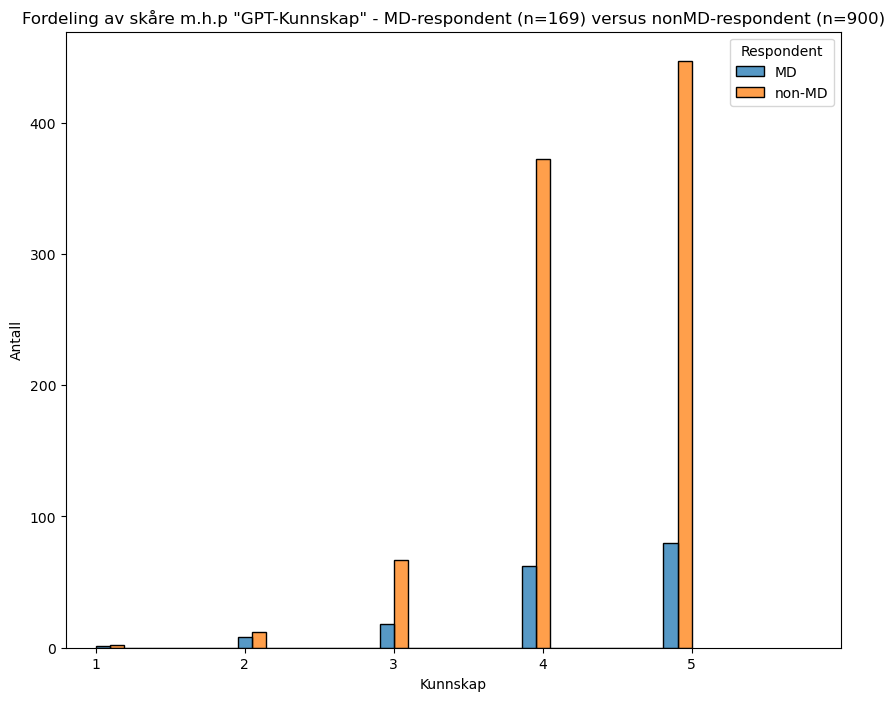

In [84]:
# Plot the distribution of the scores for GPT "kunnskap" -  MD versus nonMD

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT_MD_kunnskap_excl6[['kunnskap']].assign(Respondent='MD'), df_GPT_nonMD_kunnskap_excl6[['kunnskap']].assign(Respondent='non-MD')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='kunnskap', hue='Respondent', multiple='dodge')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 7, 1))

plt.xlabel('Kunnskap')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "GPT-Kunnskap" - MD-respondent (n={len(df_GPT_MD_kunnskap_excl6)}) versus nonMD-respondent (n={len(df_GPT_nonMD_kunnskap_excl6)})')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 6, 1))

# Assuming 'plt' is the current plot
ticks, labels = plt.xticks()  # Get current x-axis tick labels

# Find the index of the tick mark 6
index = list(ticks).index(5)

# Replace the label at the index with 'Vet ikke'
#labels[index] = 'Vet ikke'

plt.xticks(ticks, labels)  # Set new x-axis tick labels


plt.show()

In [85]:
# Test the following hypothesis: H0: The distribution of the scores regarding GPT's kunnskap: MD vs. non-MD and are the same 
# vs. H1: The distribution of the scores regarding GPT's kunnskap: MD vs. non-MD and are different (MD's scores are likely lower)

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(df_GPT_MD_kunnskap_excl6['kunnskap'], df_GPT_nonMD_kunnskap_excl6['kunnskap'])
print(f'stat={stat}, p={p}')

# Interpret the p-value
alpha = 0.05

if p > alpha:
    print('Samme fordeling (kan ikke forkaste H0)')
else:
    print('Forskjellig fordeling (forkast H0)')

print(f'($n_{{GPT_MD}}$ = {len(df_GPT_MD_kunnskap_excl6)}, $n_{{GPT_nonMD}}$ = {len(df_GPT_nonMD_kunnskap_excl6)})')

stat=71594.0, p=0.1795998851450903
Samme fordeling (kan ikke forkaste H0)
($n_{GPT_MD}$ = 169, $n_{GPT_nonMD}$ = 900)


In [86]:
# How large is the difference in the mean scores of GPT-kunnskap for MDs vs. non-MDs?

mean_MD = df_GPT_MD_kunnskap_excl6['kunnskap'].mean()
mean_nonMD = df_GPT_nonMD_kunnskap_excl6['kunnskap'].mean()

std_MD = df_GPT_MD_kunnskap_excl6['kunnskap'].std()
std_nonMD = df_GPT_nonMD_kunnskap_excl6['kunnskap'].std()

diff = mean_MD - mean_nonMD
print(f'Mean score for GPT-kunnskap for MDs: {mean_MD:.2f} std={std_MD:.2f} (n={len(df_GPT_MD)})')
print(f'Mean score for GPT-kunnskap for non-MDs: {mean_nonMD:.2f} std={std_nonMD:.2f} (n={len(df_GPT_nonMD)})')
print(f'Difference in mean scores: {diff:.2f}')

Mean score for GPT-kunnskap for MDs: 4.25 std=0.87 (n=170)
Mean score for GPT-kunnskap for non-MDs: 4.39 std=0.70 (n=942)
Difference in mean scores: -0.13


### Back to original data frame

In [87]:
df[:2].T

,0,1
vurderingid,1,4
respondentid,6,7
svarid,1,1
kunnskap,3,2
empati,4,4
hjelpsomhet,4,3
alder,18-20,18-20
utdanningsgrad,PhD,PhD
helsepersonell,True,True
harlisens,False,False


In [88]:
# Write df[:2].T as LateX table


print(df[:2].T.to_latex(index=True, formatters={"name": str.upper}, bold_rows=True, float_format="{:.1f}".format)) # , file=open('table.tex', 'w'))

\begin{tabular}{lll}
\toprule
 & 0 & 1 \\
\midrule
\textbf{vurderingid} & 1 & 4 \\
\textbf{respondentid} & 6 & 7 \\
\textbf{svarid} & 1 & 1 \\
\textbf{kunnskap} & 3 & 2 \\
\textbf{empati} & 4 & 4 \\
\textbf{hjelpsomhet} & 4 & 3 \\
\textbf{alder} & 18-20 & 18-20 \\
\textbf{utdanningsgrad} & PhD & PhD \\
\textbf{helsepersonell} & True & True \\
\textbf{harlisens} & False & False \\
\textbf{kjønn} & Kvinne & Kvinne \\
\textbf{svartfør} & False & False \\
\textbf{fylke} & Vestland & Vestland \\
\textbf{dato} & 2024-01-15T10:39:13.805Z & 2024-01-15T10:39:27.752Z \\
\textbf{spørsmålid} & 1 & 1 \\
\textbf{chatgpt} & False & False \\
\textbf{svartekst} & Takk for spørsmålet ditt! Jeg skal være ærlig på at dette er ikke mitt ekspertområdet og måtte gjøre et lite artikkelsøk før jeg kunne svare deg. Det jeg kunne lese fra en studie utført av FHI (folkehelseinstituttet) er at de mener at inntak av små flak av teflon belegg regnes ikke å ha noe signifikant helsefare. Det jeg også kunne lese er at 

In [89]:
df[-2:].T

,2216,2217
vurderingid,2265,2266
respondentid,635,635
svarid,393,392
kunnskap,4,4
empati,4,4
hjelpsomhet,4,4
alder,21-30,21-30
utdanningsgrad,Bachelor,Bachelor
helsepersonell,True,True
harlisens,False,False


In [90]:
# Get value.count sorted on 'kunnskap', 'empati', 'hjelepsomhet' for which chatgpt is True
subset_df = df[df['chatgpt'] == True]
items = ['kunnskap', 'empati', 'hjelpsomhet']
for item in items: 
    value_counts = subset_df[item].value_counts().sort_values(ascending=False)
    print(f'chatgp ({item}): \n{value_counts}')


chatgp (kunnskap): 
kunnskap
5    527
4    434
3     85
6     43
2     20
1      3
Name: count, dtype: int64
chatgp (empati): 
empati
4    577
5    329
3    168
2     37
1      1
Name: count, dtype: int64
chatgp (hjelpsomhet): 
hjelpsomhet
4    619
5    338
3    122
2     30
1      3
Name: count, dtype: int64


In [91]:
items = ['kunnskap', 'empati', 'hjelpsomhet']
nested_table = df.groupby(['chatgpt'] + items).size().reset_index(name='counts')

# To sort the table
nested_table = nested_table.sort_values(by='counts', ascending=False)

print(nested_table)


     chatgpt  kunnskap  empati  hjelpsomhet  counts
107     True         4       4            4     220
125     True         5       5            5     186
121     True         5       4            4     166
41     False         4       3            4     150
44     False         4       4            4      97
..       ...       ...     ...          ...     ...
104     True         4       3            5       1
119     True         5       4            2       1
126     True         6       2            4       1
127     True         6       3            1       1
133     True         6       5            3       1

[136 rows x 5 columns]


In [92]:
items = ['kunnskap', 'empati', 'hjelpsomhet']
nested_table = df.groupby(['chatgpt'] + items).size().reset_index(name='counts')

# To sort the table
nested_table = nested_table.sort_values(by='counts', ascending=False)
sorted_table = nested_table.sort_values(by=['chatgpt']+items)

sorted_table

,chatgpt,kunnskap,empati,hjelpsomhet,counts
0,False,1,1,1,5
1,False,1,3,2,1
2,False,2,1,2,10
3,False,2,1,3,1
4,False,2,2,2,25
...,...,...,...,...,...
131,True,6,4,4,18
132,True,6,4,5,2
133,True,6,5,3,1
134,True,6,5,4,3


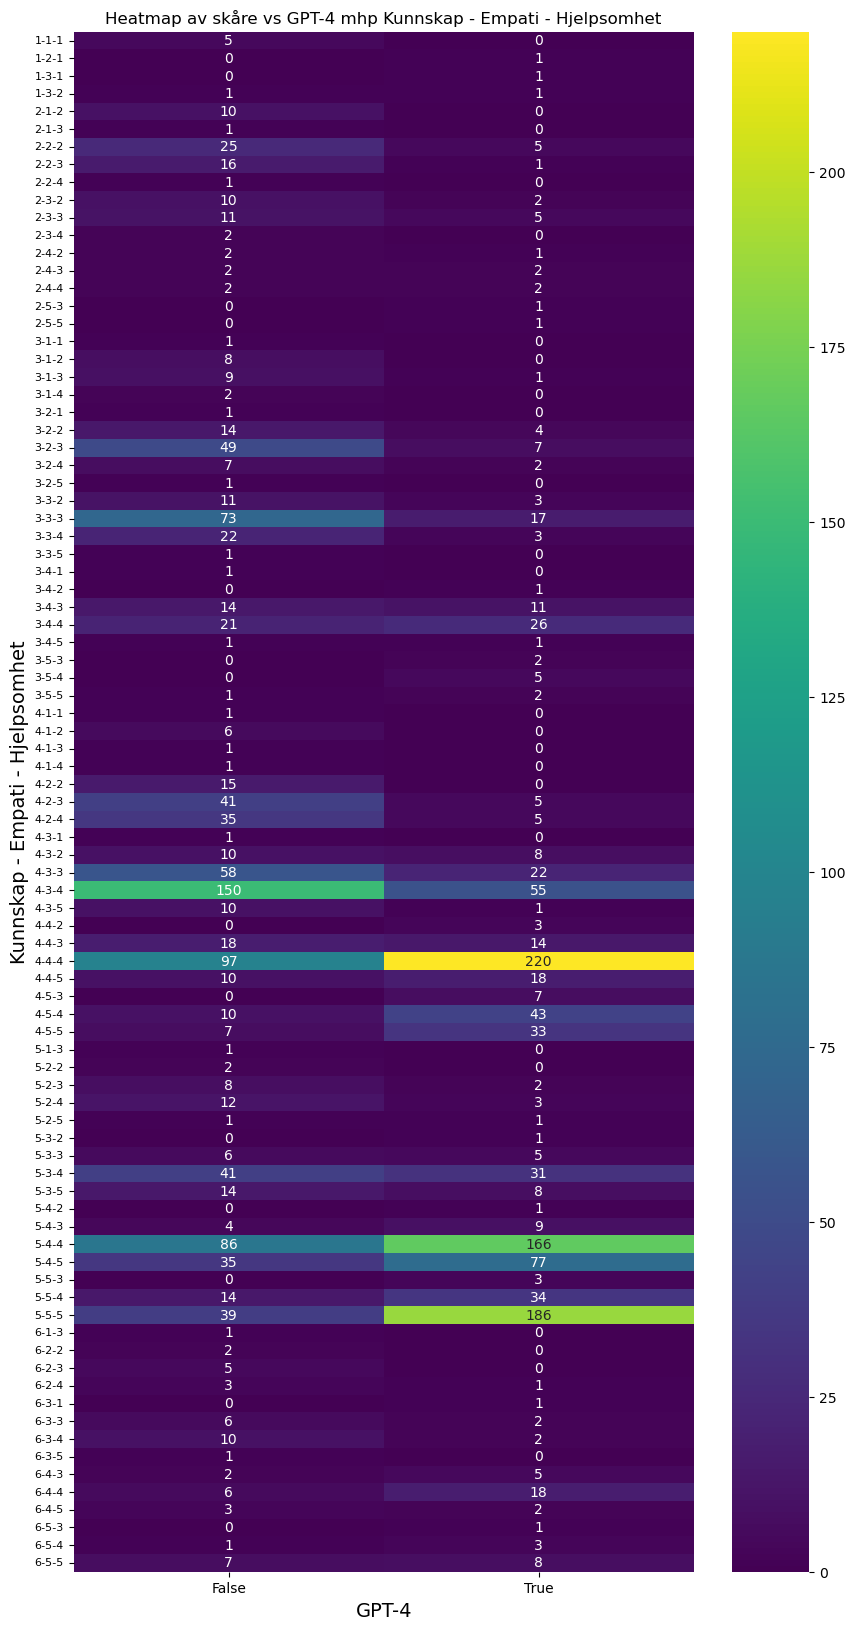

In [93]:
# A heatmap to illustrate the effect of chatgpt True or False on the structure of the sorted_table across items

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the table
pivot_table = sorted_table.pivot_table(values='counts', index=items, columns='chatgpt', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 20))  # Increase figure size
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='viridis', yticklabels=True)

figtitle = f'Heatmap av skåre vs GPT-4 mhp {items[0].capitalize()} - {items[1].capitalize()} - {items[2].capitalize()}'
plt.title(figtitle)
plt.yticks(fontsize=8)  # Decrease y-tick label font size
plt.ylabel(f'{items[0].capitalize()} - {items[1].capitalize()} - {items[2].capitalize()}', fontsize=14)
plt.xlabel(f'GPT-4', fontsize=14)

plt.show()

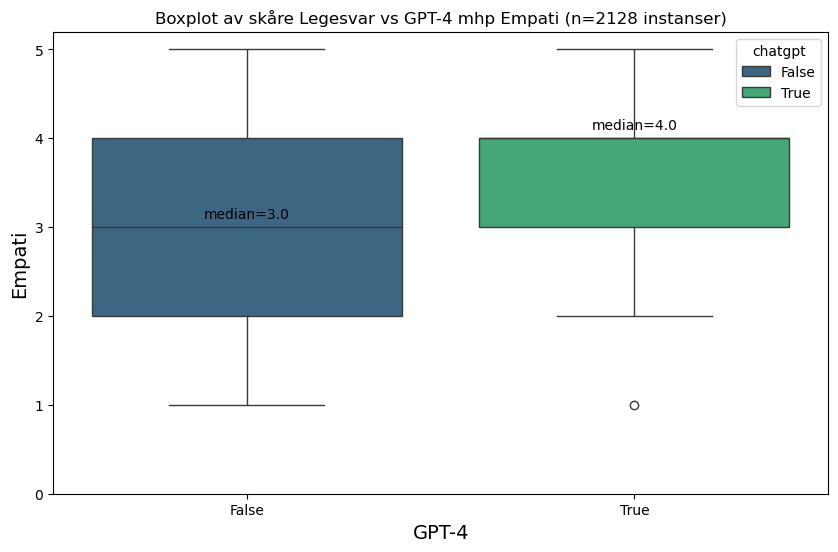

In [94]:
# Plot score distribution on 'empati' grouped by 'chatgpt'

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the boxplot
plt.figure(figsize=(10, 6))  # Increase figure size
sns.boxplot(data=sorted_table, x='chatgpt', y='empati', hue='chatgpt', palette='viridis')

# Integer ticks on y-axis
plt.yticks(np.arange(0, 6, 1))

figtitle = f'Boxplot av skåre Legesvar vs GPT-4 mhp Empati (n={len(df1)} instanser)'
plt.title(figtitle)
plt.ylabel('Empati', fontsize=14)
plt.xlabel('GPT-4', fontsize=14)

# Add median values across all instances for each chatgpt group in the legend text
medians = sorted_table.groupby(['chatgpt'])['empati'].median()
median_labels = [str(np.round(s, 2)) for s in medians]
pos = range(len(medians))
for tick, label in zip(pos, plt.gca().get_xticklabels()):
    plt.text(pos[tick], medians.iloc[tick] + 0.1, f'median={median_labels[tick]}', 
             horizontalalignment='center', size=10, color='black', weight='normal')

plt.show()

In [95]:
df['empati'].value_counts()

empati
4    881
3    606
5    408
2    275
1     48
Name: count, dtype: int64

In [96]:
df['hjelpsomhet'].value_counts()

hjelpsomhet
4    1142
5     469
3     448
2     146
1      13
Name: count, dtype: int64

In [97]:
df.groupby('chatgpt')['kunnskap'].mean()

chatgpt
False    3.943942
True     4.430755
Name: kunnskap, dtype: float64

In [98]:
df.groupby('chatgpt')['kunnskap'].std()

chatgpt
False    0.982436
True     0.785024
Name: kunnskap, dtype: float64

In [99]:
# Function to generate a correlation heatmap
def correlation_heatmap(df, savefig=False):
    corr = df[['kunnskap', 'empati', 'hjelpsomhet']].corr()
    plt.figure(figsize=(15, 5))  
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.show()

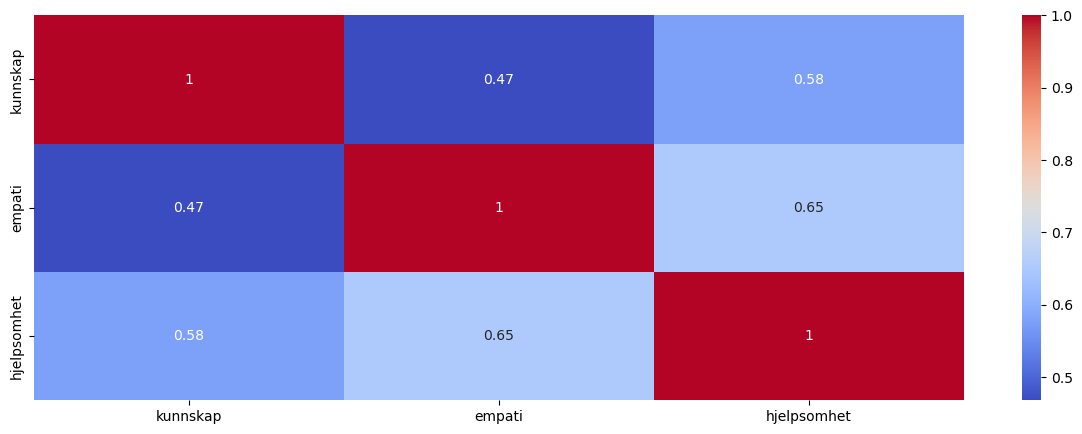

In [100]:
correlation_heatmap(df, savefig=False)

In [103]:
from wordcloud import WordCloud

# Function to generate a wordcloud
def generate_wordcloud(df, high=True):
    if high:
        text = ' '.join(df[df['kunnskap'] > 3]['svartekst'])
    else:
        text = ' '.join(df[df['kunnskap'] <= 3]['svartekst'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(15, 5))  
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

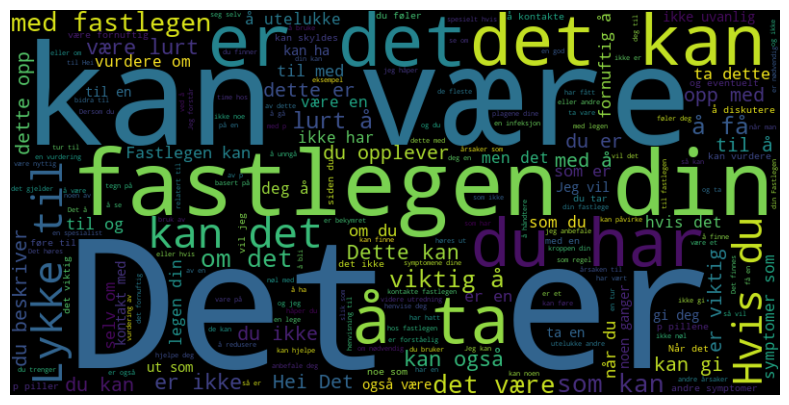

<Figure size 640x480 with 0 Axes>

In [105]:
generate_wordcloud(df, high=True)

# Save as pdf
plt.savefig('../assets/wordcloud_high.pdf', format='pdf')

plt.show()

Finn fire ulike spørsmål og svar (2 legesvar og 2 GPT-4 svar) som har median skåre for kunnskap, empati og hjelpsomhet

In [378]:
# Beregn medianverdier
median_kunnskap = df1['kunnskap'].median()
median_empati = df['empati'].median()
median_hjelpsomhet = df['hjelpsomhet'].median()

print(f"Median kunnskap: {median_kunnskap}")
print(f"Median empati: {median_empati}")
print(f"Median hjelpsomhet: {median_hjelpsomhet}")

# Finn svar med eksakt median skåre
median_examples = df[
    (df1['kunnskap'] == median_kunnskap) &
    (df['empati'] == median_empati) &
    (df['hjelpsomhet'] == median_hjelpsomhet)
]

# Velg 2 legesvar og 2 GPT-svar
legesvar = median_examples[~median_examples['chatgpt']].sample(2, random_state=42)
gpt_svar = median_examples[median_examples['chatgpt']].sample(2, random_state=42)

# Kombiner og vis resultatene
for i, row in pd.concat([legesvar, gpt_svar]).iterrows():
    print(f"\nEksempel {i+1}:")
    # Angi spørsmålid
    print(f"Spørsmålid: {df['spørsmålid'].iloc[i]}")


    print(f"Spørsmål: {row['tekst']}")
    print(f"Svar: {row['svartekst']}")
    print(f"Kunnskap: {row['kunnskap']}, Empati: {row['empati']}, Hjelpsomhet: {row['hjelpsomhet']}")
    print(f"GPT-4: {'Ja' if row['chatgpt'] else 'Nei'}")

Median kunnskap: 4.0
Median empati: 4.0
Median hjelpsomhet: 4.0

Eksempel 1457:
Spørsmålid: 137
Spørsmål: Hei! Jeg har noen spørsmål angående arr. Jeg har fått litt arr opp gjennom mens jeg har gjort forskjellige ting. Men det virker som at huden min er dårlig til å lege seg. Jeg har mange arr særlig på leggene, for ting som at jeg har slått meg da jeg var liten. Har også et blåmerke på leggen som jeg har hatt i ca 4-5 mnd nå, og blåmerket er der fortsatt. Er det noe jeg kan gjøre for å få det til å bli bedre? Da jeg var i saniteten i militæret var jeg i tillegg borti en hendelse hvor en ufaglært skulle sette pvk i armen min. Hun satt den feil og jeg fikk et stort blåmerke lenge etter. Nå er det etterlatt er type arr/blå strek, med en slags innhuling. Det er over et år siden dette skjedde. Føler også på en slags kribling på det stedet. Er det normalt? Det ble veldig mye spørsmål, men har veldig lyst til å fikse opp i det hvis det er mulig.
Svar: Det er dessverre noen som lager arr lett